# [Draft] **Workbook for the study of coordinated reset in a simulation of subthalamic nucleus**

## Author Informtation
This work was performed by Matteo Coscia(1), Anthony Lee (1), Jesse Gilmer(1), Ali Khaledi-Nasab(2), and Mazen Al Borno(1).

1.   University of Colorado, School of Medicine - Computer Science and Bioengineering, and Computational Biology
2.   Amazon - Amazon Web Services Network Capacity Team.

The following is a work in progress. Contact J. Gilmer for queries at: jesse dot gilmer at cuanschutz dot edu.

To Do:
* Refine results text.
* Rework plotting functions.
* Setup a github and merge structure for the project.
* Do research into STN connectivity and projection anatomy.
* Make an RL agent for frequency and sites.
* Make matrix form of structured_conn().

# Abstract


Abnormal synchrony in the subthalamic nucleus is thought to be an intermediate etiology in Parkinson's disease symptomology. The application of high-frequency stimulation through implanted deep brain stimulators is thought to offset or interrupt aberrant outputs of the neural structures impacted by Parkinson's. However, high frequency stimulation has a number of off-target effects that can severely impact the quality of life for patients receiving this therapy, neccessitating alternatives. Research into therapies that treat the disease state of Parkinson's while reducing side effects have shown that random patterned stimulations, termed coordinated reset, can be effective in treating Parkinson's without relying on high frequency stimulation, thereby reducing negative effects of the therapy. This therapy is also thought to be an improvement over high-frequency stimualtion because the duration of its beneficial effects persists for longer than traditional stimuli. Interestingly, coordinated reset can also be applied through peripheral stimulation of the fingers, presumably by altering the statistics of inputs to the subthalamic nucleus through an ascending sensory pathway. While this therapy has been somewhat successful in small clinical trials, it remains unclear what the optimal stimulus patterning should be to best alleviate Parkinsonian symptoms. Here, we reestablish a computational model previously used to test stimulation patterns in peripheral coordinated reset and test a wide range of potential stimulation parameters to assay their effect on changes to connectivity weighting and synchrony, and find that low frequency stimuli across a moderate number of tactile sites best reduces abnormal synchrony in the system. Building upon this, we applied a reinforcement learning approach to parameter selection and found [something]. Additionally, we explore the effect of stimulation site selection by examining the effect of stimualting targets whose neural representation is relatively proximal vs those that are represented distally within the subthalamic nucleus and found [something]. The outcomes from this modelling approach can help clinicians to select the best course for treating Parkinson's disease, and other diseases of abnormal neural synchrony, using non-invasive peripheral therapies.

# Methods

## Model Dependencies
This model uses matplotlib, numpy, scipy, and the standard math package.


In [1]:
import matplotlib.pyplot as plt    # MatPlotLib is a plotting package. 
import numpy as np                 # NumPy is a numerical types package.
from scipy import stats            # ScPy is a scientific computing package. We just want the stats, because Ca2+ imaging is always calculated in z-score.
from scipy.stats import circmean
import math
from posixpath import join
from datetime import datetime

# Setup in-notebook plotting:
%matplotlib inline

##Model Description:
This LIF model is based on Kromer et al., 2020. [Go to Citations](#scrollTo=nbz2NLycMZr5)

This model seeks to establish a model of a neural circuit with either random or spatially structured connectivity. This class also has several functions used for examining the model output, such as the cellular voltage, spike record, and changes in weight and synchrony over time. The default network is biased towards over-synchronization, which is meant to model the disease state of Parkinson's disease in the subthalamic nucleus, which has an abnormal degree of synchrony in Parkinsonian patients. 

The model uses a spike timing dependent plasticity (STDP) rule to alter the weights of synaptic connections between neurons in respone to spiking. This mechanism uses a Hebbian framework, such that neurons that spike after recieving an input from their presynapic partner will strengthen that synapse, and neurons that spike before recieving an input will weaken that synapse.

To assay the degree of synchrony in the network, we applied Kuramato's method to the spike timing on the neural population. To do this, we treated each spike as a vector on a circle with a period of 20ms, by default. The mean spiking vectors of each neuron were then projected onto the imaginary plane and averaged. The magnitude of the resultant mean was used to determine the synchrony of spiking, where a large vector (with a maximum of 1) indicates that all neurons are spiking at the same time, and a small vector (with a minimum of 0) indicating that all neurons are firing independently, with no shared patterning.


In [2]:
#@title LIF Model

# Define LIF neurons:
class LIF_Network:
  def __init__(self, n_neurons = 1000, dimensions = [[0,100],[0,100],[0,100]]):
    # Neuron count
    self.n_neurons = n_neurons
    
    # spatial organization.
    self.dimensions = dimensions;
    self.x = np.random.uniform(low=self.dimensions[0][0], high=self.dimensions[0][1], size=(self.n_neurons,))
    self.y = np.random.uniform(low=self.dimensions[1][0], high=self.dimensions[1][1], size=(self.n_neurons,))
    self.z = np.random.uniform(low=self.dimensions[2][0], high=self.dimensions[2][1], size=(self.n_neurons,))

    # internal time trackers
    self.t = 0                 # current time [ms]
    self.dt = .1               # time step [ms]
    self.t_itt = 0             # time index
    self.relax_time = 10000    # length of relaxation phase [ms]

    # electrophysiology values
    self.v = np.random.uniform(low=-10, high=10, size=(self.n_neurons,)) - 45               #  internal voltage [mV]
    self.v_rest = -38                                                                       #  the resting voltage, equilibrium [mV] def: -38

    self.v_thr = np.ones([self.n_neurons,]) * -40                                           #  reversal potential for spiking [mV]
    self.v_rf_thr = np.ones([self.n_neurons,]) * -40                                        #  reversal potential for spiking during refractory period [mV]
    self.v_rf_tau = 5                                                                       #  the relaxation tau between refractory and normal thresholds.

    self.v_reset = -67                                                                      #  the reset, overshoot voltage [mV]
    self.v_spike = 20                                                                       #  the voltage that spikes rise to [mV]
    self.v_rf_spike = 0                                                                     #  the threshold that changes in the refractory period [mV]
    self.spike_length = 1
    self.spike_flag = np.zeros([self.n_neurons,])
    self.t_spike1 = np.zeros([self.n_neurons,]) - 10000
    self.t_spike2 = np.zeros([self.n_neurons,]) - 10000
    self.spike_record = np.empty(shape=[1,2])
    self.g_leak = 10                                                                        #  the conductance of the leak channels [nS]

    tau_c1 = np.sqrt(-2 * np.log(np.random.random(size=(self.n_neurons,))))                 #  membrane time-constant component 1
    tau_c2 = np.cos(2 * np.pi * np.random.random(size=(self.n_neurons,)))                   #  membrane time-constant component 2                                               
    self.m_tau = 7.5 * tau_c1 * tau_c2 + 150                                                #  the membrane time-constant [ms]

    self.syn_tau = 1                                                                        #  the synaptic time-constant [ms]
    self.v_syn = 0                                                                          #  the voltage synapses push the cell membrane towards [mV]
    self.syn_g = np.zeros([self.n_neurons,])                                                #  dynamic tracker of synaptic conductance.
    
    self.g_poisson = 1.3                                                                    #  the conductance of the extrinsic poisson inputs.
    self.poisson_freq = 20 * self.dt * .001                                                 #  poisson input frequency
    self.poisson_input = np.zeros([self.n_neurons,])                                        #  the input vector from external noise
    self.noise_g = np.zeros([self.n_neurons,])                                              #  dynamic tracker of noise conductance.

    # STDP paramters
    self.stdp_beta = 1.4                                                                    #  the balance factor for LTP and LTD
    self.stdp_tau_R = 4                                                                     #  used for the negative half of STDP
    self.stdp_tau_plus = 10                                                                 #  used for the postive half of STDP
    self.stdp_tau_neg = self.stdp_tau_R * self.stdp_tau_plus                                #  used for the negative half of STDP

    self.lamda = 0.02
    self.w_flag = np.zeros([self.n_neurons,])
    
    # Connectivity parameters
    self.p_conn = .07                                                                       #  probability of presynaptic connections from other neurons.
    self.mean_w = 0.5                                                                       #  mean conductance of synapses.
    self.synaptic_delay = 3                                                                 #  the amount of time an AP takes to propogate [ms]. def: 3
    C = 400
    self.network_coupling = C/self.n_neurons                                                #  coupling strength of extrinsic input noise?
    self.network_input = np.zeros([self.n_neurons,])                                        #  dynamic tracker of synaptic inputs
    self.external_strength = C/5
    self.network_conn = np.zeros([self.n_neurons,self.n_neurons])                           #  network connectivity
    self.network_W = np.random.random(size=(self.n_neurons,self.n_neurons)) 
    self.random_conn()

  def random_conn(self,):
    pc = np.random.random(size=(self.n_neurons,self.n_neurons))
    self.network_conn = pc < self.p_conn
    self.network_W = np.random.random(size=(self.n_neurons,self.n_neurons))
    self.network_W[self.network_conn == 0] = 0
    self.network_W = self.network_W/np.mean(self.network_W[self.network_W > 0]) * self.mean_w
    self.network_W[self.network_W > 1] = 1
    self.network_W[self.network_W < 0] = 0

  # Jesse note: this function can be matrix-ized to save processing time. # To do.
  def structured_conn(self,LIF,):
    self.network_conn = np.zeros([self.n_neurons,self.n_neurons])  
    dist=np.empty([self.n_neurons,self.n_neurons])
    dist[:] = np.nan
    dist1=[]
    c=[]
    for f in range(LIF.n_neurons-1):
      i=f
      for j in range(f+1,LIF.n_neurons,1):
        a=(LIF.x[i]-LIF.x[j])*(LIF.x[i]-LIF.x[j])+(LIF.y[i]-LIF.y[j])*(LIF.y[i]-LIF.y[j])+(LIF.z[i]-LIF.z[j])*(LIF.z[i]-LIF.z[j])
        b=np.sqrt(a)
        c.append(b)
      #print('distance between neurons', i+1, 'and', j+1, ': ', b)
    d=sum(c)/len(c)
    print('The average distance between neurons in this network is:', d)
    print('The base of the exponent is:', LIF.p_conn**(1/d))
    bb=[]
    cc=[]
    for p in range(LIF.n_neurons):
      for p2 in range(LIF.n_neurons):
        if(p!=p2):
          a=(LIF.x[p]-LIF.x[p2])*(LIF.x[p]-LIF.x[p2])+(LIF.y[p]-LIF.y[p2])*(LIF.y[p]-LIF.y[p2])+(LIF.z[p]-LIF.z[p2])*(LIF.z[p]-LIF.z[p2])
          b=np.sqrt(a)
          dist1.append(b)
    for p in range(LIF.n_neurons):
      for p2 in range(LIF.n_neurons):
        if(p!=p2):
          a=(LIF.x[p]-LIF.x[p2])*(LIF.x[p]-LIF.x[p2])+(LIF.y[p]-LIF.y[p2])*(LIF.y[p]-LIF.y[p2])+(LIF.z[p]-LIF.z[p2])*(LIF.z[p]-LIF.z[p2])
          b=np.sqrt(a)
          #aa=((LIF.p_conn**(1/d)) ** b)
          aa=2.71828**(-b/(LIF.p_conn*max(dist1)))
          pc = np.random.random(size=(1,))
          if(pc<aa):
            self.network_conn[p][p2] = 1
            dist[p][p2]=b
    return dist
    self.network_W = np.random.random(size=(self.n_neurons,self.n_neurons))
    self.network_W[self.network_conn == 0] = 0
    self.network_W = self.network_W/np.mean(self.network_W[self.network_W > 0]) * self.mean_w
    self.network_W[self.network_W > 1] = 1
    self.network_W[self.network_W < 0] = 0

  def simulate_poisson(self,):
    self.poisson_input = 1 * (np.random.rand(self.n_neurons,) < self.poisson_freq)
  
  def assaySTDP(self):
    %matplotlib inline
    fig = plt.figure()

    for i in range(-100,100,1):
      plt.scatter(i,self.Delta_W_tau(i,0,0),s=2,c='k')

    plt.ylabel('dW')
    plt.xlabel('time offset (pre - post)')
    plt.title('STDP curve')
    plt.show()
    self.random_conn()
    
  def Delta_W_tau(self,time_diff,i,j):
    dW = 0
    if time_diff < -0.01:
      dW = self.lamda * np.exp( time_diff / self.stdp_tau_plus )
    
    if time_diff > 0.01:
      dW = -(self.stdp_beta/self.stdp_tau_R) * self.lamda * np.exp( -time_diff / self.stdp_tau_neg)

    self.network_W[i][j] = self.network_W[i][j] + dW
    self.network_W[self.network_W > 1] = 1
    self.network_W[self.network_W < 0] = 0
    return dW

  def spikeTrain(self,lookBack=None, nNeurons = 5, purge=False):
    if lookBack is None:
      lookBack = self.t
    lookBack = self.t - lookBack

    SR = np.reshape(self.spike_record,newshape = [-1,2])
    SR = np.delete(SR, 0, 0)
    SRix = np.argmax(SR[:,1] >= lookBack)
    SR = SR[SRix:,:]
    
    %matplotlib inline
    fig = plt.figure()
    plt.plot([lookBack, self.t],[0,nNeurons],'white')
    for i in range(nNeurons):
      result = np.array(np.where(SR[:,0] == i)).flatten()
      for q in range(len(result)):
        loc = result[q]
        if (SR[loc,1]) >= lookBack:
          plt.plot([SR[loc,1], SR[loc,1]],[i,i+.9],'k',linewidth=.5)
    
    plt.xlabel('time (ms)')
    plt.ylabel('neuron #')
    fig.set_size_inches(5, 4)
    plt.show()

    if purge:
      self.spike_record = np.empty(shape=[1,2])
    
    return SR

  def vect_kuramato(self,period=None,lookBack=None, r_cutoff = .3):
    if period is None:
      period=100/self.dt # 100 milliseconds.
    if lookBack is None:
      lookBack = self.t
    lb = self.t - lookBack

    # Spike record
    SR = np.reshape(self.spike_record,newshape = [-1,2])
    SR = np.delete(SR, 0, 0)
    SRix = np.argmax(SR[:,1] >= lb)
    SR = SR[SRix:,:]
    SR = sorted(SR,key=lambda x: x[0])
    wraps = lookBack/period

    N = self.n_neurons
  
    theta = np.random.normal(size=[N,])
    phasespace = np.linspace(0,2*np.pi,int(period+1))

    held_neuron = np.min(SR[:][0])
    phase_entries = []
    phase_medians = np.zeros(shape=[N,])
    for i in range(len(SR)):
      ix = SR[i][0]
      if ix != held_neuron:
        x = np.cos(phase_entries)
        y = np.sin(phase_entries)
        mx = np.mean(x)
        my = np.mean(y)
        rho = np.sqrt(mx**2 + my**2)
        phi = np.arctan2(my, mx)
        if rho >= r_cutoff:
          phase_medians[int(ix)] = phi
        else:
          phase_medians[int(ix)] = np.NaN
        held_neuron = ix
        phase_entries = []
      else:
        myarm = SR[i][1]-lb
        while myarm > period:
          myarm = myarm - period
        myarm = phasespace[int(np.round(myarm))]
        phase_entries.append(myarm)

    phase_medians = phase_medians[~np.isnan(phase_medians)]

    z = 1/N * np.sum(np.exp(1.0j * phase_medians))
    r = np.abs(z)
    return r

  
  def kuramato(self,period=None,lookBack=None):
    if period is None:
      period=100/self.dt # 100 milliseconds.
    if lookBack is None:
      lookBack = self.t
    lb = self.t - lookBack

    # Spike record
    SR = np.reshape(self.spike_record,newshape = [-1,2])
    SR = np.delete(SR, 0, 0)
    SRix = np.argmax(SR[:,1] >= lb)
    SR = SR[SRix:,:]
    SR = sorted(SR,key=lambda x: x[0])
    wraps = lookBack/period

    N = self.n_neurons
  
    theta = np.random.normal(size=[N,])
    phasespace = np.linspace(0,2*np.pi,int(period+1))

    held_neuron = np.min(SR[:][0])
    phase_entries = []
    phase_medians = np.zeros(shape=[N,])
    for i in range(len(SR)):
      ix = SR[i][0]
      if ix != held_neuron:

        phase_medians[int(ix)] = circmean(phase_entries)
        held_neuron = ix
        phase_entries = []
      else:
        myarm = SR[i][1]-lb
        while myarm > period:
          myarm = myarm - period
        myarm = phasespace[int(np.round(myarm))]
        phase_entries.append(myarm)

    phase_medians = phase_medians[~np.isnan(phase_medians)]

    z = 1/N * np.sum(np.exp(1.0j * phase_medians))
    r = np.abs(z)
    return r


  def simulate(self, timesteps = 1 ,I = None):
    
    n_time = int(timesteps/self.dt)

    if I is None:
      I = I = np.zeros(shape = [n_time,self.n_neurons])

    # Varaible exporters:
    t_holder = np.zeros([n_time,])
    v_holder = np.zeros([n_time,self.n_neurons])
    gsyn_holder = np.zeros([n_time,self.n_neurons])
    pois_holder = np.zeros([n_time,self.n_neurons])
    in_holder = np.zeros([n_time,self.n_neurons])
    dW_holder = np.zeros([n_time,])

    init_time = self.t/self.dt

    # Time loop:
    ii = 0
    for t in range(n_time):

      # Get poisson inputs:
      self.simulate_poisson()

      # Integrate inputs from noise and synapses
      # Updating to exp decay...
      # self.noise_g = (1-self.dt) * self.noise_g + self.g_poisson * self.poisson_input
      self.noise_g = self.noise_g * np.exp(-self.dt/self.syn_tau) + self.g_poisson * self.poisson_input
      # Updating to exp decay...
      # self.syn_g = (1-self.dt) * self.syn_g + self.network_coupling * self.network_input
      self.syn_g = self.syn_g * np.exp(-self.dt/self.syn_tau) + self.network_coupling * self.network_input + self.external_strength*I[ii][:]

      # Input reset
      self.network_input = np.zeros([self.n_neurons,])
      self.w_flag = np.zeros([self.n_neurons,])
      dW = 0

      # Update V and Thr
      self.v = self.v + self.dt * ( ( (self.v_rest - self.v) - (self.noise_g + self.syn_g) * self.v) / self.m_tau )
      self.v_thr = self.v_thr + self.dt * (self.v_rf_thr - self.v_thr) / self.v_rf_tau

      # Do spike calculations:
      sp = (self.v >= self.v_thr) * (self.spike_flag == 0)
      self.spike_flag[sp] = 1
      self.w_flag[sp] = 1
      self.t_spike1[sp] = self.t_spike2[sp]
      self.t_spike2[sp] = self.t

      f = (self.spike_flag == 1)
      self.v[f] = self.v_spike
      self.v_thr[f] = self.v_rf_spike

      t_offset = self.t_spike2+self.spike_length <= self.t
      self.spike_flag[t_offset * f] = 0
      self.v[t_offset * f] = self.v_reset

      s_difference = self.t-(self.t_spike2+self.synaptic_delay)
      s_flag = 1.0 * (abs(s_difference) < .01)
      self.network_input = np.matmul(s_flag.T, self.network_W * self.network_conn)

      # STDP:
      if self.w_flag.any():
        for i in range(self.n_neurons):
          if (self.w_flag[i] == 1):
            self.spike_record = np.append(self.spike_record,np.array([i,self.t]))
            for j in range(self.n_neurons):

              # Check for last spike of pre-synaptic partners:
              if self.network_conn[i][j] == 1:
                
                # TD       =   (post-synaptic spike - pre-synaptic spike (+) offset by delay)
                temporal_diff = self.t_spike2[i] - self.t_spike2[j]   + self.synaptic_delay
                if temporal_diff > 0:
                  dW = dW + self.Delta_W_tau(temporal_diff,i,j)
                else:
                  temporal_diff = self.t_spike2[i] - self.t_spike1[j] + self.synaptic_delay
                  dW = dW + self.Delta_W_tau(temporal_diff,i,j)

              # Now inform post-synaptic parters about spike.
              if self.network_conn[j][i] == 1: 
                temporal_diff =  self.t_spike2[j] - self.t_spike2[i] + self.synaptic_delay
                dW = dW + self.Delta_W_tau(temporal_diff,j,i)

      # End of Epoch:
      tix = int(self.t_itt-init_time)
      t_holder[tix] = self.t
      v_holder[:][tix] = self.v   
      gsyn_holder[:][tix] = self.syn_g + self.noise_g
      pois_holder[:][tix] = self.poisson_input
      in_holder[:][tix] = self.network_input
      dW_holder[tix] = dW

      self.t_itt += 1
      self.t += self.dt
      ii += 1
      
    return v_holder, gsyn_holder, pois_holder, t_holder, in_holder, dW_holder
 

In [3]:
#@title Plotting functions

figure_size = [10,8]

def plot_structure(LIF, conn= False, conn_target = None):
  if conn == True and conn_target is None:
    conn_target = range(LIF.n_neurons)
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  ax.scatter(LIF.x,LIF.y,LIF.z)
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_title('Location of cells')
  plt.gcf().set_size_inches(figure_size[0], figure_size[1])
  cm = plt.cm.get_cmap('viridis', LIF.n_neurons)

  if conn:
    C = LIF.network_conn
    for i in range(LIF.n_neurons):
      for j in range(LIF.n_neurons):
        if C[i][j] > 0 and i in conn_target:
          ax.plot([LIF.x[i], LIF.x[j]], [LIF.y[i], LIF.y[j]], [LIF.z[i], LIF.z[j]], color=cm(i),linewidth=.75)
  plt.show()

def plot_connectivity(LIF):
  %matplotlib inline
  fig = plt.figure()
  ax = fig.add_subplot()
  plt.imshow(LIF.network_conn,aspect='equal',interpolation='none')
  ax.set_aspect('auto')
  plt.ylabel('Neuron index')
  plt.xlabel('Connectivity to other neurons')
  plt.title('Connectivity map')
  
  plt.show()

def plot_voltage(sim, n = 5):

  [v,g,p,t,inp,dw] = sim
  %matplotlib inline
  fig = plt.figure()
  for i in range(n):
    plt.plot(t[:-1],v[:-1,i]-i*100)
  plt.xlabel('time [ms]')
  plt.ylabel('neural voltage, by index x 100')
  plt.title('example voltages')
  plt.gcf().set_size_inches(figure_size[0], figure_size[1])
  plt.show()

def plotter(LIF,time,pN = 5):
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  ax.scatter(LIF.x,LIF.y,LIF.z)
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_title('Location of cells')
  plt.show()

  %matplotlib inline
  fig = plt.figure()
  ax = fig.add_subplot()
  plt.imshow(LIF.network_conn,aspect='equal',interpolation='none')
  ax.set_aspect('auto')
  plt.ylabel('Neuron index')
  plt.xlabel('Connectivity to other neurons')
  plt.title('Connectivity map')
  plt.show()
  print(np.mean(LIF.network_conn.flatten()))

  %matplotlib inline
  fig = plt.figure()
  ax = fig.add_subplot()
  plt.imshow(LIF.network_W,aspect='equal',interpolation='none')
  plt.colorbar()
  ax.set_aspect('auto')
  plt.ylabel('Neuron index')
  plt.xlabel('Weight to other neurons')
  plt.title('Weights pre-training')
  plt.show()

  W = np.copy(LIF.network_W)
  Wf = W.flatten()
  %matplotlib inline
  fig = plt.figure()
  plt.plot(np.sort(Wf[Wf>0]))
  plt.xlabel('order of weights')
  plt.ylabel('weight')
  plt.title('Sorted weights pre-training')
  plt.show()
  print(np.mean(W[W > 0].flatten()))

  h = LIF.simulate(timesteps = time)
  [v,g,p,t,inp,dw] = h
  W2 = LIF.network_W
  
  %matplotlib inline
  fig = plt.figure()
  ax = fig.add_subplot()
  plt.imshow(W2,aspect='equal',interpolation='none')
  plt.colorbar()
  ax.set_aspect('auto')
  plt.ylabel('Neuron index')
  plt.xlabel('Weight to other neurons')
  plt.title('Weights after-training')
  plt.show()

  %matplotlib inline
  fig = plt.figure()
  ax = fig.add_subplot()
  plt.imshow((W2-W),aspect='equal',interpolation='none')
  plt.colorbar()
  ax.set_aspect('auto')
  plt.ylabel('Neuron index')
  plt.xlabel('Weight to other neurons')
  plt.title('Change in Weights after-training')
  plt.show()

  print(np.mean(W2[W2 > 0].flatten()))
  Wf2 = W2.flatten()
  %matplotlib inline
  fig = plt.figure()
  plt.plot(np.sort(Wf[Wf>0]))
  plt.plot(np.sort(Wf2[Wf>0]))
  plt.xlabel('order of weights')
  plt.ylabel('weight')
  plt.show()

  %matplotlib inline
  fig = plt.figure()
  for i in range(pN):
    plt.plot(t,v[:,i]-i*100)
  plt.xlabel('time [ms]')
  plt.ylabel('neural voltage (offset by index)')
  plt.title('example neural activity')
  plt.show()

  %matplotlib inline
  fig = plt.figure()
  for i in range(pN):
    plt.plot(t,g[:,i]-i*50)
  plt.xlabel('time [ms]')
  plt.ylabel('syaptic current (offset by index)')
  plt.title('example neural currents')
  plt.show()

  %matplotlib inline
  fig = plt.figure()
  for i in range(pN):
    plt.plot(t,p[:,i]-i*1)
  plt.xlabel('time [ms]')
  plt.ylabel('poisson spikes (offset by index)')
  plt.title('example external inputs')
  plt.show()

  %matplotlib inline
  fig = plt.figure()
  for i in range(2):
    plt.plot(t,inp[:,i])
  plt.xlabel('time [ms]')
  plt.ylabel('poisson spikes (offset by index)')
  plt.title('example internal inputs')
  plt.show()

  %matplotlib inline
  fig = plt.figure()
  plt.plot(t,dw)
  plt.xlabel('time [ms]')
  plt.ylabel('weight changes')
  plt.title('dW')
  plt.show()

# Results

## Basic Network Features and Model Functions

To begin with, model construction comes from instantiation of the class defined above [#LIF Model]. The size of the network, in terms of number of neurons *and* the physical dimensions of the structure can be defined on initialization. You may plot the cell locations with plot_structure(), and you can also show connectivity on this map by setting the parameter conn to True. Additionally, you can limit the connectivities shown by setting conn_target to a vector which contains the indexes of the cells that will have their connectivity plotted.

However, note that the shown dimension aspect ratios are not correct, because for whatever reason Matplotlib does not allow this.

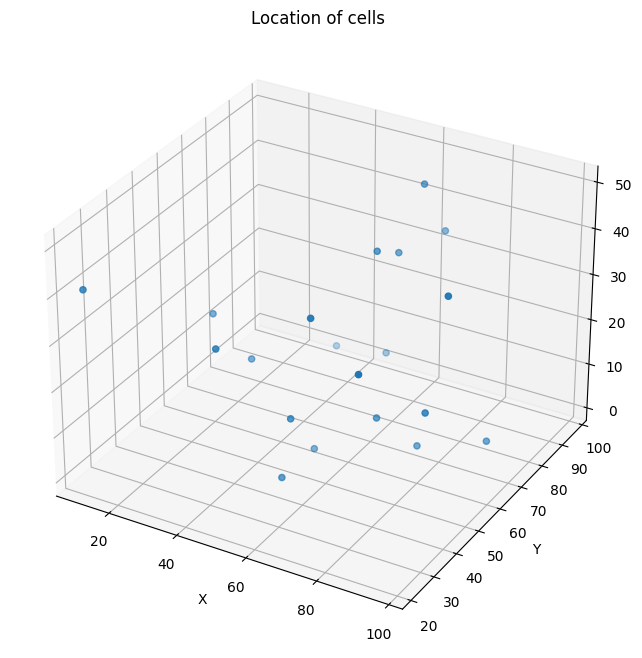

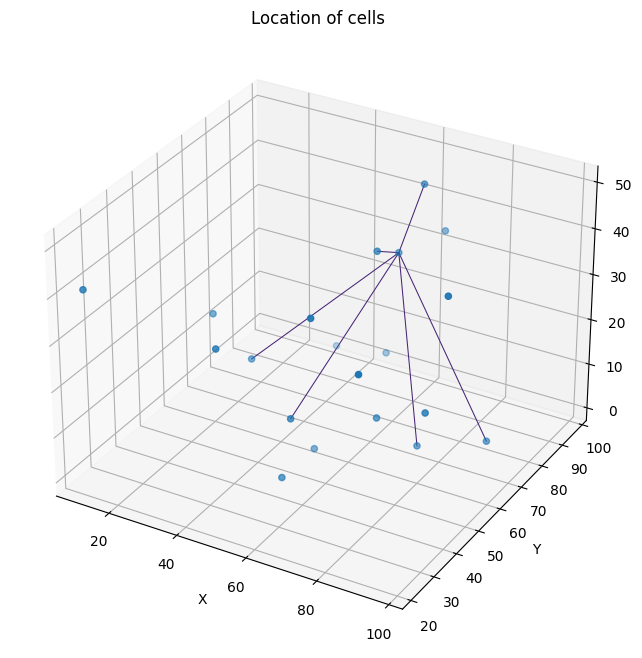

In [4]:
LIF = LIF_Network(n_neurons=20, dimensions= [[0,100],[0,100],[0,50]])
LIF.p_conn = .4
LIF.random_conn()
plot_structure(LIF, conn = False)
plot_structure(LIF, conn = True, conn_target = [2])

The connectivity can either be random, or determined by a function that is more likely to connect locally and less likely to connect distally, which is an inherent function of the LIF class named structured_conn(). 


In [ ]:
np.random.seed(6)
LIF = LIF_Network(n_neurons=150, dimensions= [[0,100],[0,1],[0,1]])
LIF.p_conn = .1
d = LIF.structured_conn(LIF)
plot_structure(LIF, conn = True, conn_target = [0, 75])


data = d.flatten()
data = data[~np.isnan(data)]

print("The observed connectivity probability is: " + str(len(data)/(LIF.n_neurons**2)))

fig, ax = plt.subplots(figsize =(10, 7))
binwidth = 5
ax.hist(d.flatten(), bins=range(int(min(data)), int(max(data) + binwidth), binwidth), density= True)
plt.xlabel('connection distance')
plt.ylabel('probability of connections')
plt.title('example structured connectivity histogram')
plt.gcf().set_size_inches(figure_size[0], figure_size[1])
plt.show()

A matrix description of the connectivity can be plotted by calling plot_connectivity().

In [ ]:
plot_connectivity(LIF)

The simulation can run for an alloted period of time using LIF.simulate(). Here, we run the simulation for 100 milliseconds and plot the voltages for 10 of the neurons with plot_voltage(). Not that if you repeat this process, that time continues from the end of the last simulation.

In [ ]:
LIF = LIF_Network(n_neurons=150, dimensions= [[0,100],[0,1],[0,1]])
LIF.p_conn = .5

simulation_results = LIF.simulate(timesteps = 100)
plot_voltage(simulation_results, n = 10)

simulation_results = LIF.simulate(timesteps = 150)
plot_voltage(simulation_results, n = 10)

You can also view the spike train by calling the internal function LIF.spikeTrain().

In [ ]:
h = LIF.simulate(timesteps = 2000)
st1 = LIF.spikeTrain(lookBack=2000,nNeurons=1)
st2 = LIF.spikeTrain(lookBack=2000,nNeurons=10)

print(st2)

You can observe the degree of synchrony in the network using Kuramato's method, which is called with the internal class function kuramato(). Below shows the change in synchrony as the network weights increase across 5000 milliseconds. The network is completely disconnected at the 5000 ms mark and the order paramter decreases afterwards as a result. The degree of synchrony can be observed using the Kuramato order metric, but it can also be seen in the spike train for visualization reference and validation.

In [ ]:
np.random.seed(1)
LIF = LIF_Network(n_neurons= 200)
LIF.p_conn = .1
LIF.random_conn()

t = []
o = []
ov = []
splits = 5
trials = 20*splits
LB = 1000
LIF.simulate(timesteps = LB)
print("Starting...")
print("Running Synchrony...")
print(" ",end = "")
print("_"*int(-1+trials/splits))
print("[", end="")
for i in range(trials):
  h = LIF.simulate(timesteps = 200/splits)
  ordv = LIF.vect_kuramato(period = 200, lookBack = LB, r_cutoff = .1)
  ord = LIF.kuramato(period = 200, lookBack = LB)
  t.append(LIF.t)
  o.append(ord)
  ov.append(ordv)
  if i%splits == 0 and i > 1:
    print("█",end="")
print("] Done!")

print("")
print("Phase ended at time: " + str(LIF.t) + " ms.")

# Reset network to 0 connectivity:
LIF.network_conn = np.zeros([LIF.n_neurons,LIF.n_neurons])  
LIF.g_poisson = 3
trials = 10*splits
print("Running desynchrony... ")
print(" ",end = "")
print("_"*int(-1+trials/splits))
print("[", end="")
for i in range(trials):
  h = LIF.simulate(timesteps = 200/splits)
  ordv = LIF.vect_kuramato(period = 200, lookBack = LB, r_cutoff = .1)
  ord = LIF.kuramato(period = 200, lookBack = LB)
  t.append(LIF.t)
  o.append(ord)
  ov.append(ordv)
  if i%splits == 0 and i > 1:
    print("█",end="")
print("] Done!")
print("Phase ended at time: " + str(LIF.t) + " ms.")

%matplotlib inline
fig = plt.figure()

plt.xlabel('time [ms]')
plt.ylabel('Kuramato order')
plt.plot(t,o)
plt.plot(t,ov,'red')
fig.set_size_inches(5, 4)
plt.show()

rr = LIF.spikeTrain(nNeurons=40,purge=False)

We can view our STDP function by running assaySTDP() on the LIF class:

In [ ]:
LIF = LIF_Network(n_neurons=10)
LIF.assaySTDP()

Let's examine a very small network so we can observe the STDP events and line them up with spiking events. This will help us verify that the learning rule is working as we expect it to:

In [ ]:
LIF = LIF_Network(n_neurons=10)
LIF.v = LIF.v * 0 - 50
LIF.v_thr[0] = -70
LIF.v_rf_thr[0] = -65

LIF.network_conn = LIF.network_conn * 0
LIF.network_W = LIF.network_W * 0
for i in range(1,4):
  LIF.network_conn[i-1][i] = 1
  LIF.network_W[i-1][i] = .5

LIF.g_poisson = 0
print(LIF)

plotter(LIF,100,pN = 4)
plotter(LIF,100,pN = 4)

Here, because we 'purged' the spike record, everything before the epoch has been forgotten. So be careful! The spike record is memory intensive, so it should be purged periodically, but you should save it somewhere. The function returns the spike record, as you can see.

Now let's see if we can observe synchrony in the spikes:

In [ ]:
LIF = LIF_Network(n_neurons=300)

h = LIF.simulate(timesteps = 2000)
[v,g,p,t,inp,dw] = h
h2 = LIF.spikeTrain(lookBack=1000,nNeurons=100,purge=False)

for i in range(15):
  h = LIF.simulate(timesteps = 2000)
  [v,g,p,t,inp,dw] = h
  h2 = LIF.spikeTrain(lookBack=1000,nNeurons=100,purge=False)
  LIF.kuramato()
  

Great!

That seems reasonable. Now lets see what happens when when the first neuron is weakly connected to all other neurons. It should generate some negative plasticity because it is constatly firing without causing spikes in the post-synaptic cells:

In [ ]:
LIF = LIF_Network(n_neurons=10)

LIF.v = LIF.v * 0 - 50
LIF.v_thr[0] = -70
LIF.v_rf_thr[0] = -65

LIF.network_conn = LIF.network_conn * 0
LIF.network_W = LIF.network_W * 0
for i in range(1,10):
  LIF.network_conn[i-1][i] = 1
  LIF.network_conn[0][i] = 1
  LIF.network_W[i-1][i] = .5
  LIF.network_W[0][i] = .05
LIF.network_W[0][1] = .5 
LIF.network_W[0][0] = 0
LIF.g_poisson = 0
print(LIF)

plotter(LIF,1000)

We see a train of negative weight updates alligned with the firing of cell one. Let's now examine how Beta affects the learning curve, and then try out a LTP biased system vs a LTP biased system:

In [ ]:
LIF = LIF_Network(n_neurons=10)
LIF.assaySTDP()

LIF = LIF_Network(n_neurons=10)
LIF.stdp_beta = 10
LIF.assaySTDP()

LIF = LIF_Network(n_neurons=10)
LIF.stdp_beta = .5
LIF.assaySTDP()


We can see that beta affects the magnitude of LTP, so let's see what happens when beta is small:

In [ ]:
LIF = LIF_Network(n_neurons=10)
LIF.stdp_beta = .5

LIF.v = LIF.v * 0 - 50
LIF.v_thr[0] = -70
LIF.v_rf_thr[0] = -65

LIF.network_conn = LIF.network_conn * 0
LIF.network_W = LIF.network_W * 0
for i in range(1,10):
  LIF.network_conn[i-1][i] = 1
  LIF.network_conn[0][i] = 1
  LIF.network_W[i-1][i] = .5
  LIF.network_W[0][i] = .05
  
LIF.network_W[0][1] = .5 
LIF.network_W[0][0] = 0
LIF.g_poisson = 0

plotter(LIF,1000)

Even though cell one is not contributing to firing in cells 2-10, it still undergoes LTP because of the learning bias.

Now let's see what happens when beta is large, meaning that LTD is favored:

In [ ]:
LIF = LIF_Network(n_neurons=10)
LIF.stdp_beta = 10

LIF.v = LIF.v * 0 - 50
LIF.v_thr[0] = -70
LIF.v_rf_thr[0] = -65

LIF.network_conn = LIF.network_conn * 0
LIF.network_W = LIF.network_W * 0
for i in range(1,10):
  LIF.network_conn[i-1][i] = 1
  LIF.network_conn[0][i] = 1
  LIF.network_W[i-1][i] = .5
  LIF.network_W[0][i] = .05
  
LIF.network_W[0][1] = .5 
LIF.network_W[0][0] = 0
LIF.g_poisson = 0

plotter(LIF,1000)

Looks like we see a massive decrease in weights across the board, as expected.


Let's now use a more realistic network and run it for 20 seconds to see if we see an overall increase in weights.

In [ ]:
LIF = LIF_Network(n_neurons= 100)
plotter(LIF,20000)

Seems like there is an overall trend towards increased weights between connected neurons, though some weakly connected neurons seem to be eliminating their weights too.

## Bistability of neural weights and synchrony

This model shows the different results for the weights and the orders of the neurons, both in graph and matrix form. The graphs show for each pixel fo the matrix and the behavior of the network over time. The matrix shows the results after a set period of time. Each pixel represents a network being stimulated with a different frequency and number of fingers (stimulation nodes). The colormap shows either the weights or the order of the neurons in each network.

In [4]:
#@title Plotting function 2
def plotter2(LIF,time,I,pN = 5):

  LIF.simulate(timesteps = time,I=I)
  #[v,g,p,t,inp,dw] = h
  W2 = LIF.network_W

  %matplotlib inline
  fig = plt.figure()
  #for i in range(pN):
    #plt.plot(t,g[:,i]-i*50)
  #plt.xlabel('time [ms]')
  #plt.ylabel('syaptic current (offset by index)')
  #plt.title('example neural currents')
  #plt.show()

The following cell shows the results of the weight after every 2 seconds. The number of fingers is 10 and the frequency is 50. These parameters can be changed to see different results.

The results of this cell as it is are that the weights and the order increase overall logarthimically.

0


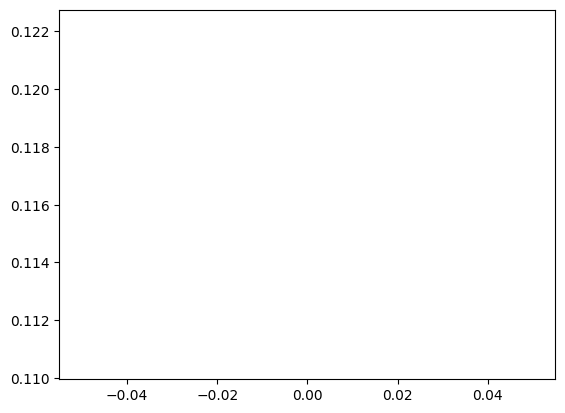

1


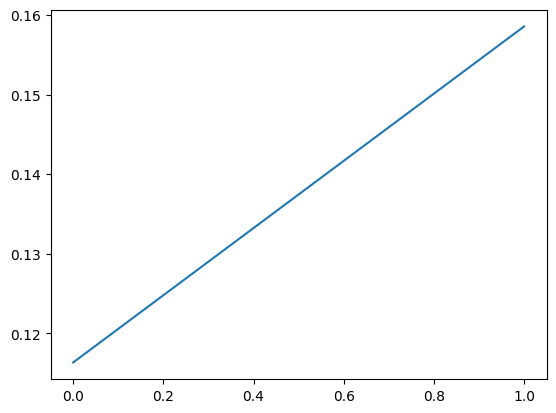

2


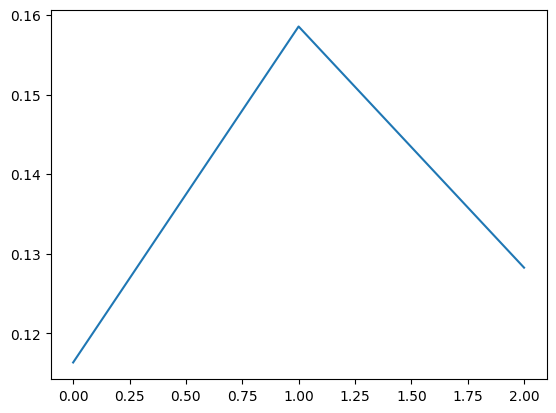

3


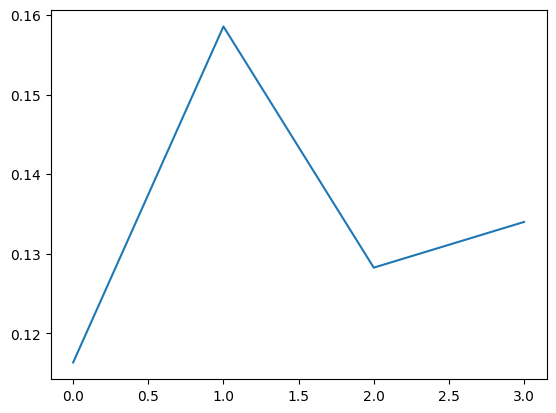

4


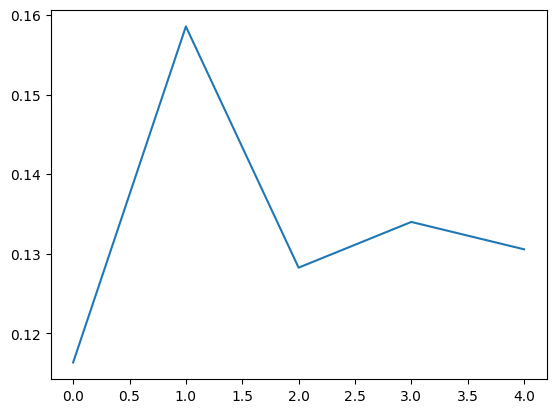

5


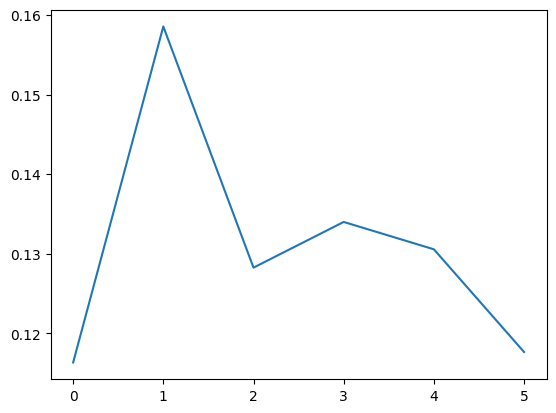

6


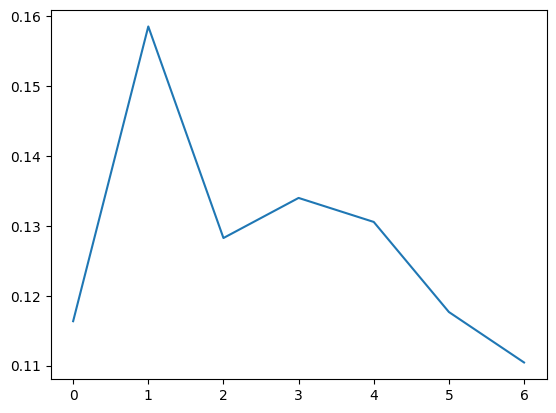

7


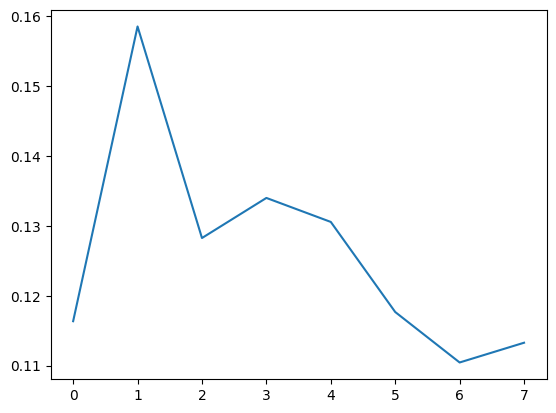

8


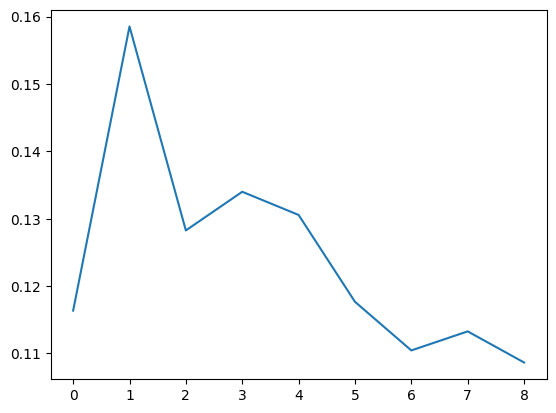

9


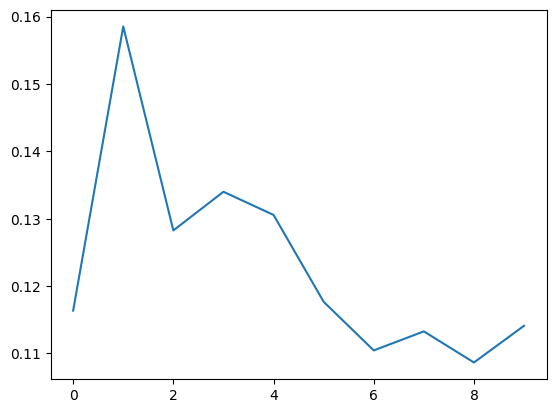

10


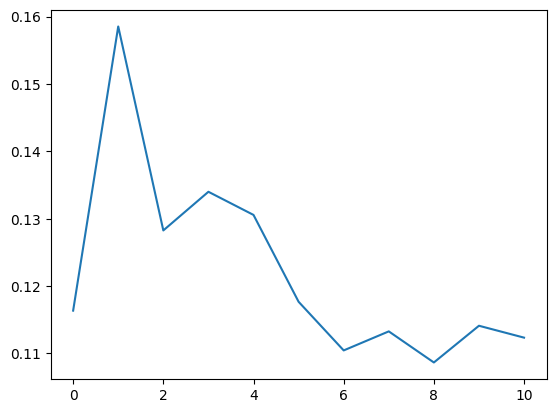

11


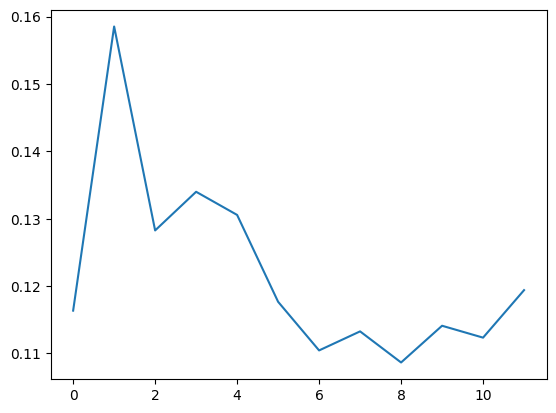

12


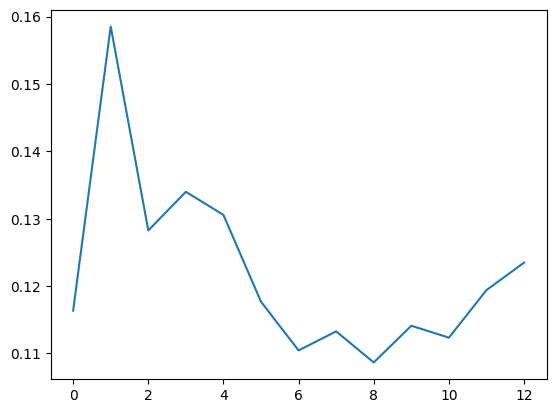

13


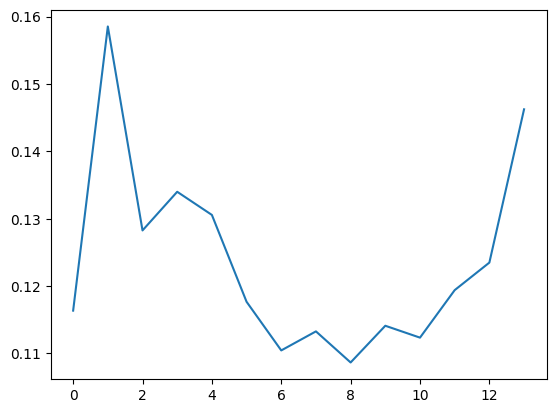

14


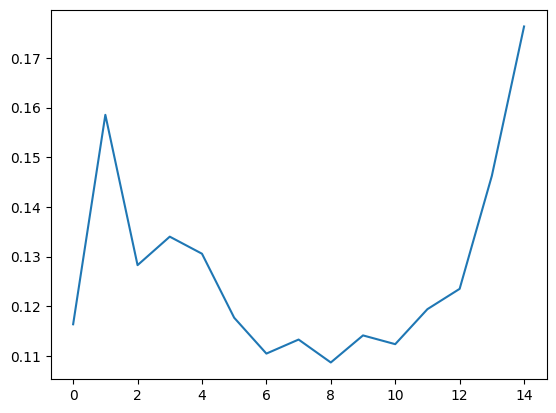

15


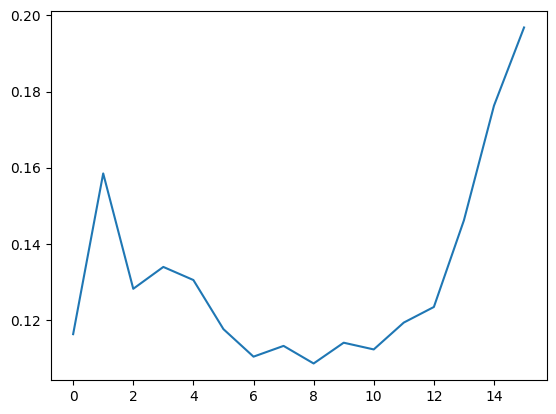

16


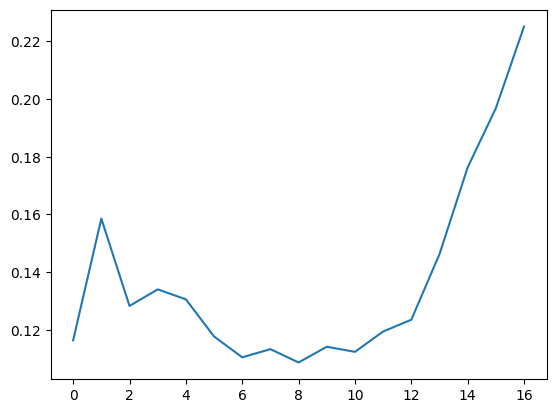

17


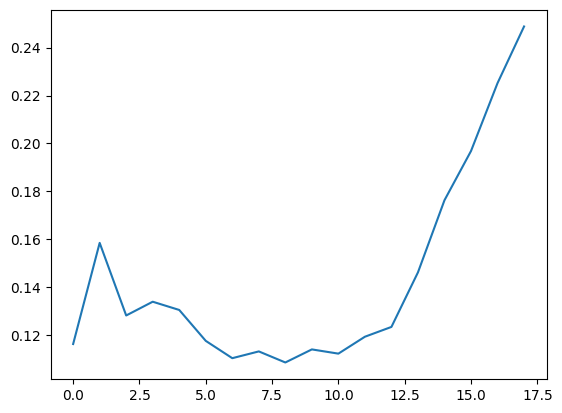

18


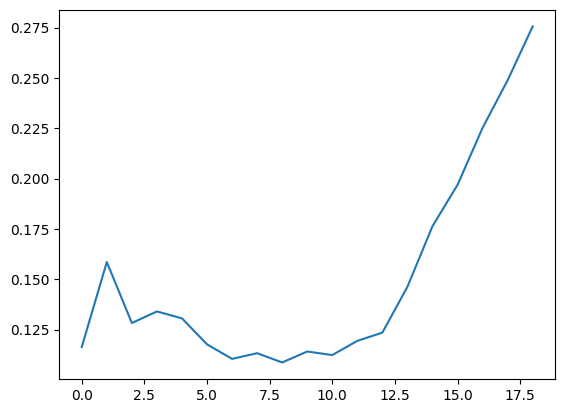

19


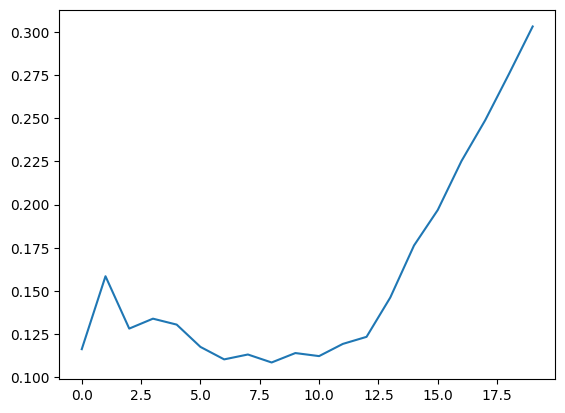

20


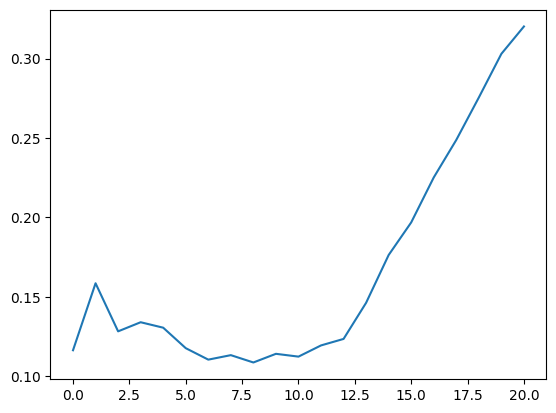

21


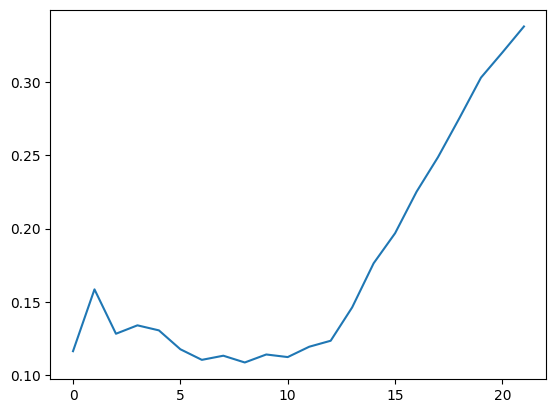

22


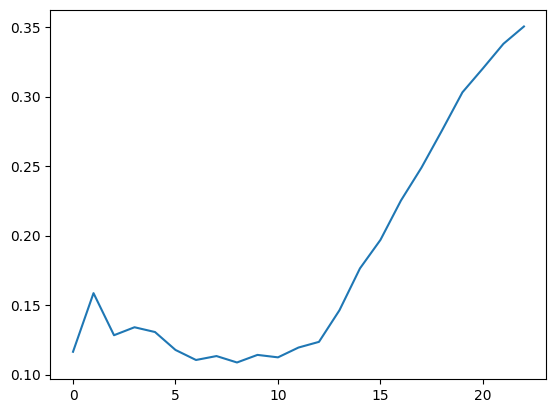

23


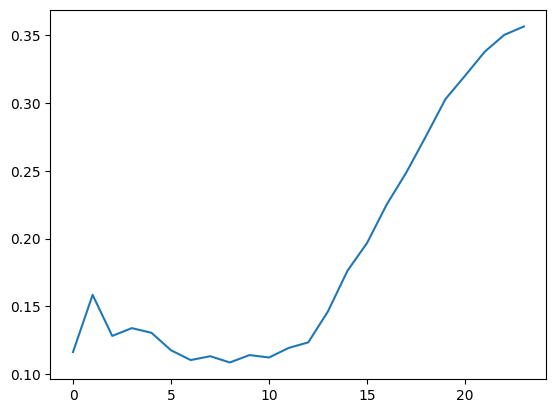

24


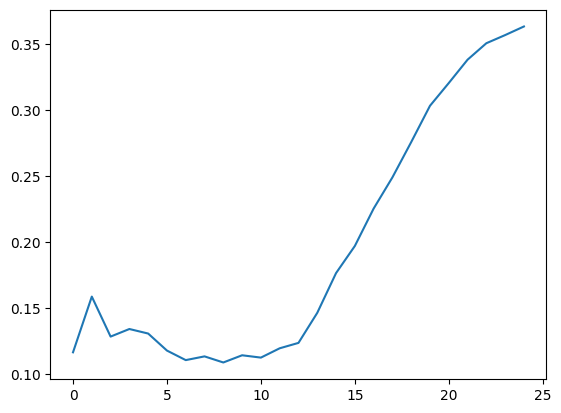

25


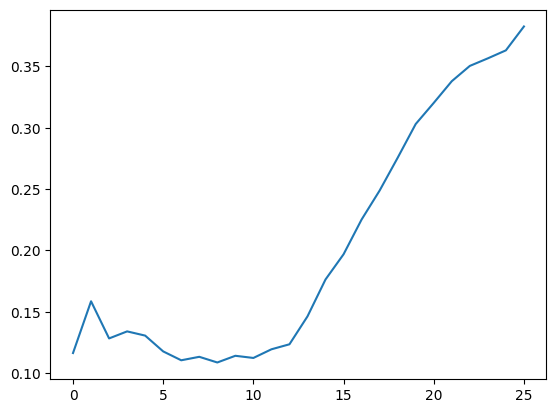

26


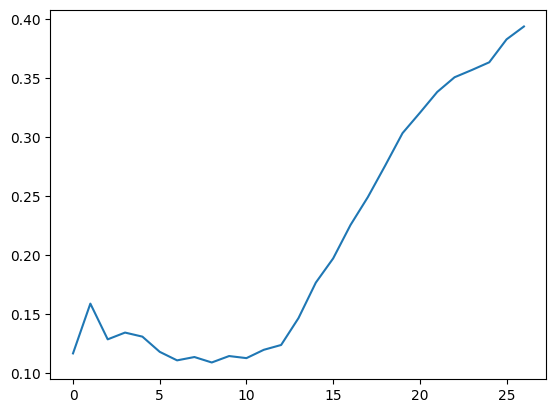

27


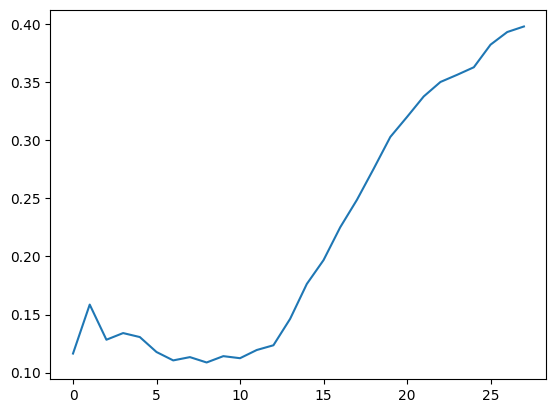

28


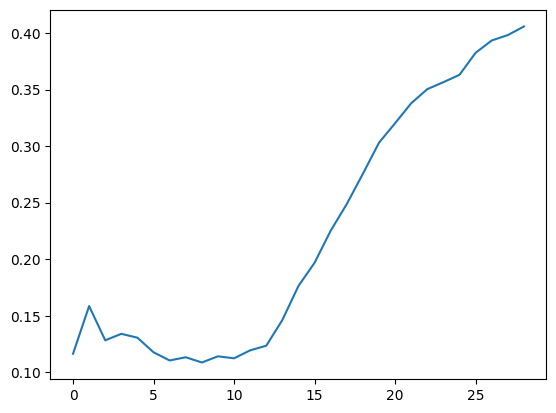

29


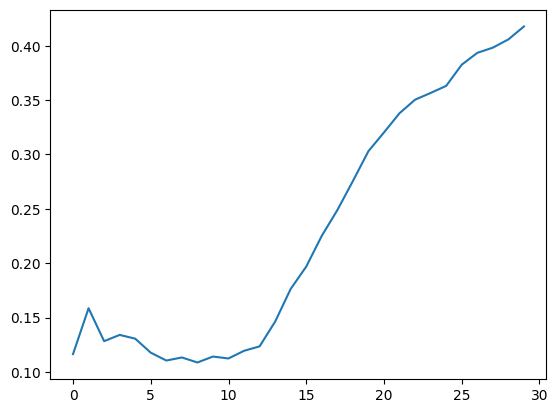

30


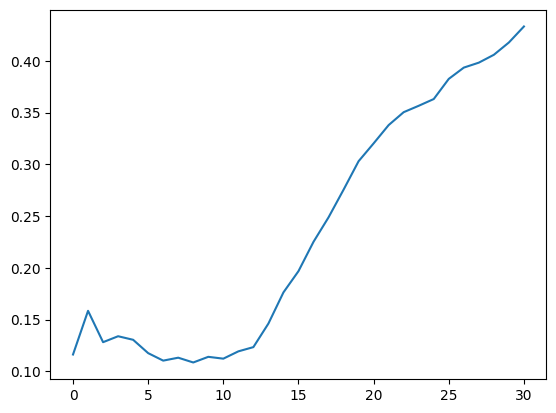

31


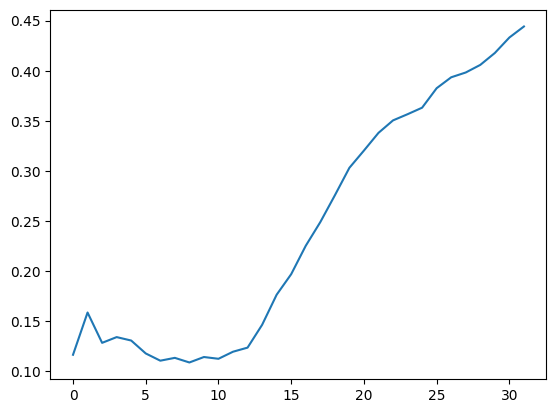

32


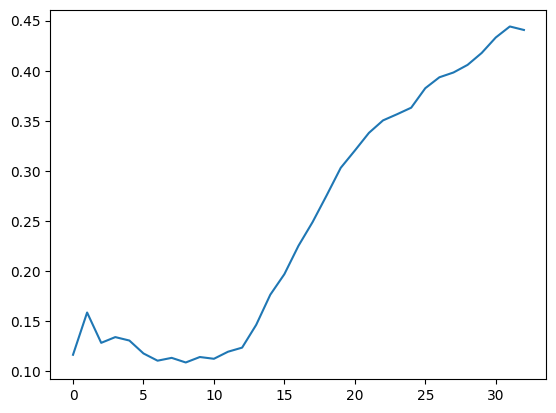

33


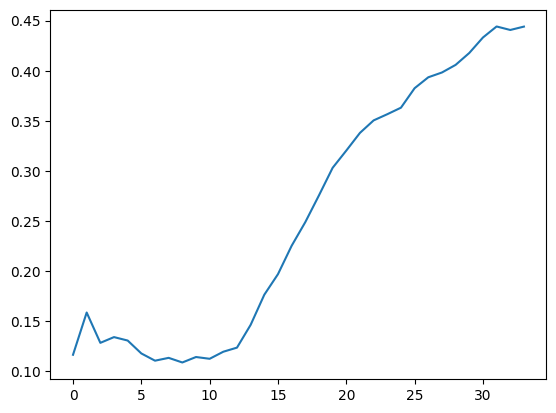

34


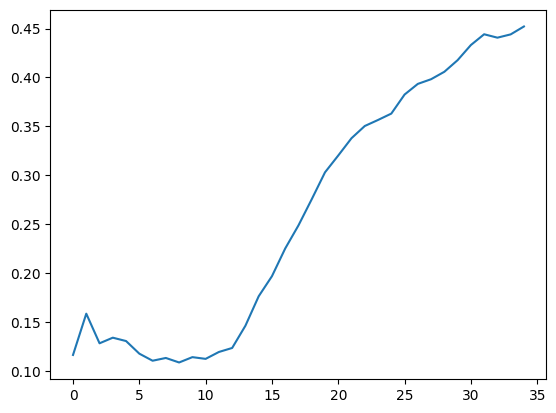

35


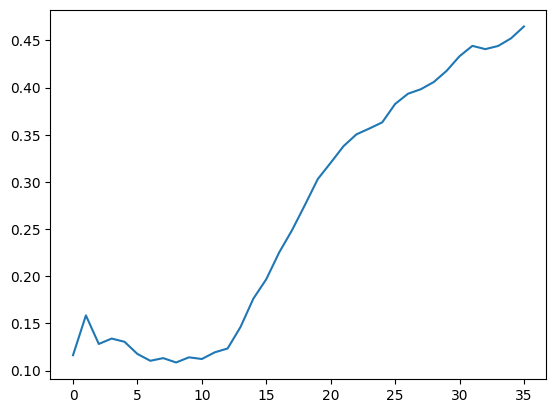

36


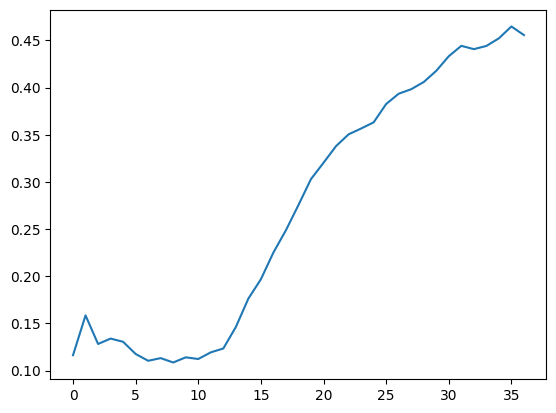

37


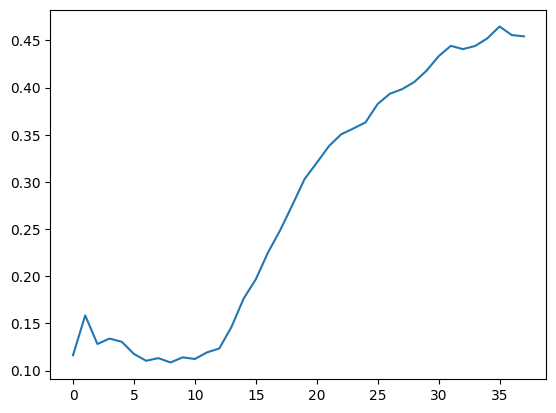

38


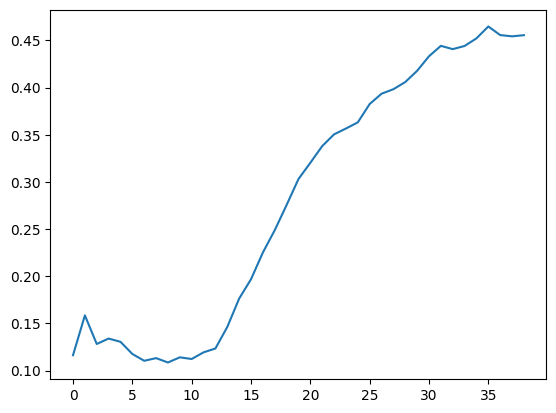

39


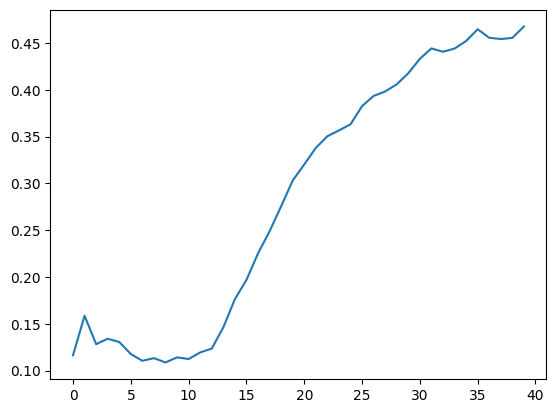

40


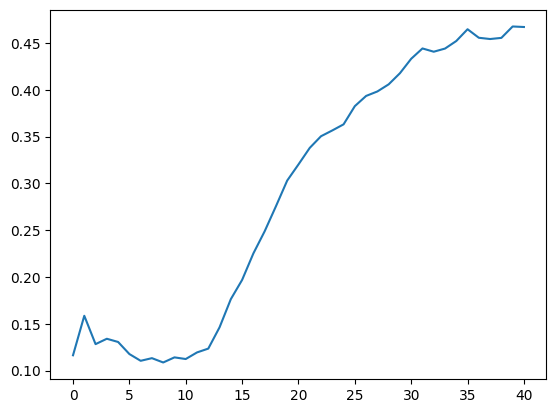

41


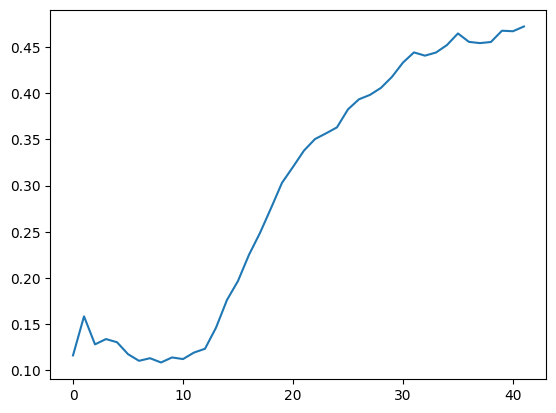

42


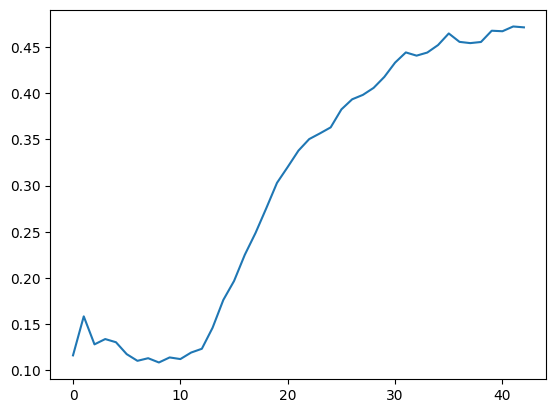

43


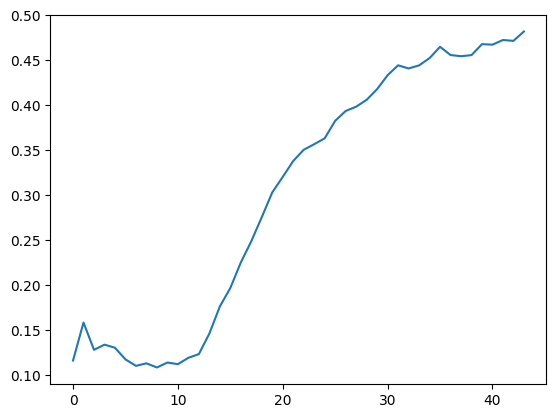

44


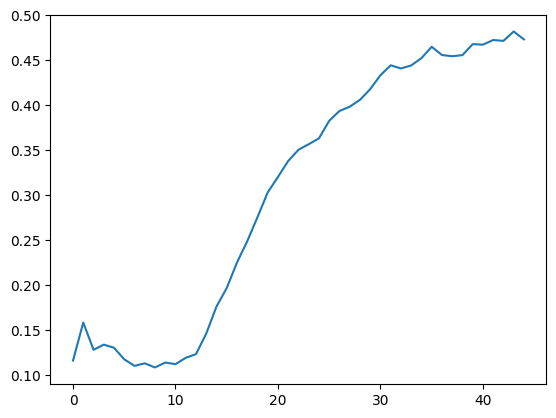

45


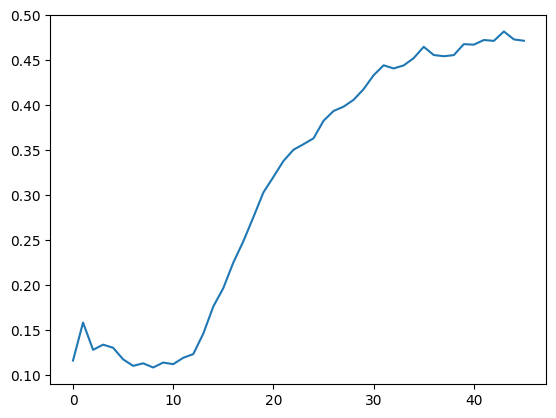

46


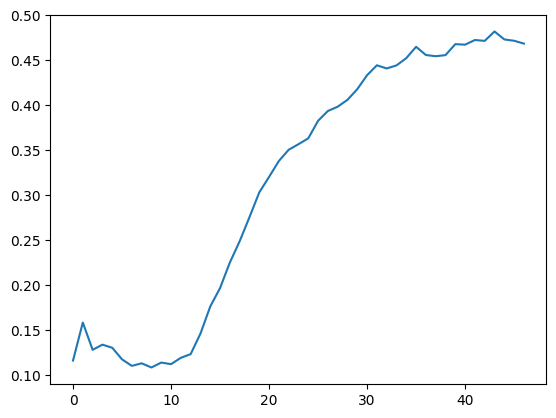

47


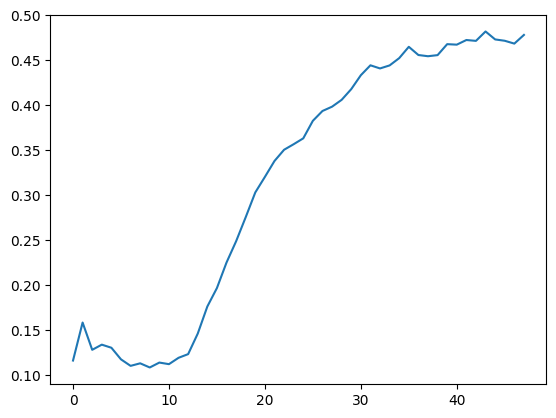

48


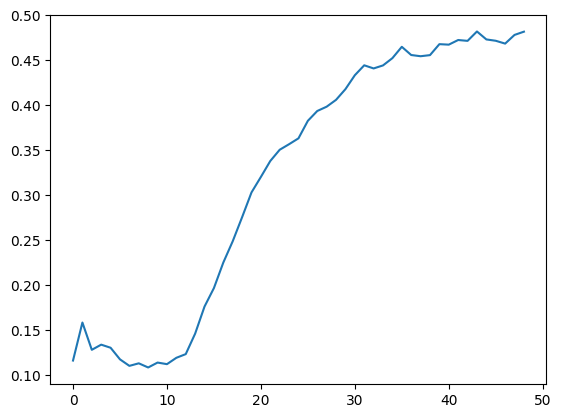

49


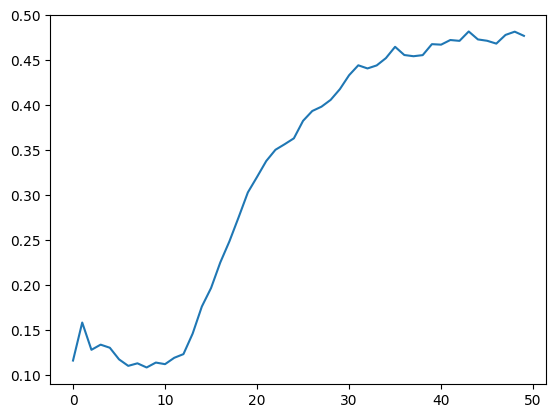

50


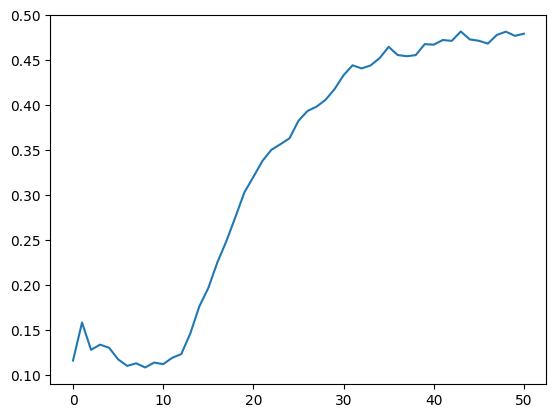

51


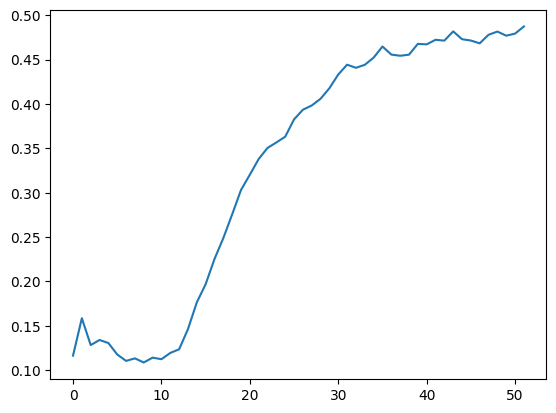

52


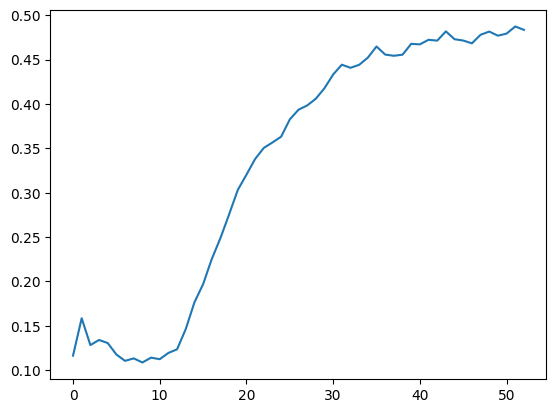

53


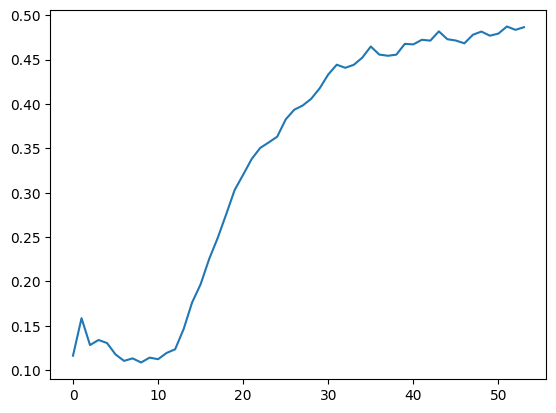

54


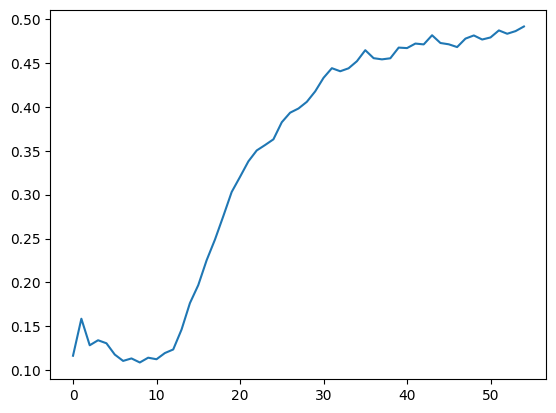

55


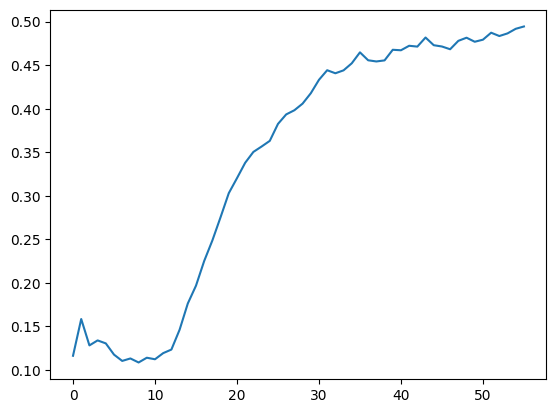

56


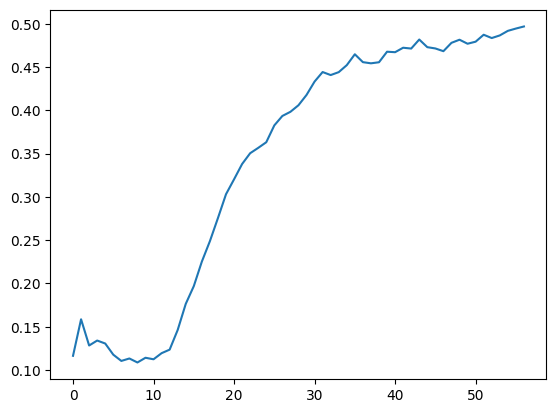

57


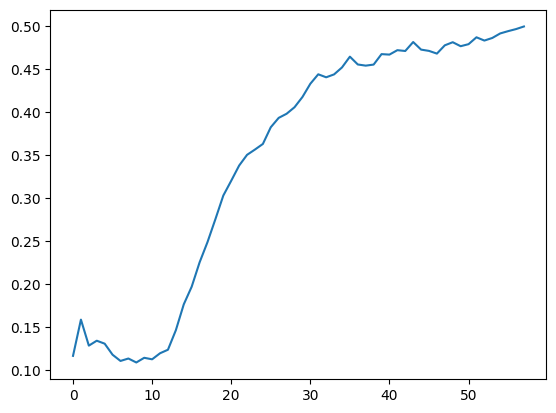

58


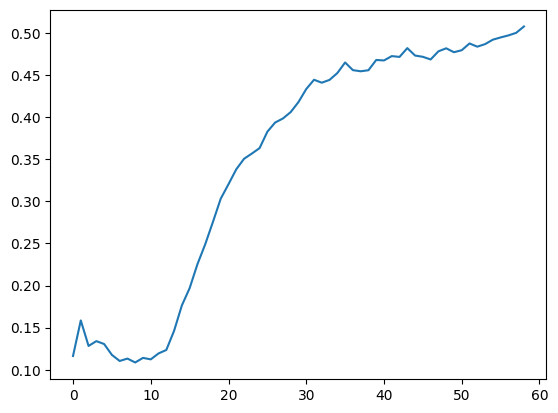

59


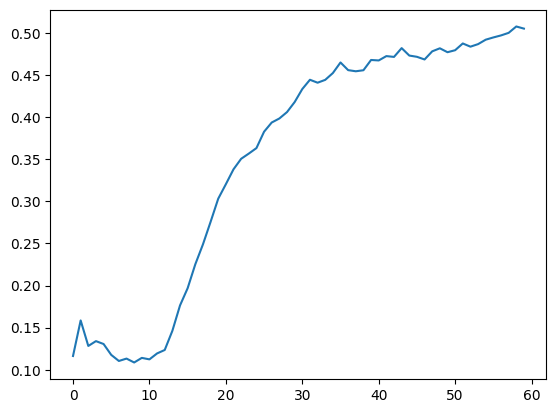

60


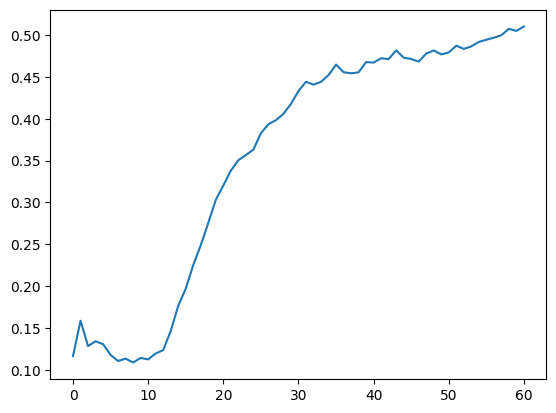

61


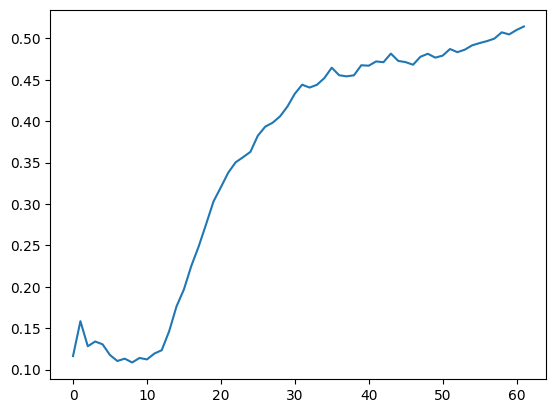

62


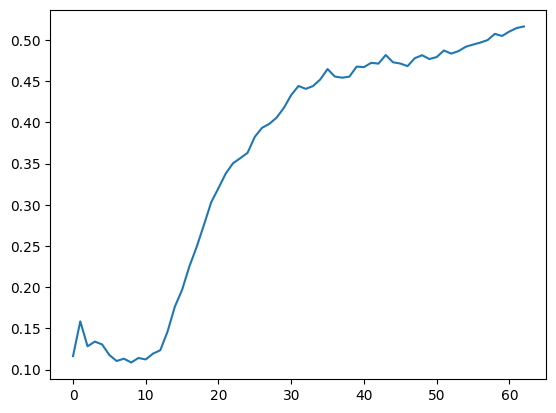

63


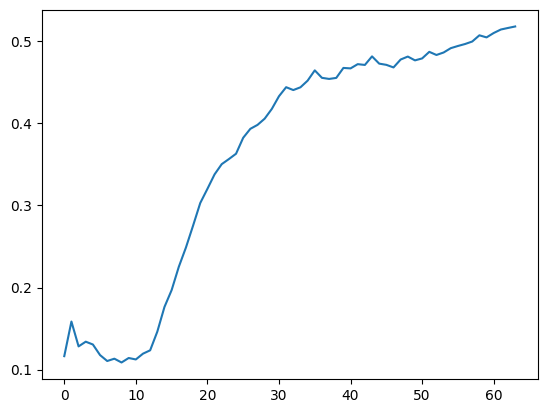

64


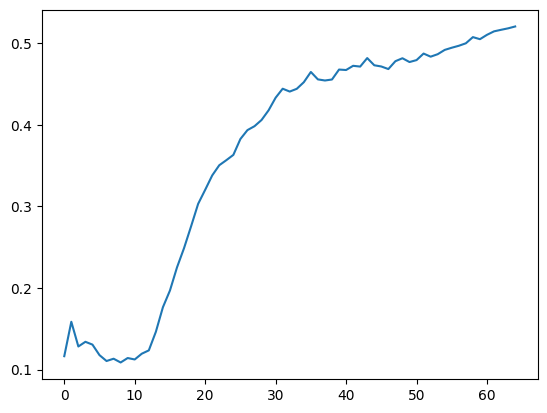

65


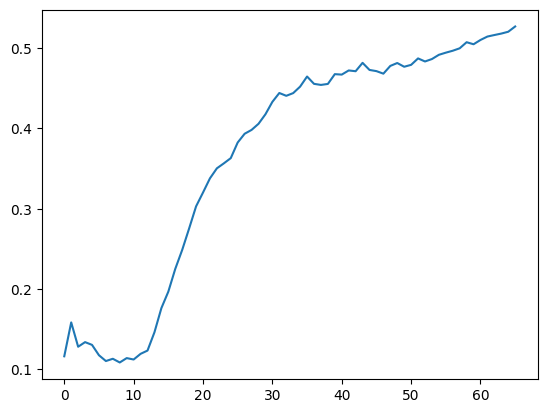

66


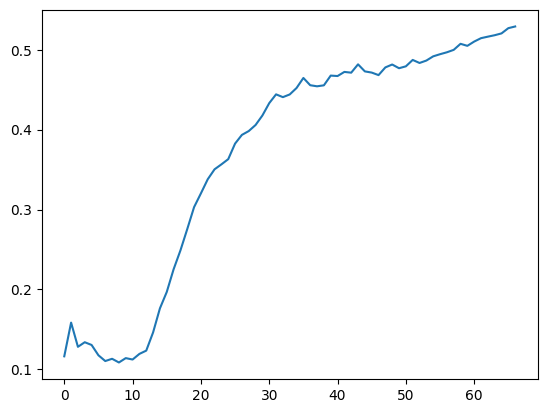

67


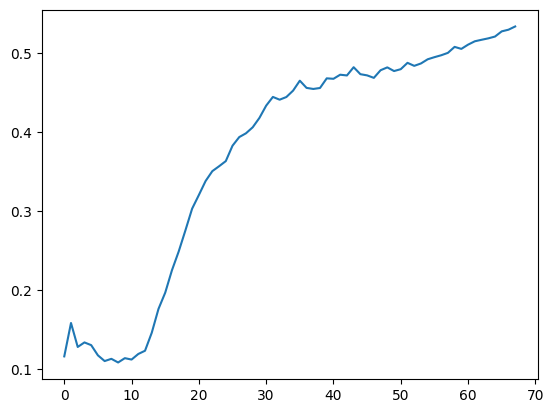

68


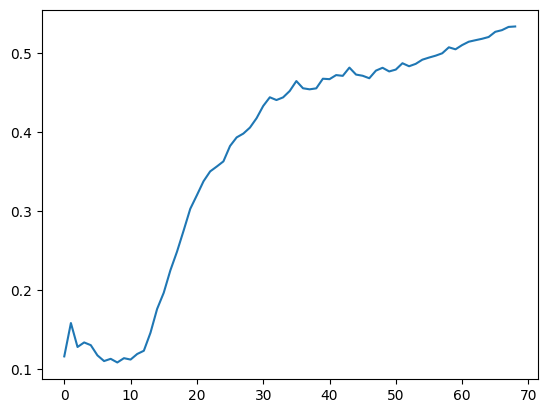

69


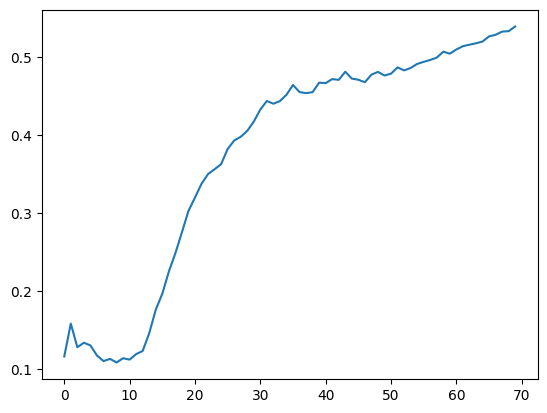

70


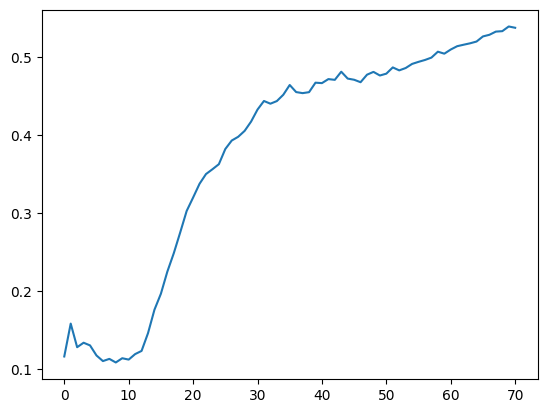

71


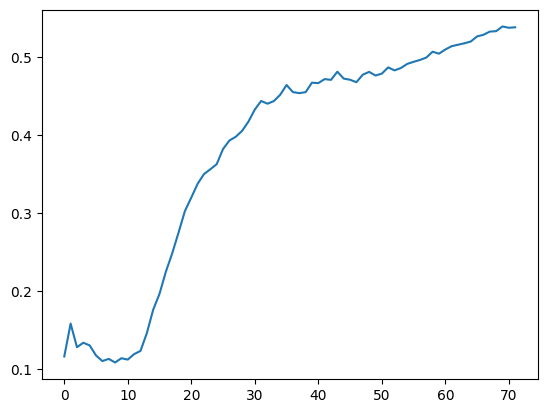

72


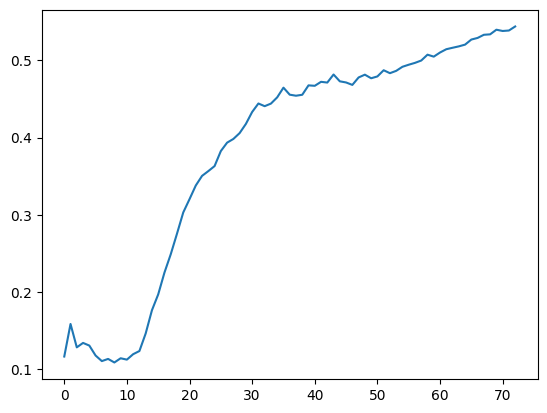

73


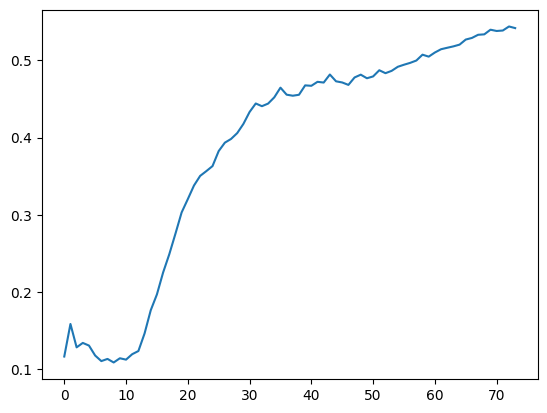

74


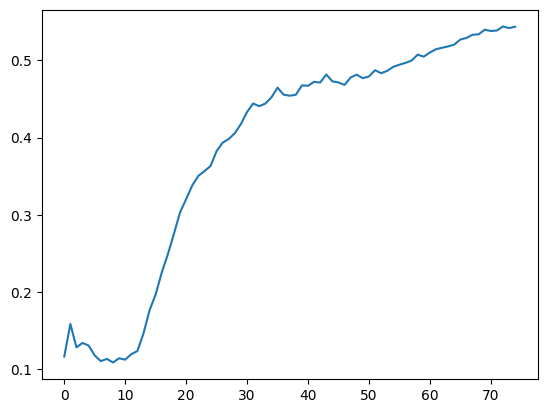

75


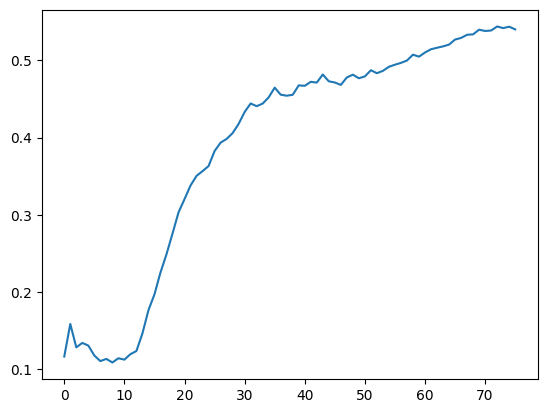

76


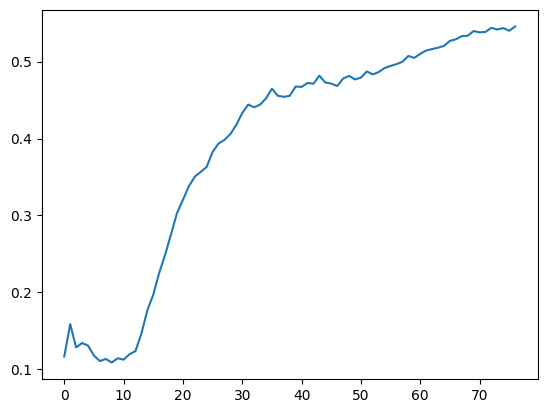

77


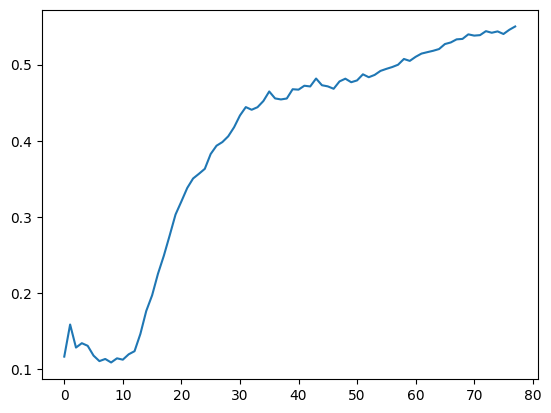

78


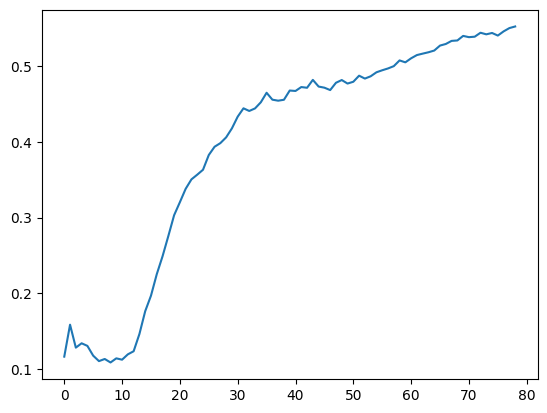

79


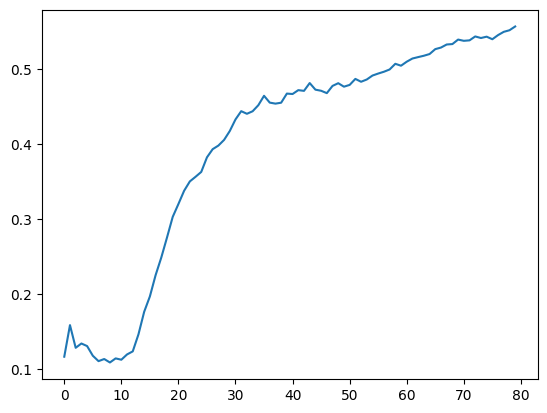

80


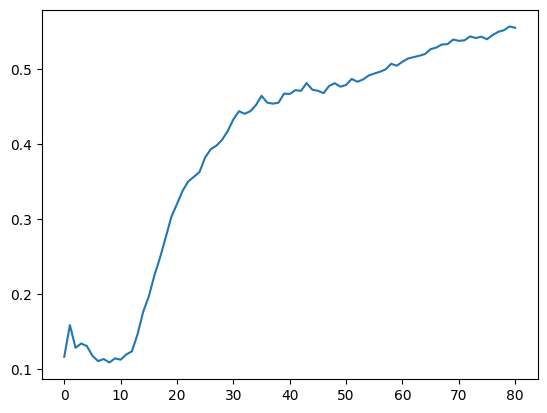

81


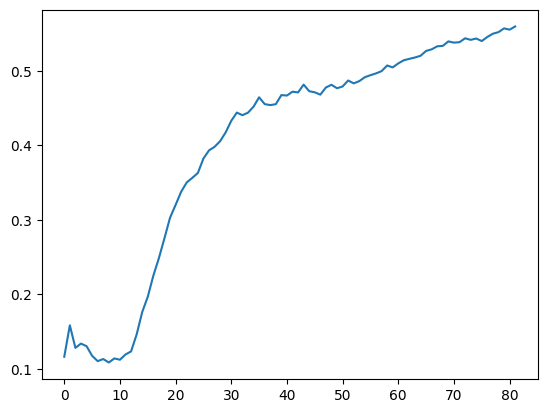

82


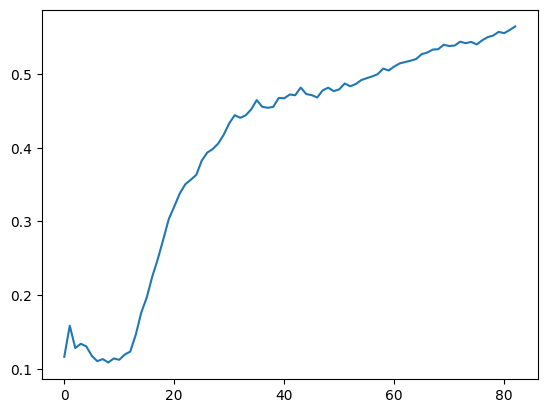

83


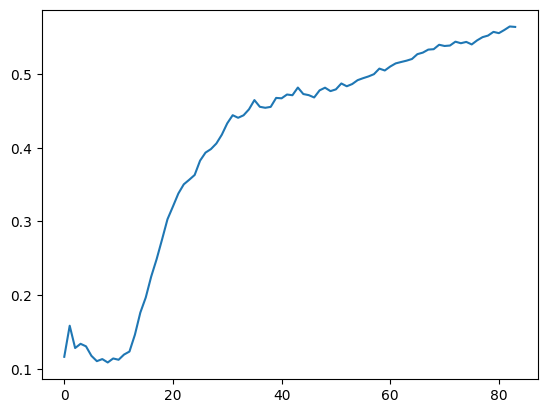

84


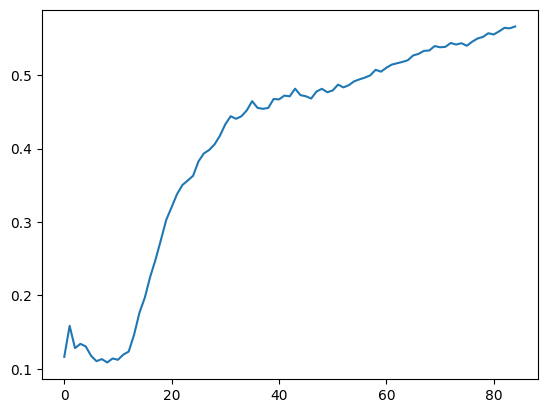

85


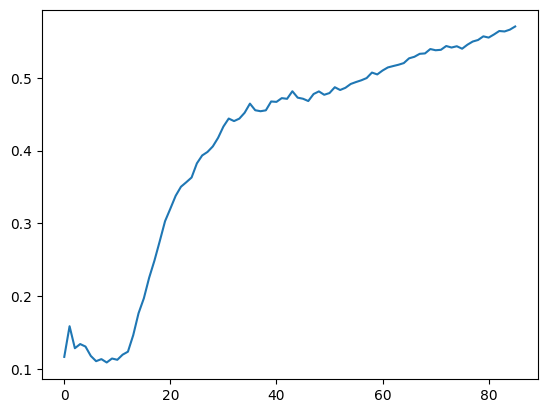

86


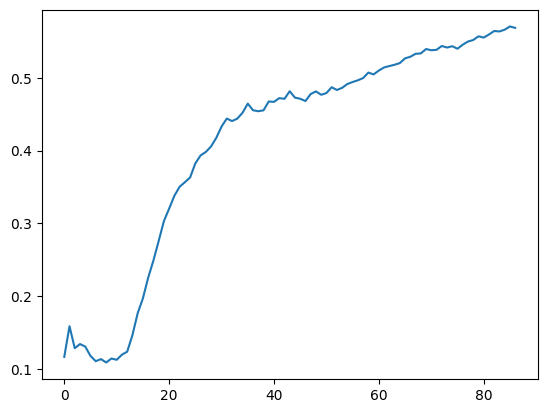

87


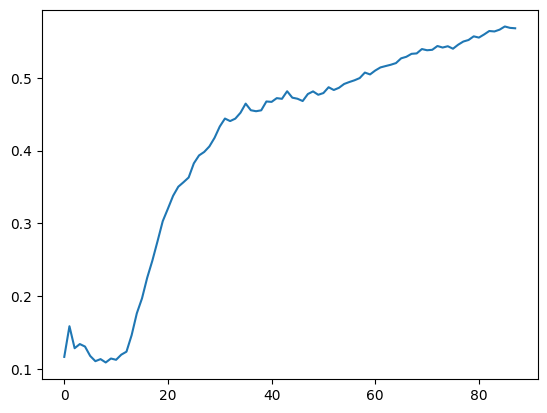

88


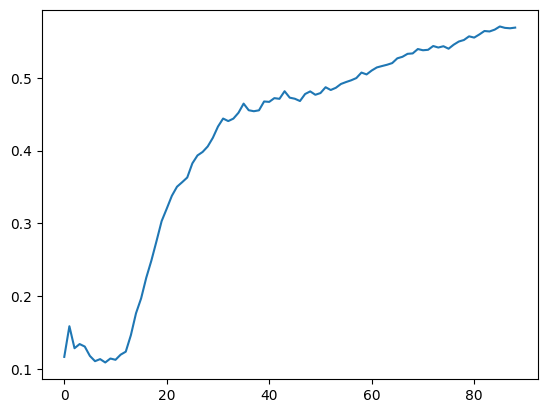

89


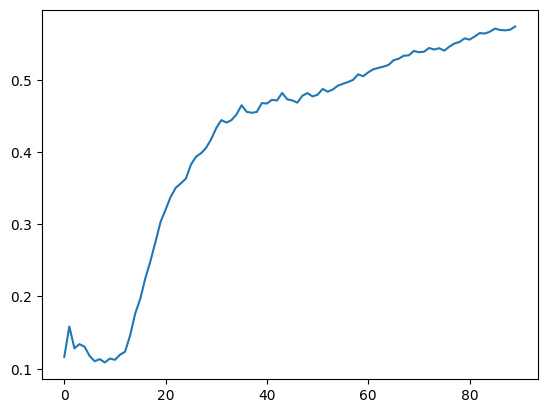

90


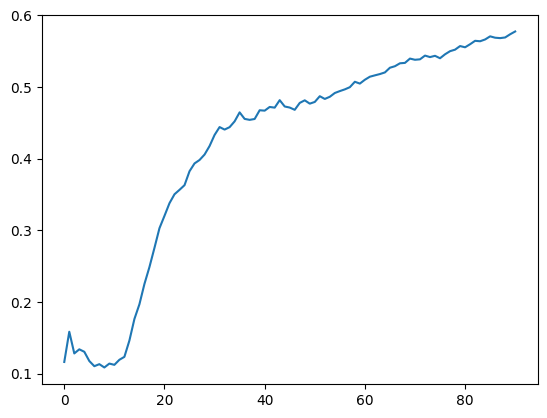

91


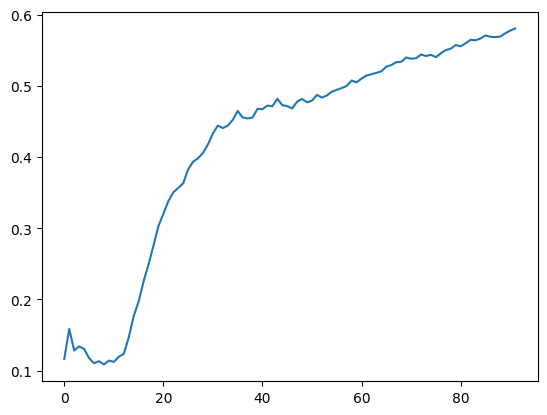

92


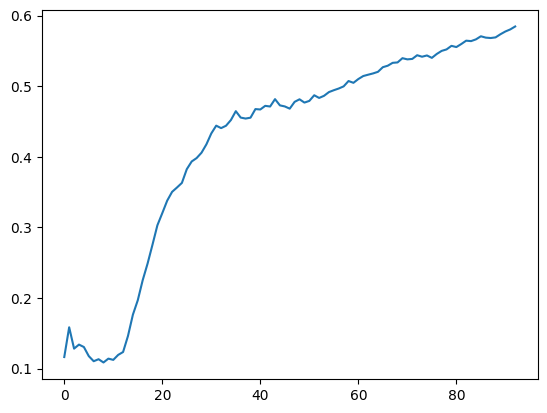

93


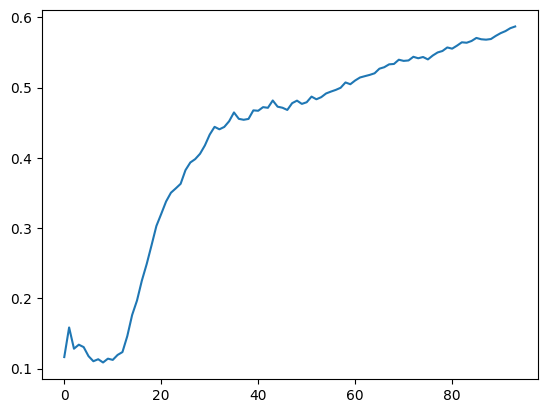

94


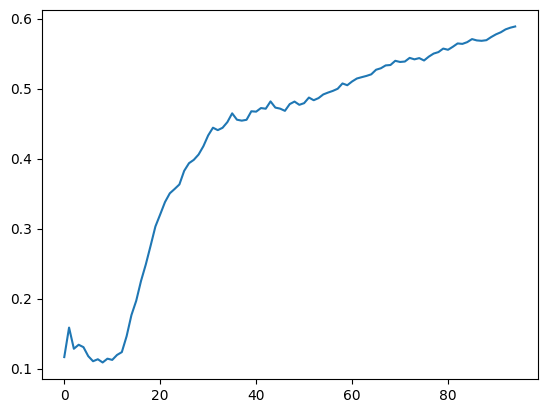

95


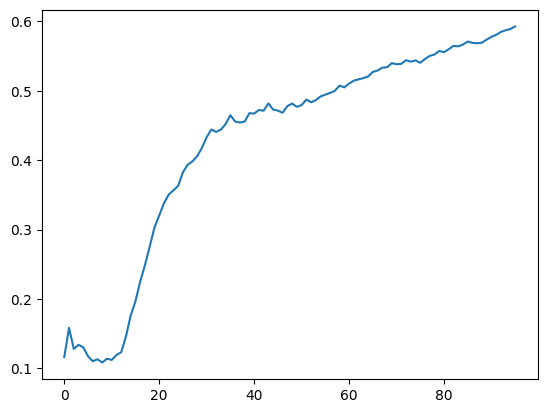

96


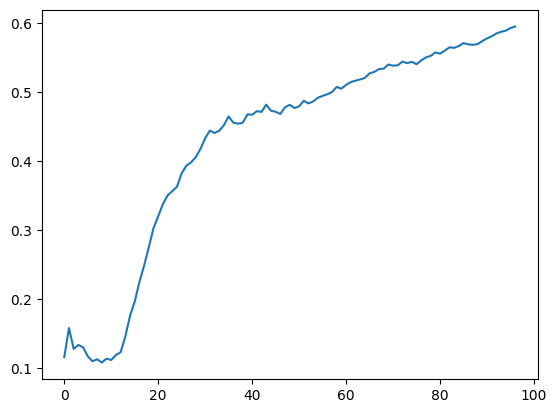

97


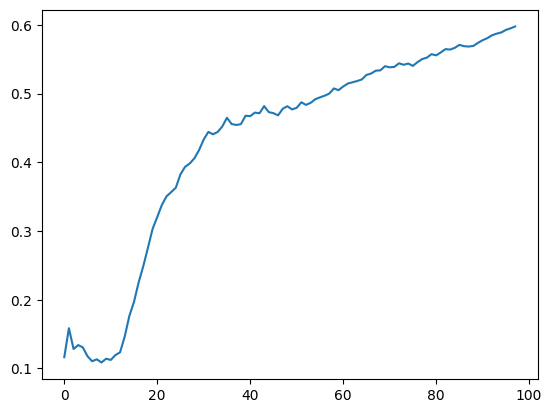

98


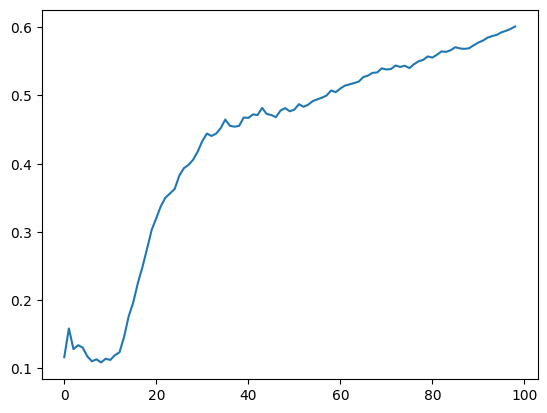

99


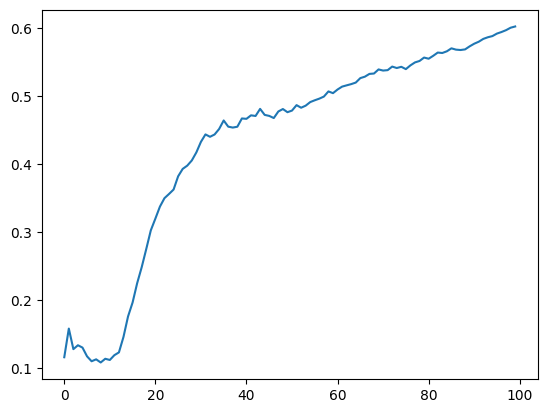

100


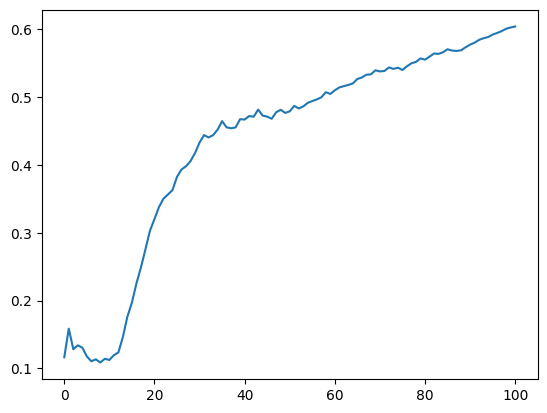

101


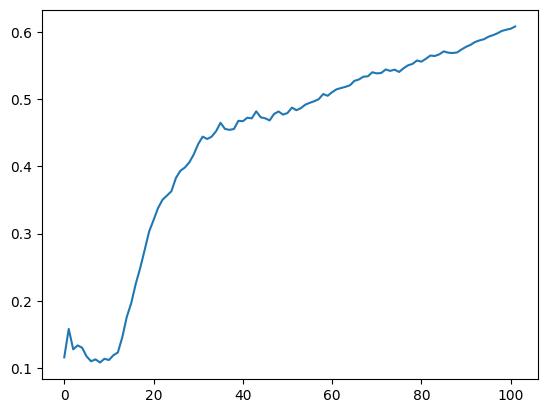

102


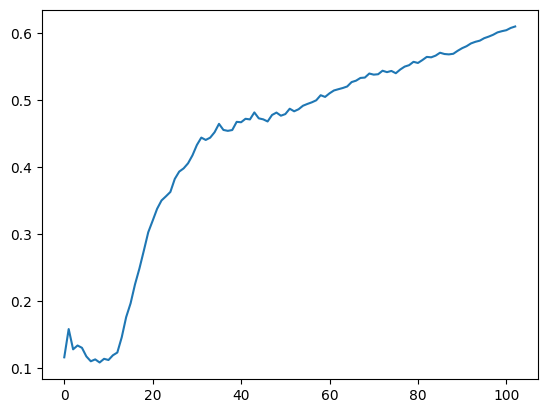

103


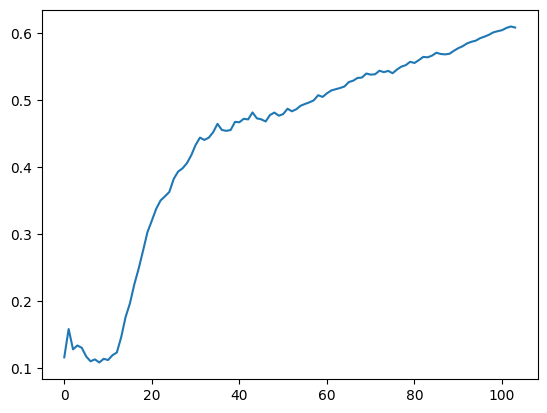

104


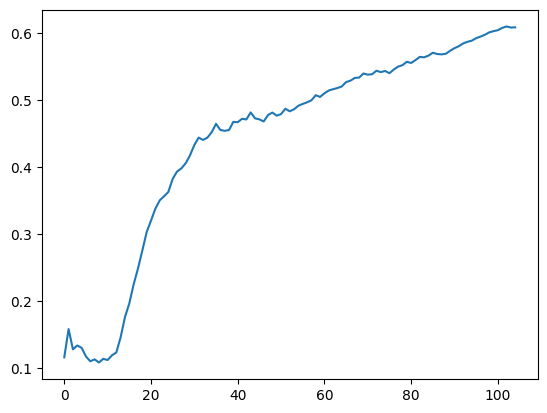

105


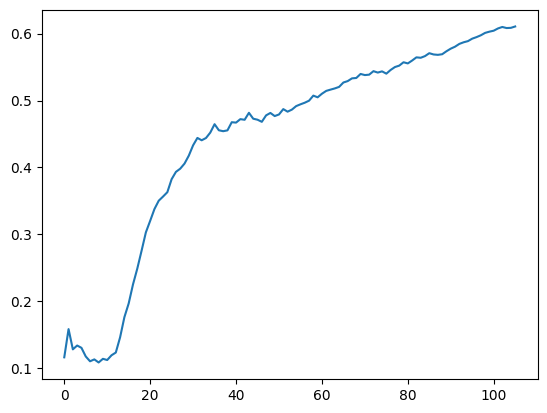

106


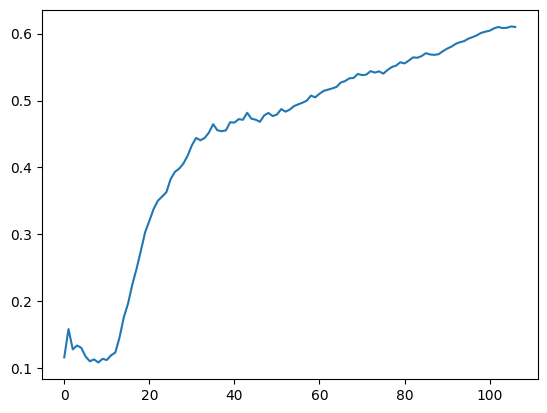

107


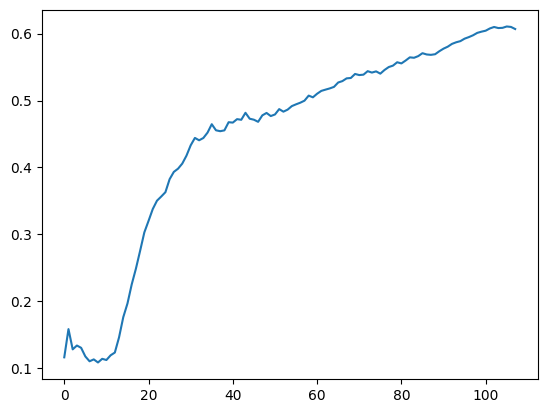

108


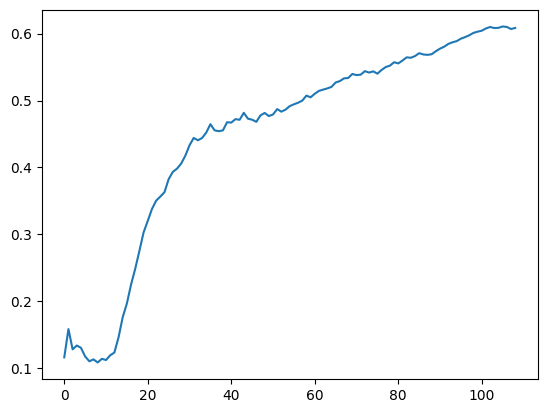

109


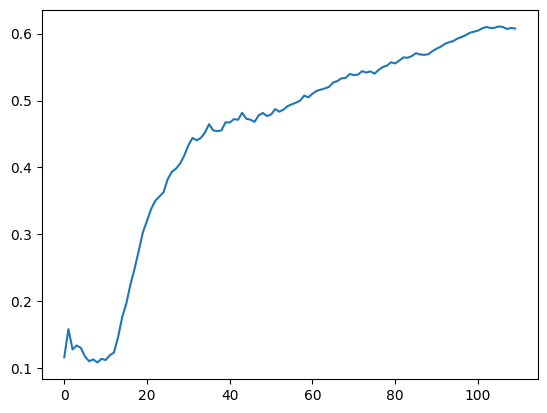

110


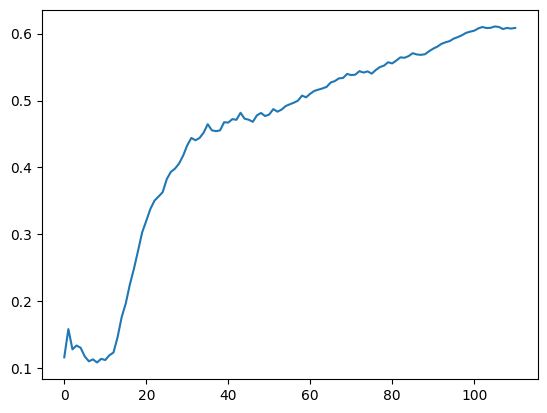

111


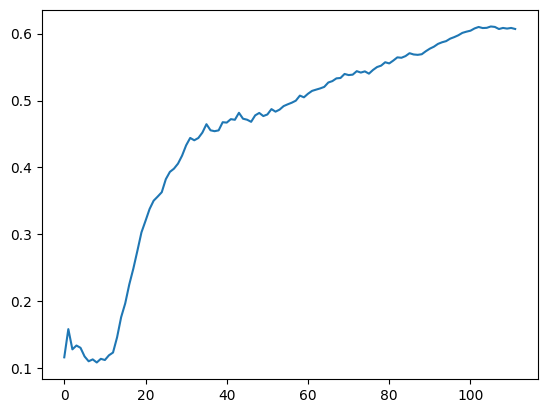

112


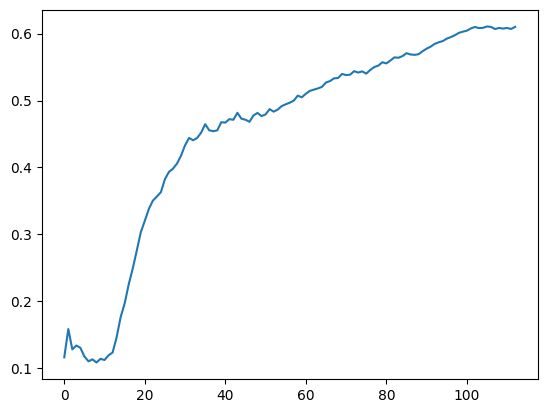

113


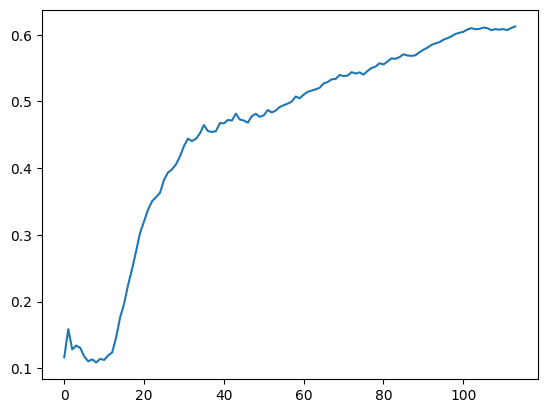

114


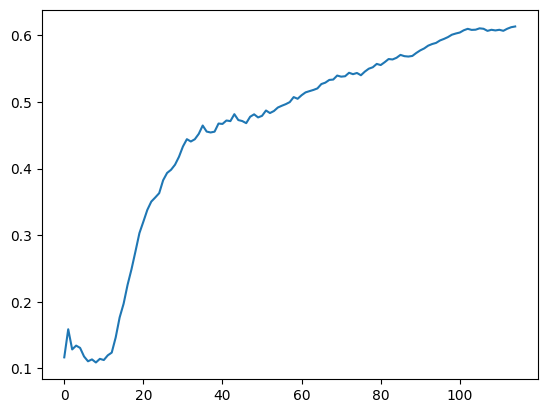

115


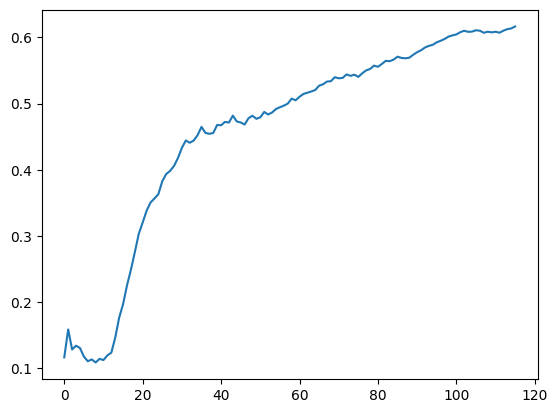

116


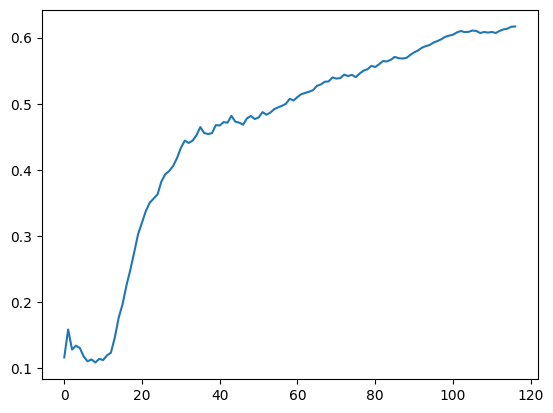

117


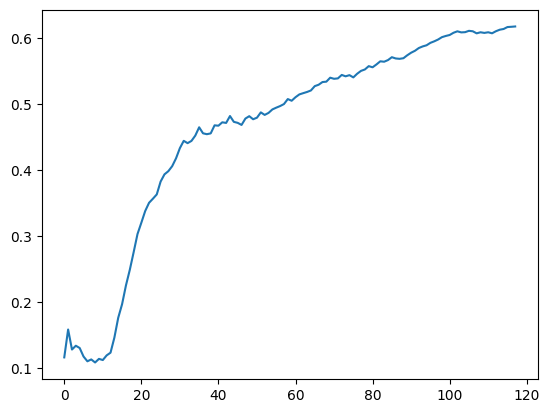

118


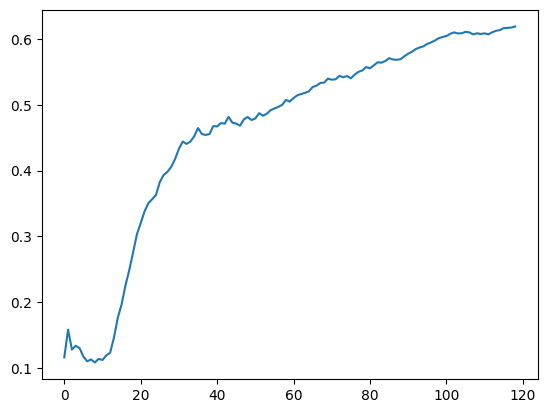

119


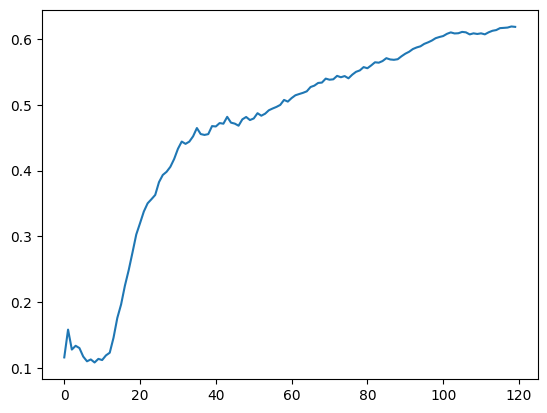

120


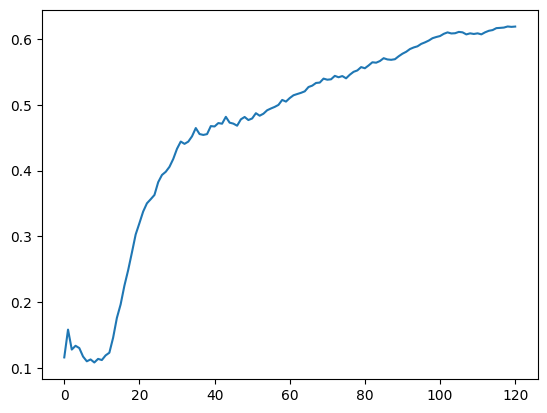

121


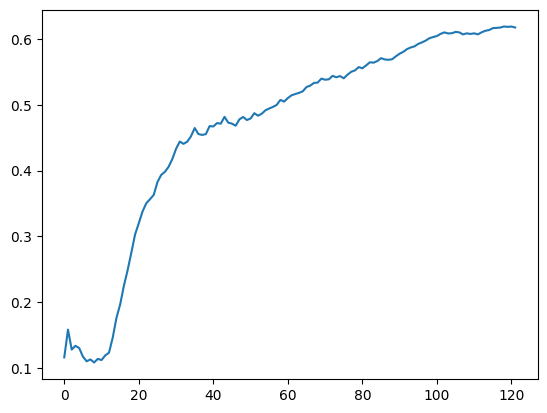

122


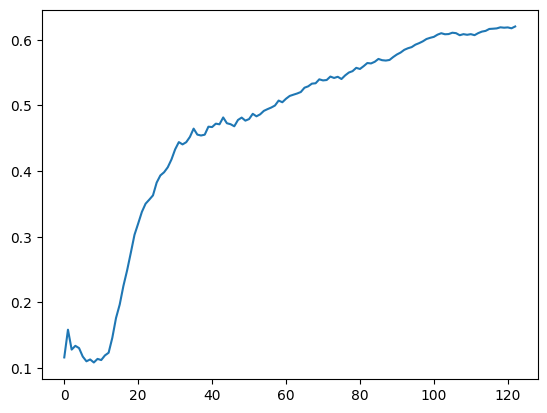

123


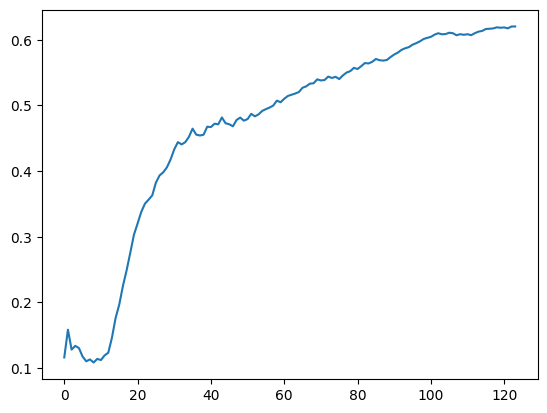

124


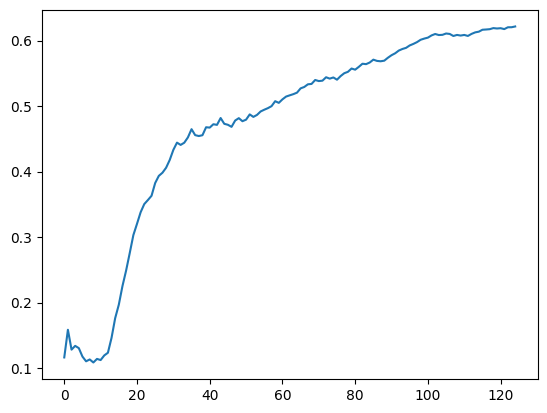

125


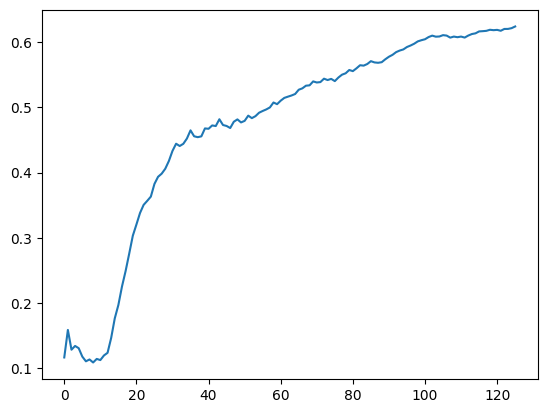

126


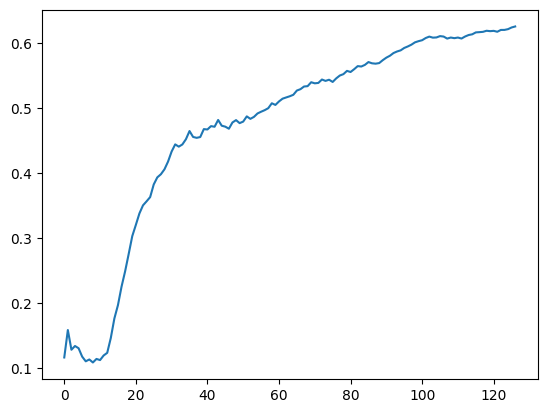

127


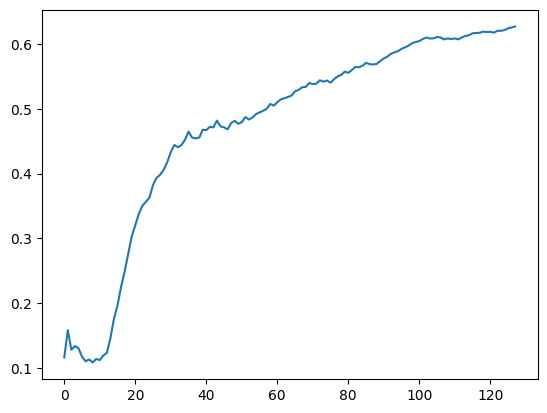

128


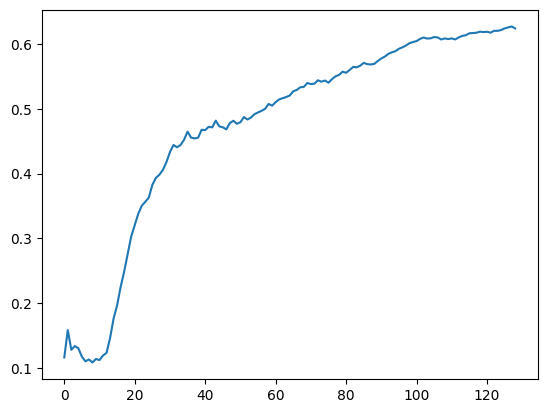

129


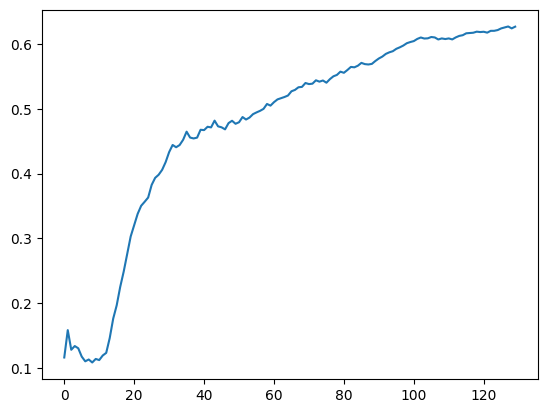

130


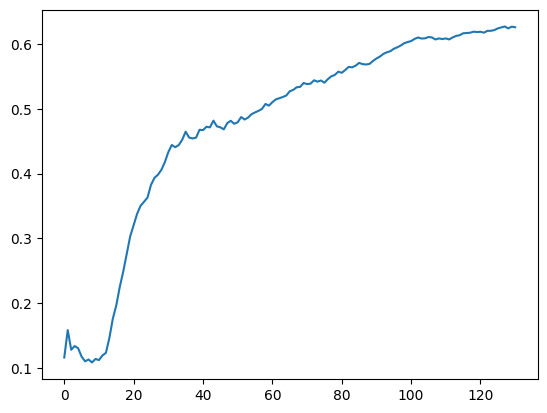

131


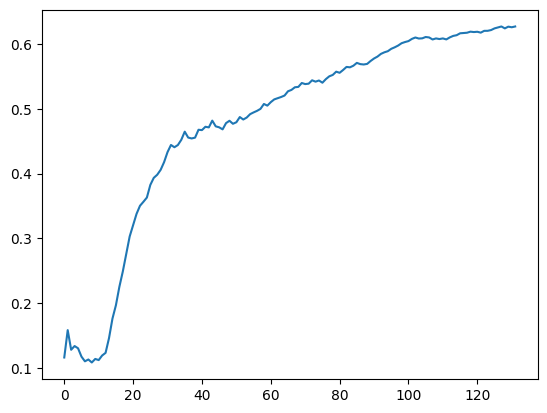

132


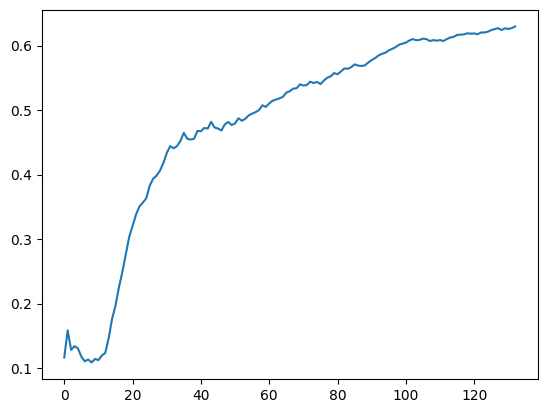

133


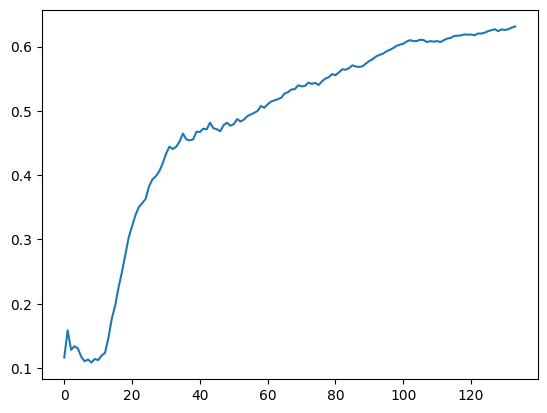

134


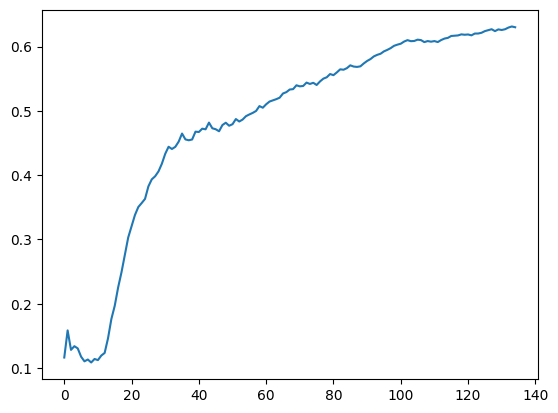

135


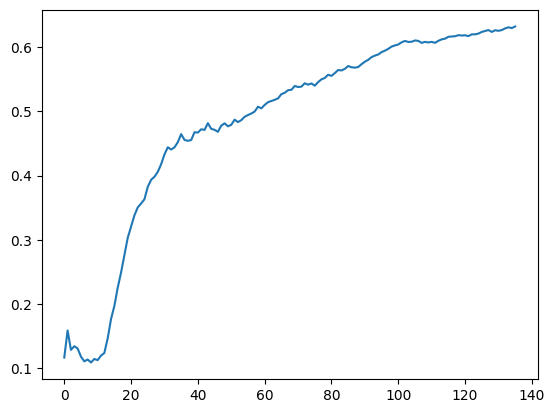

136


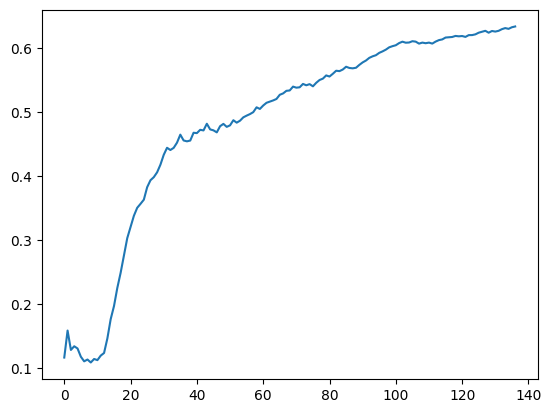

137


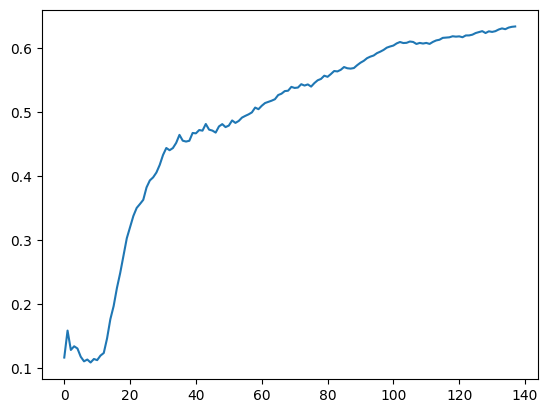

138


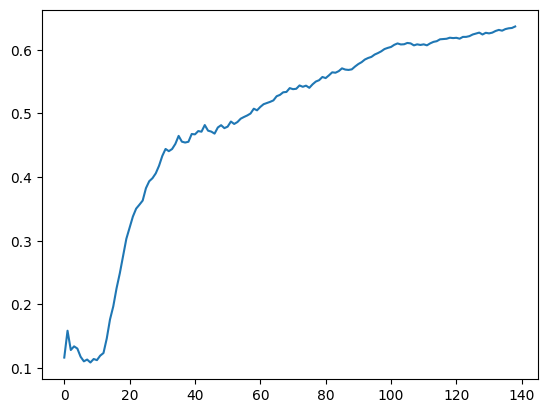

139


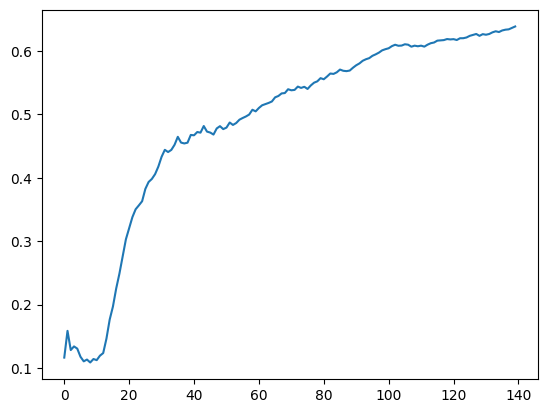

140


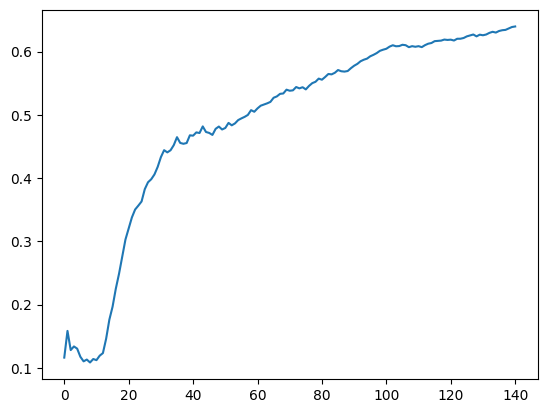

141


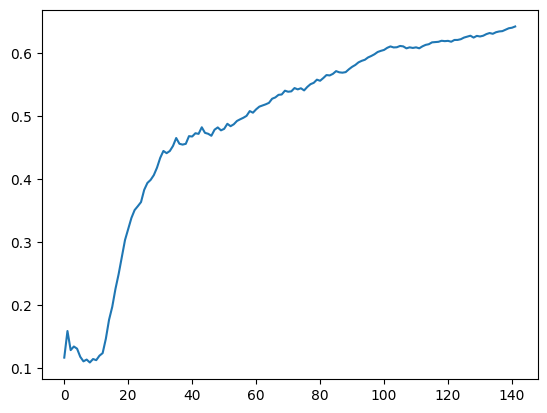

142


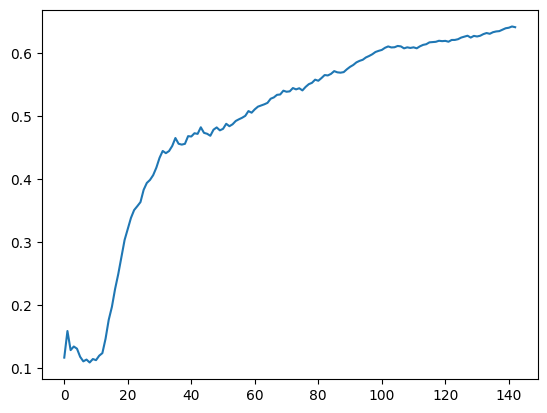

143


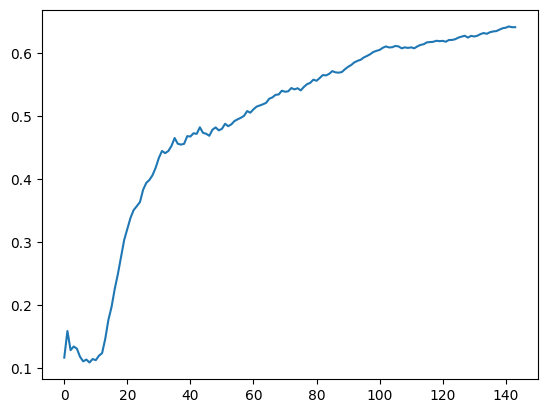

144


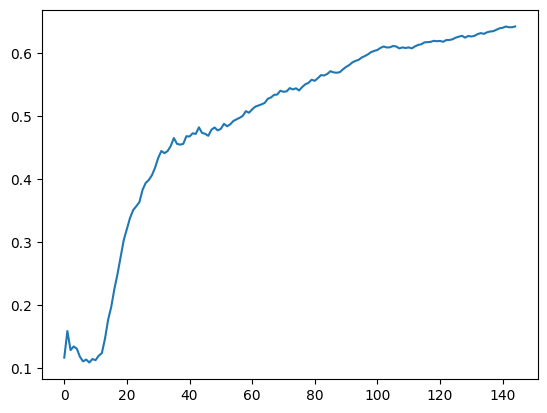

145


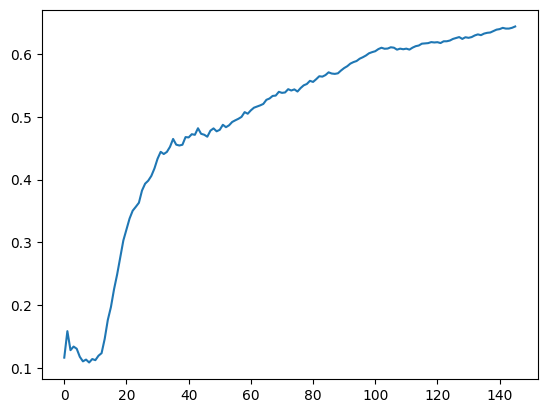

146


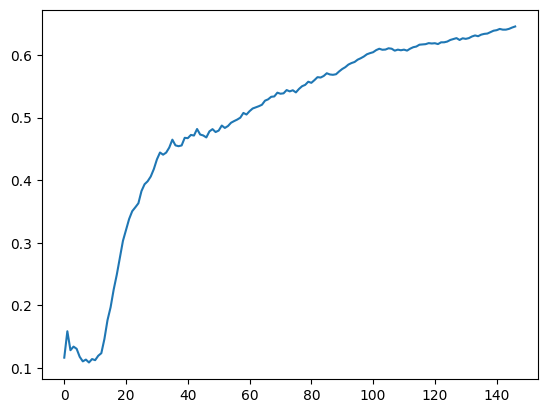

147


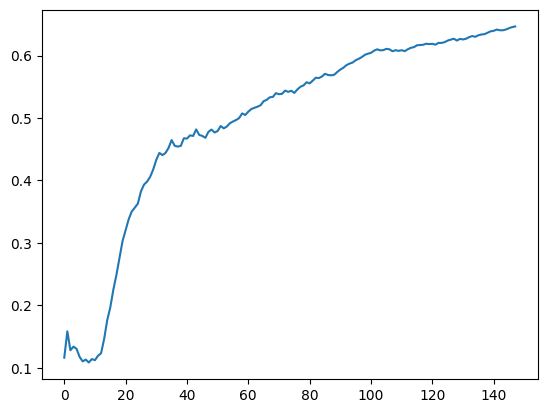

148


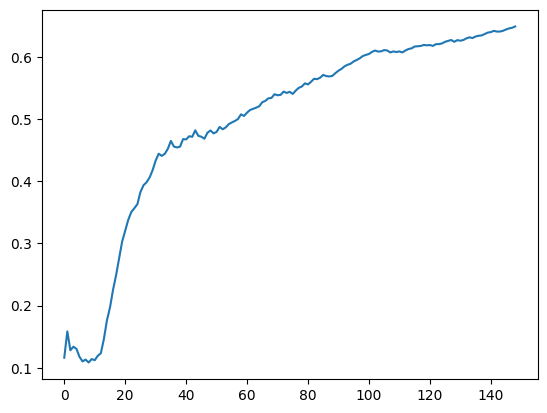

149


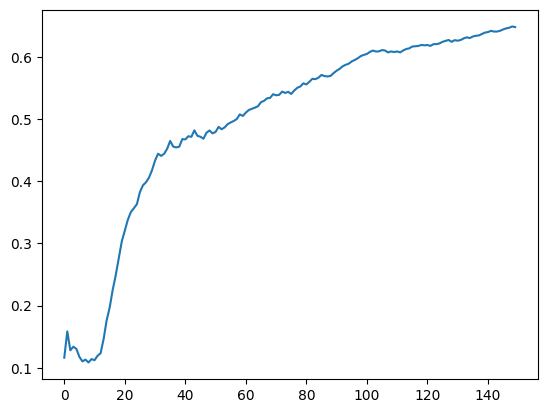

150


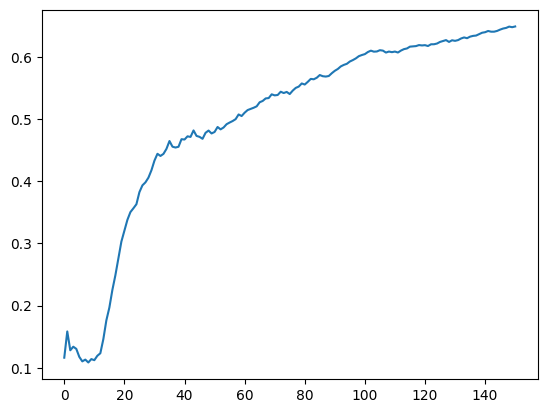

151


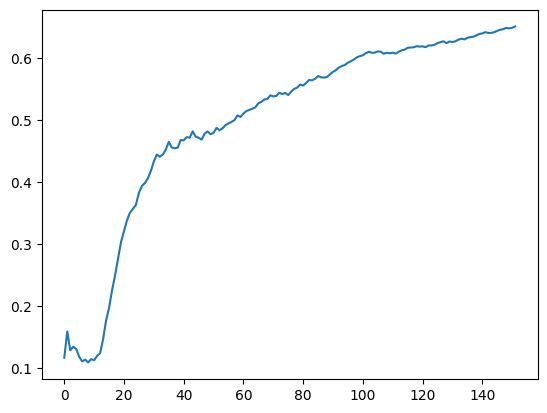

152


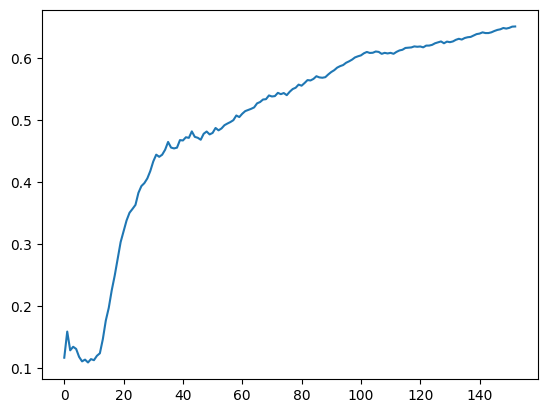

153


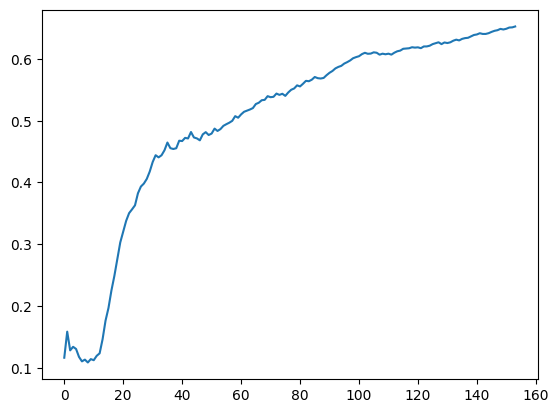

154


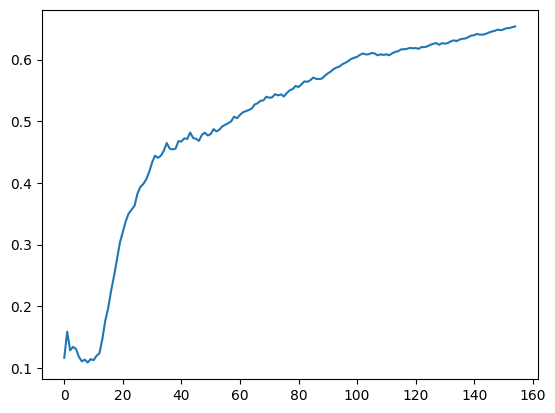

155


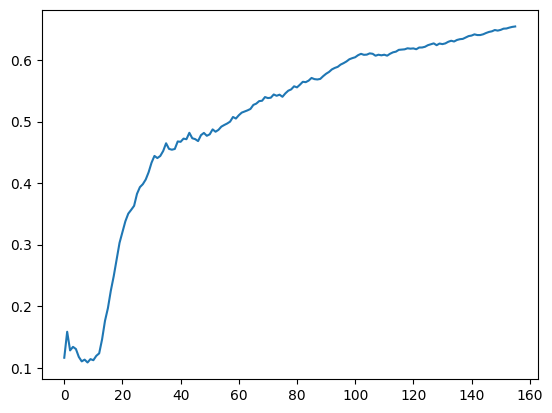

156


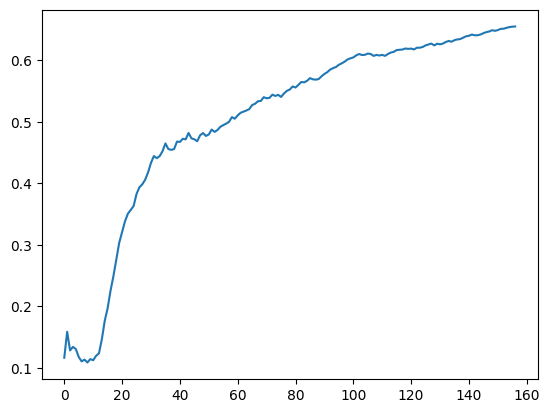

157


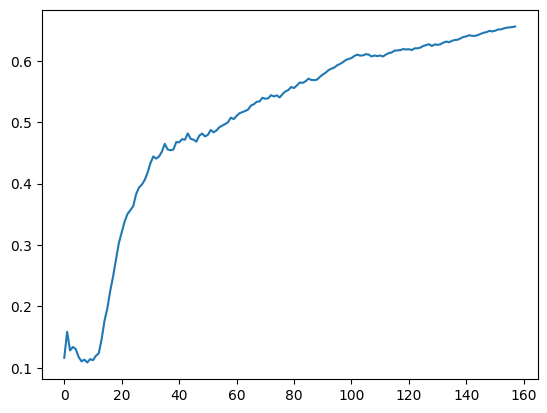

158


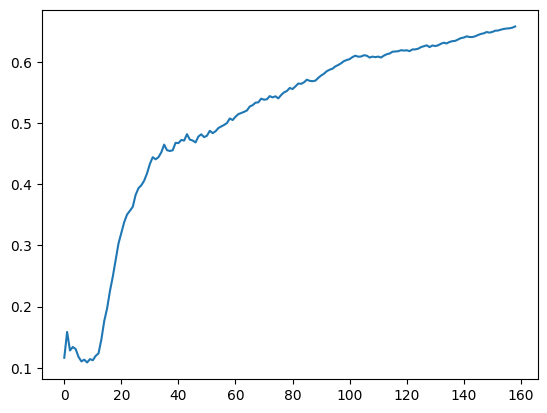

159


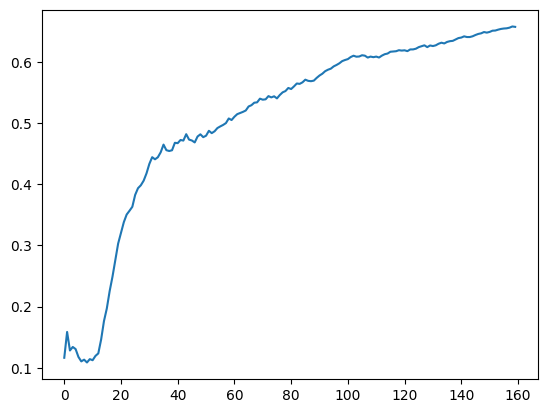

160


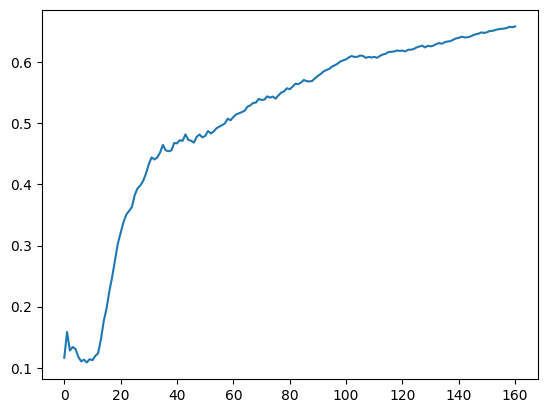

161


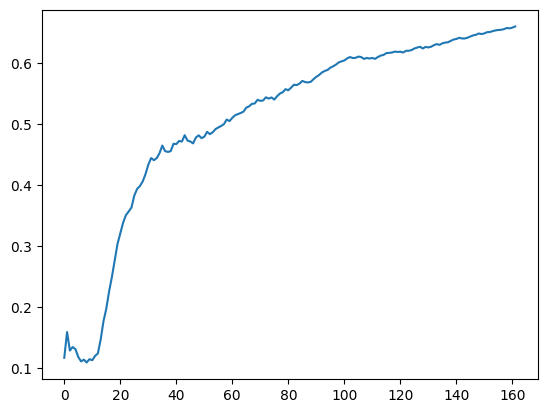

162


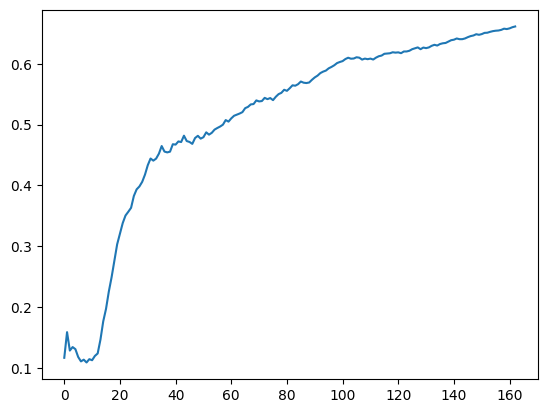

163


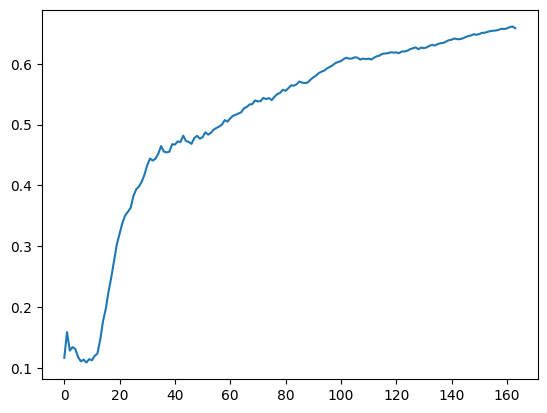

164


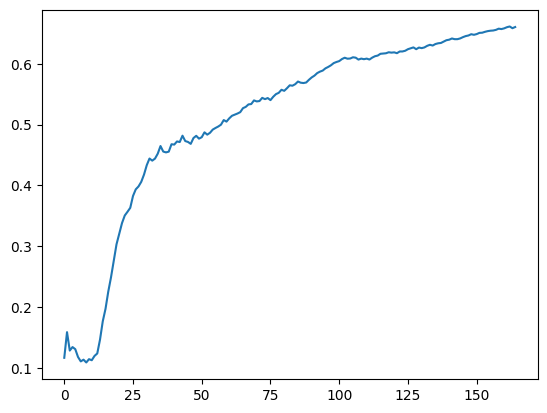

165


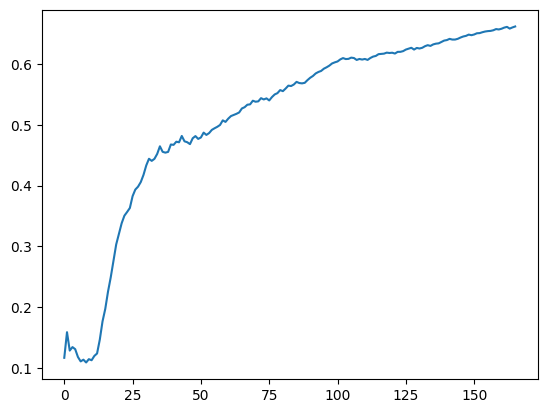

166


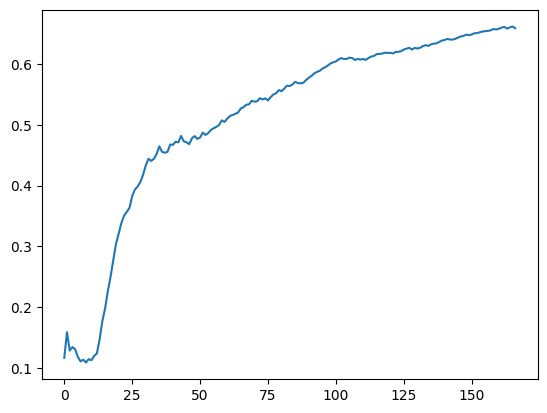

167


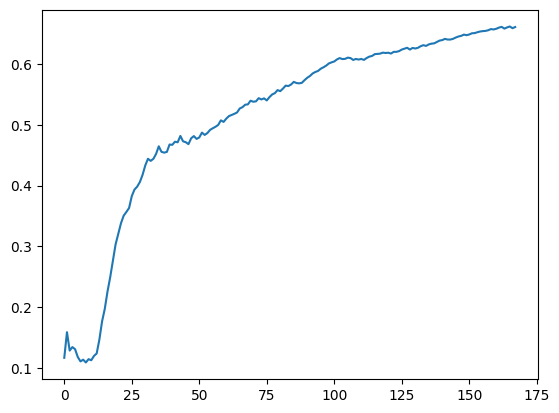

168


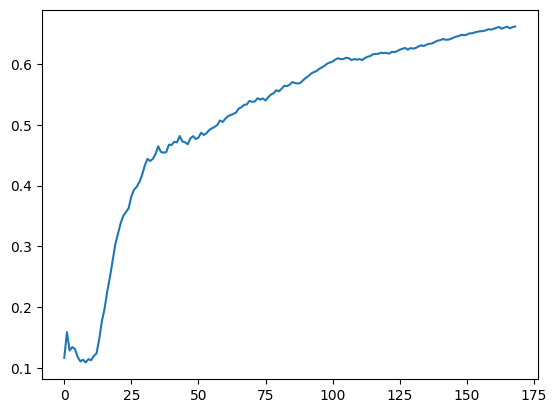

169


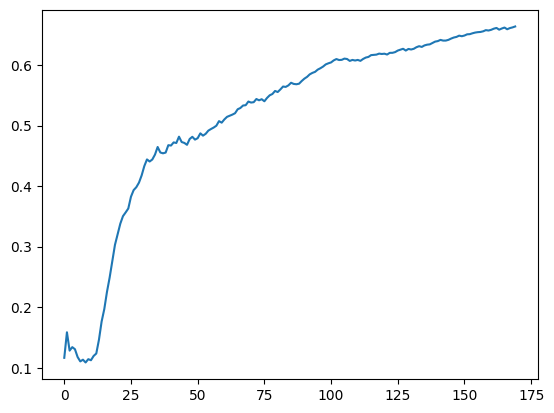

170


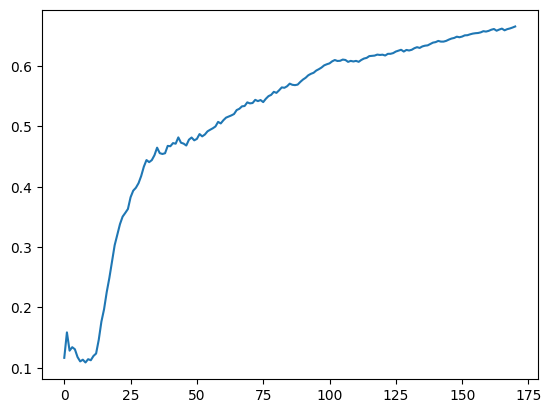

171


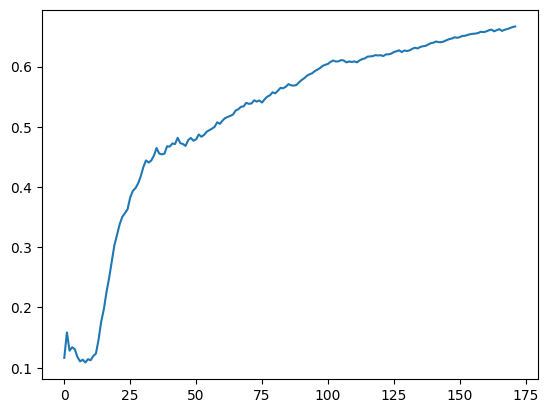

172


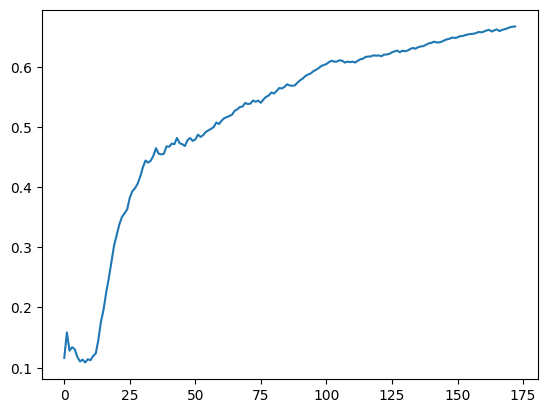

173


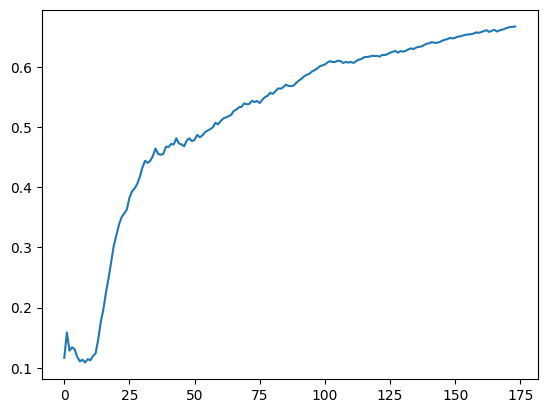

174


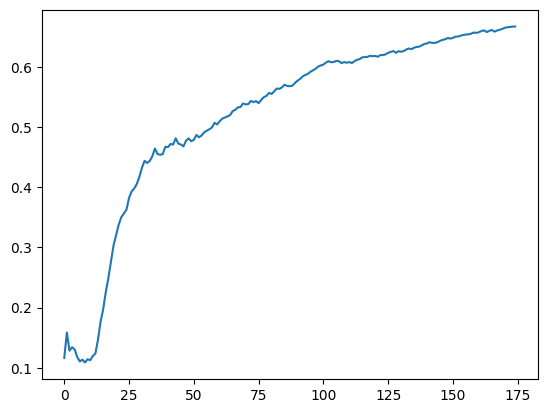

175


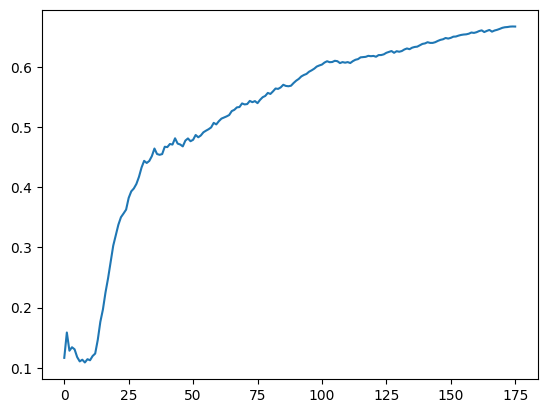

176


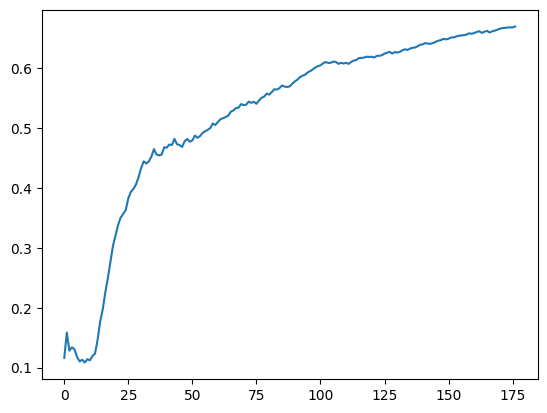

177


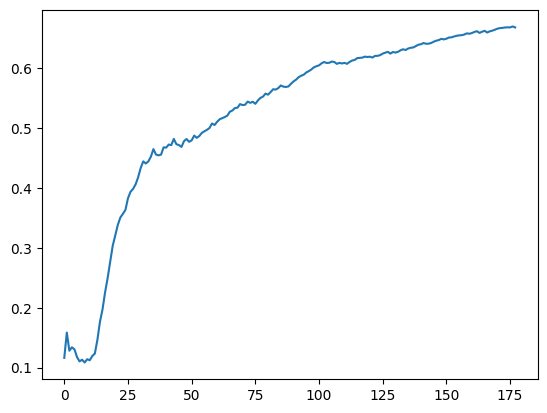

178


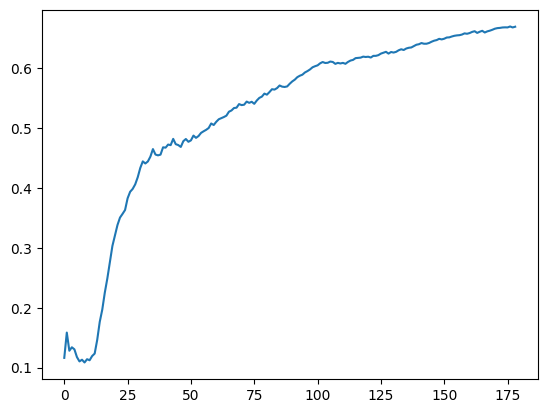

179


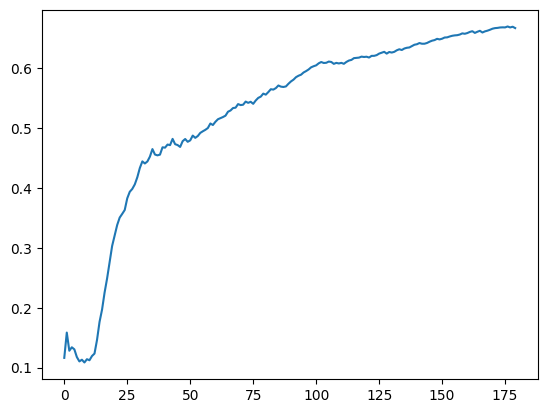

180


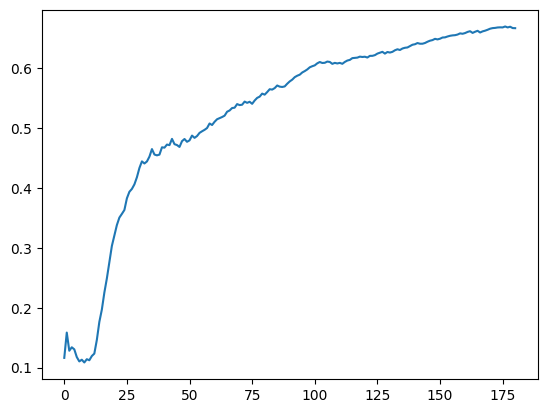

181


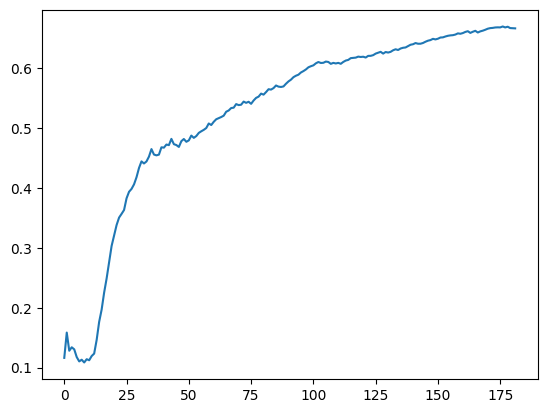

182


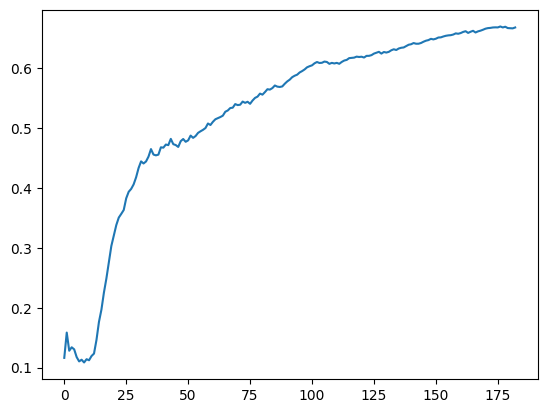

183


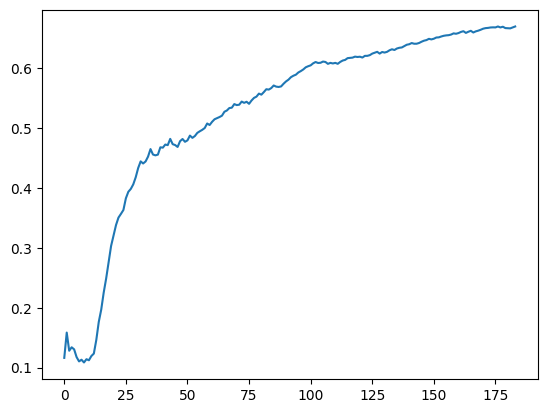

184


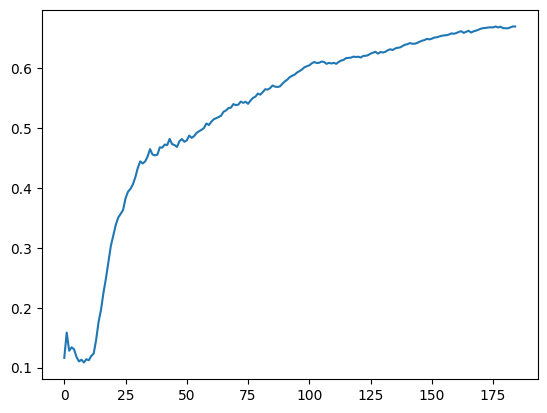

185


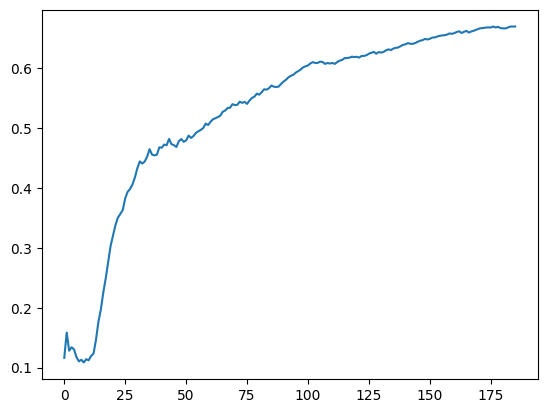

186


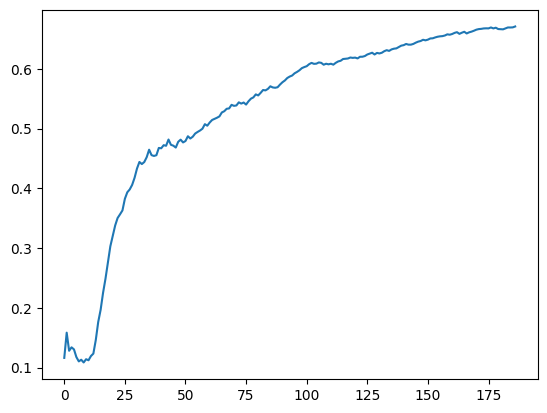

187


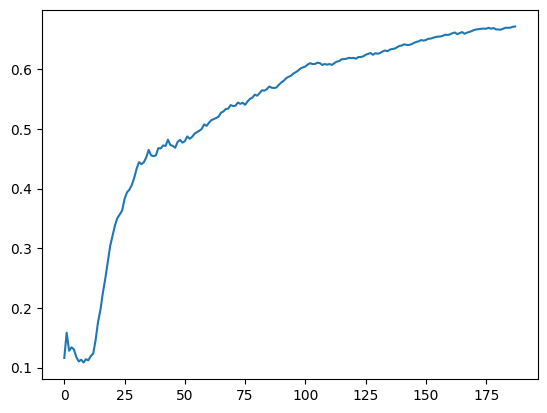

188


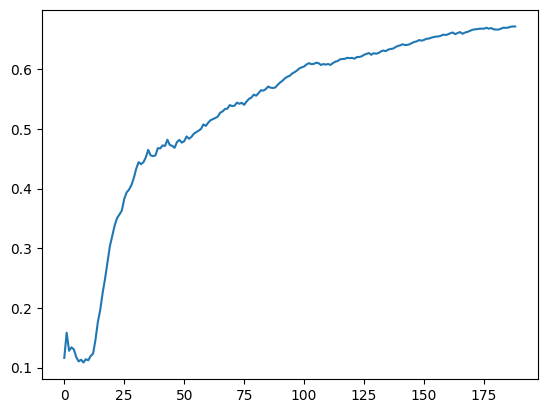

189


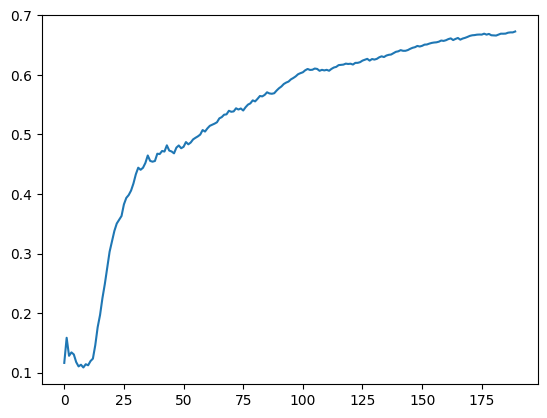

190


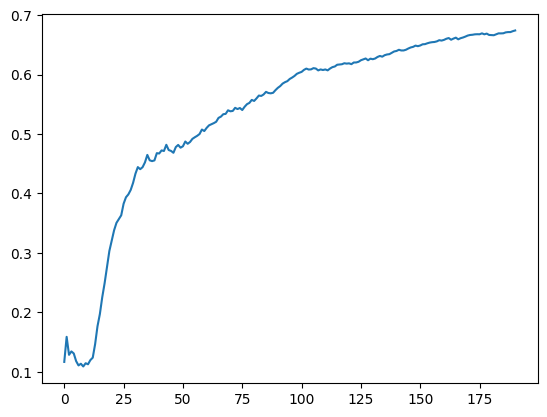

191


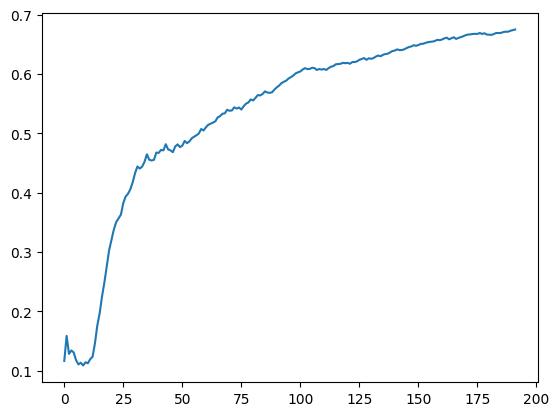

192


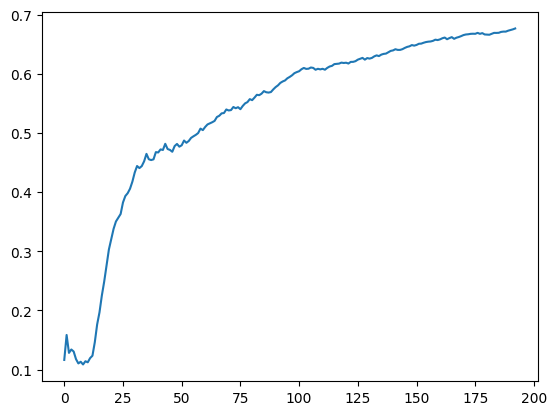

193


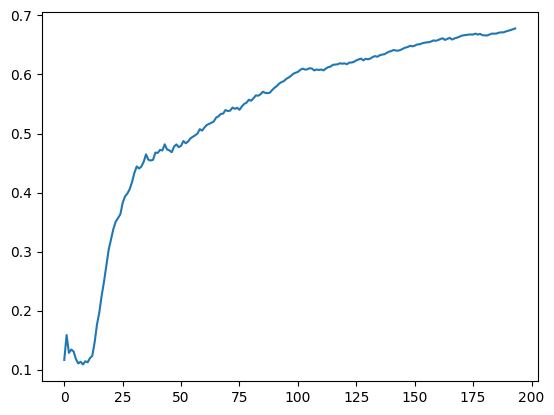

194


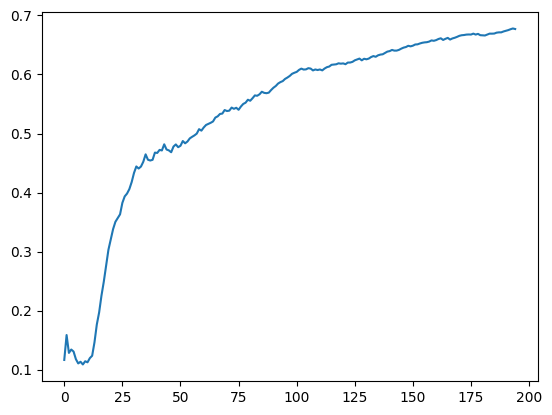

195


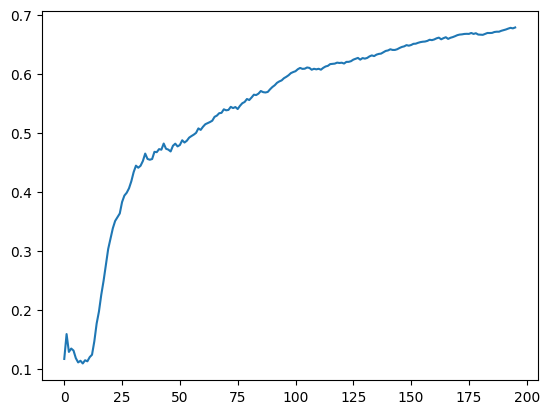

196


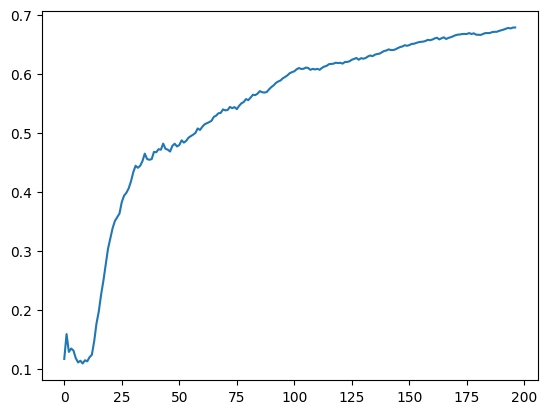

197


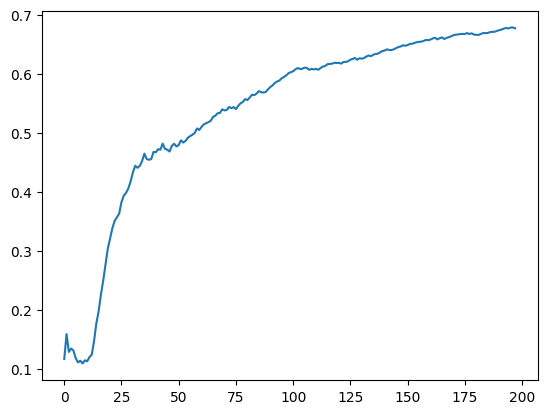

198


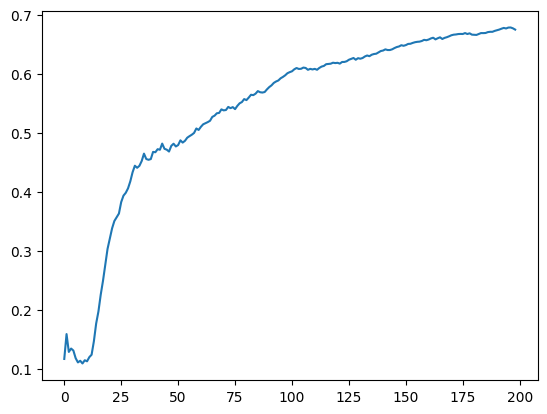

199


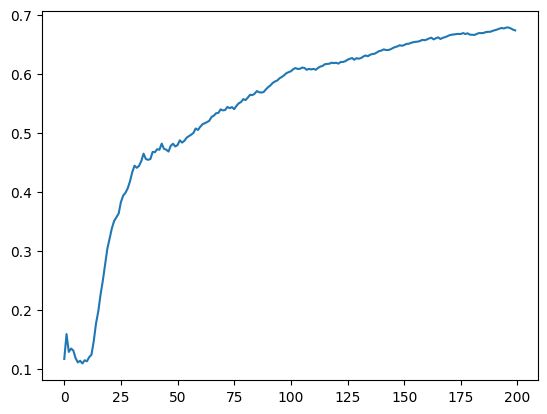

200


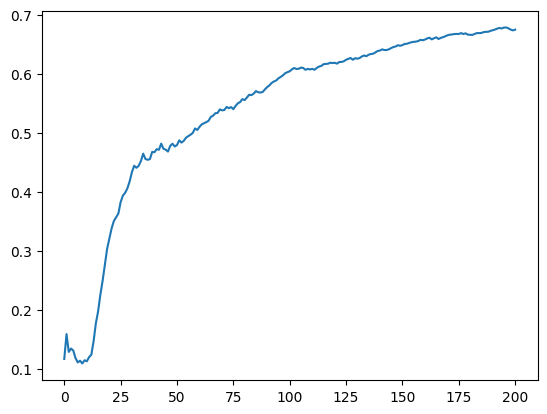

201


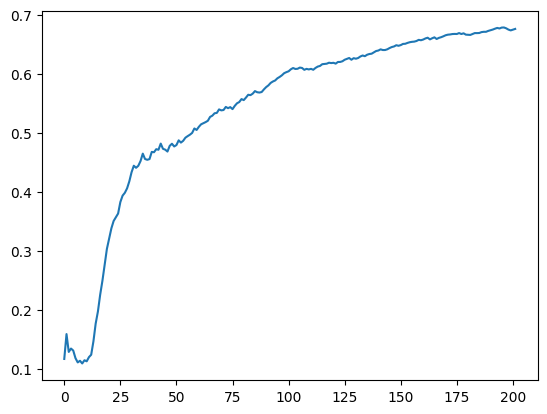

202


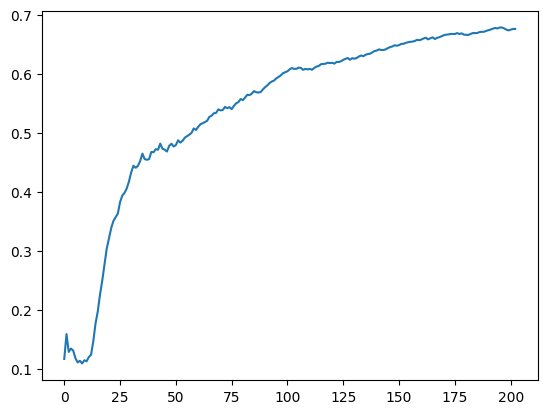

203


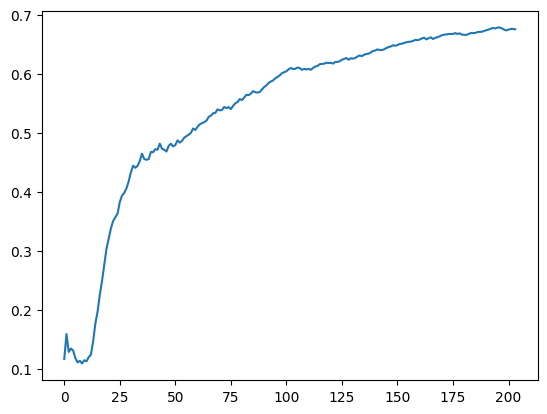

204


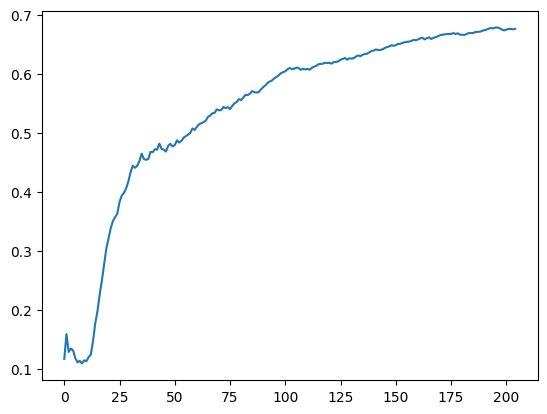

205


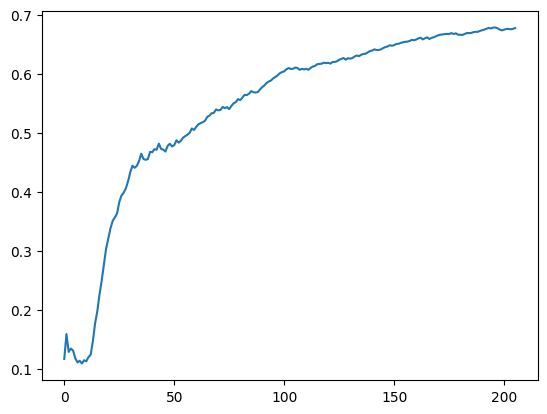

206


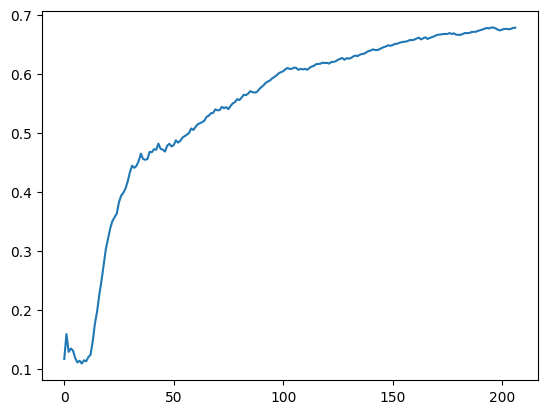

207


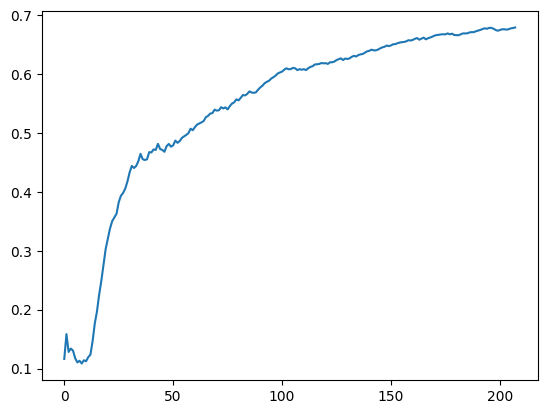

208


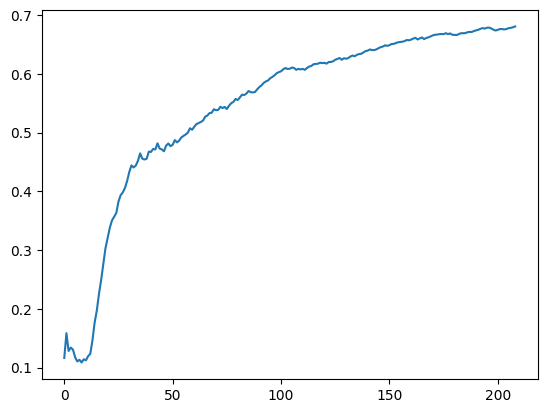

209


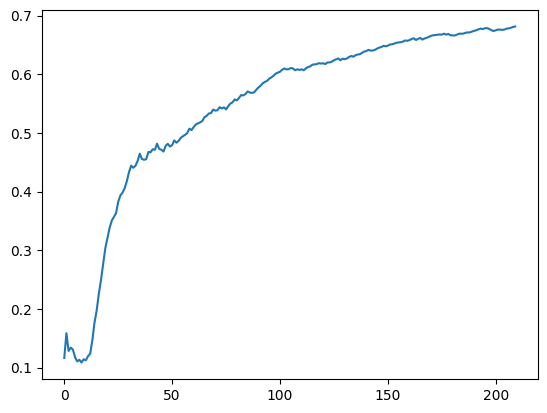

210


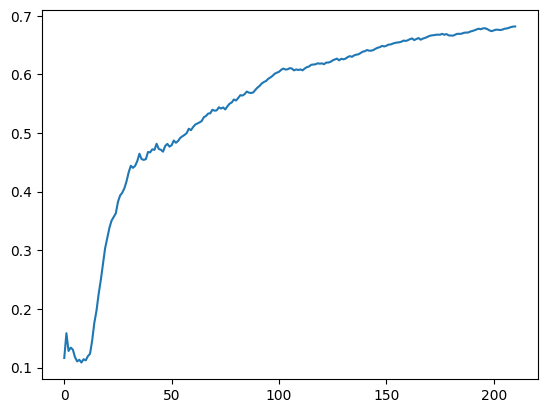

211


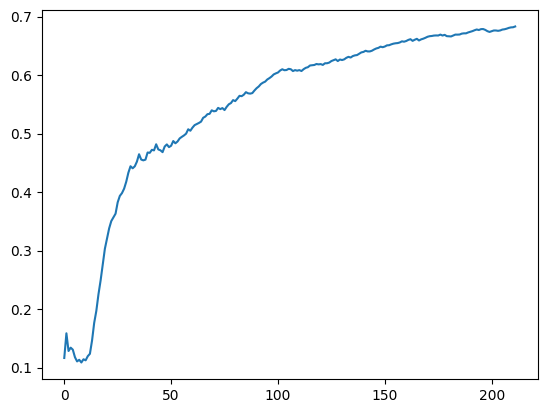

212


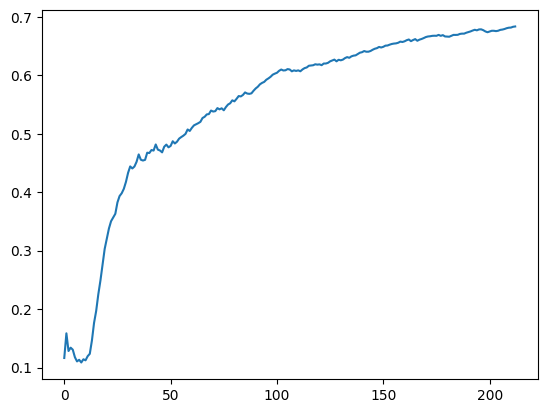

213


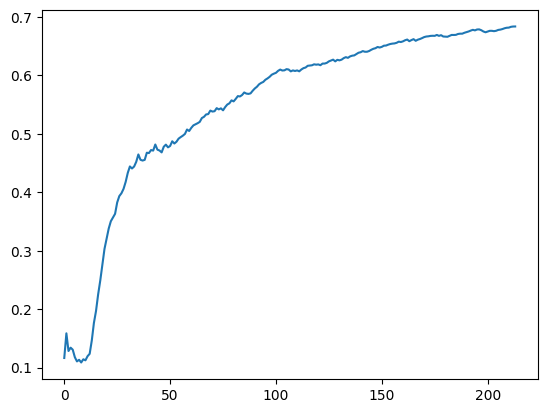

214


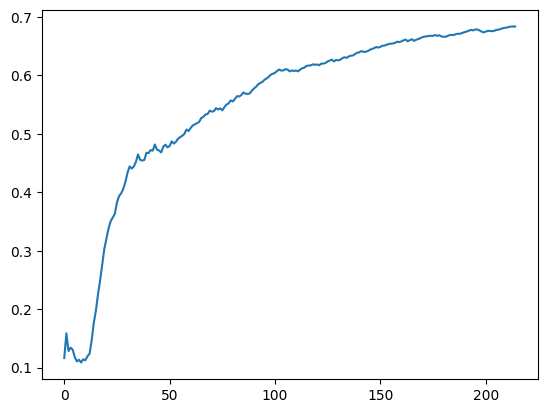

215


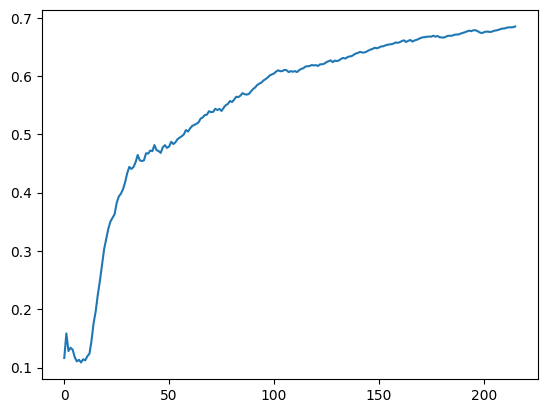

216


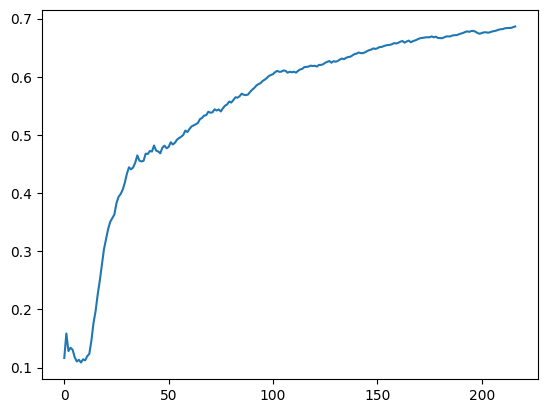

217


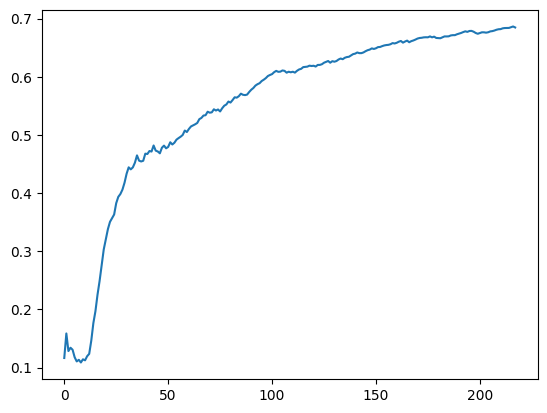

218


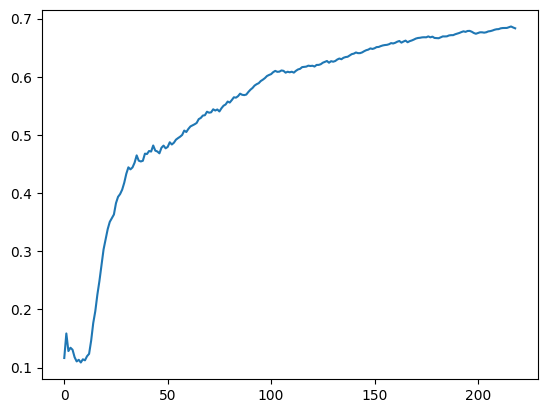

219


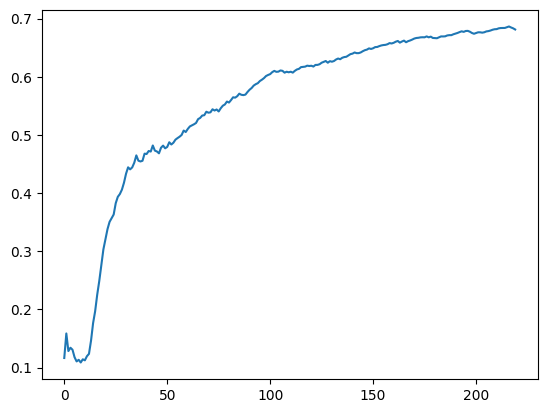

220


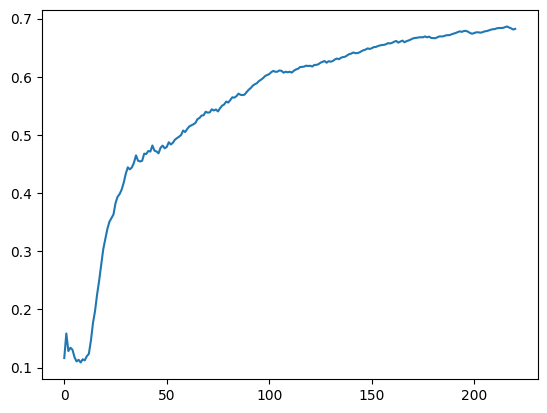

221


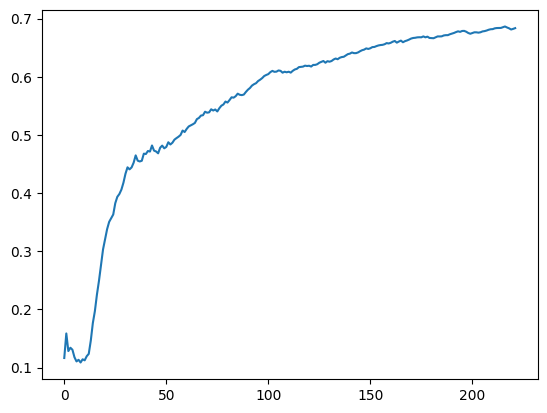

222


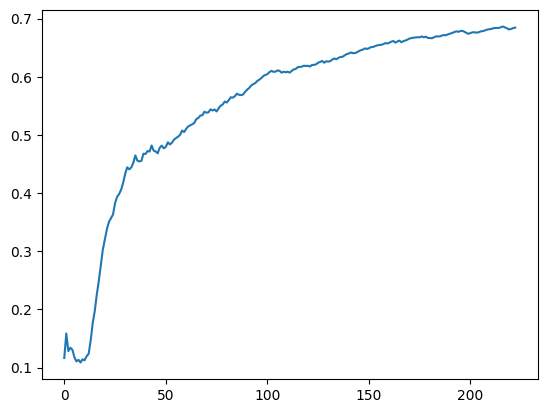

223


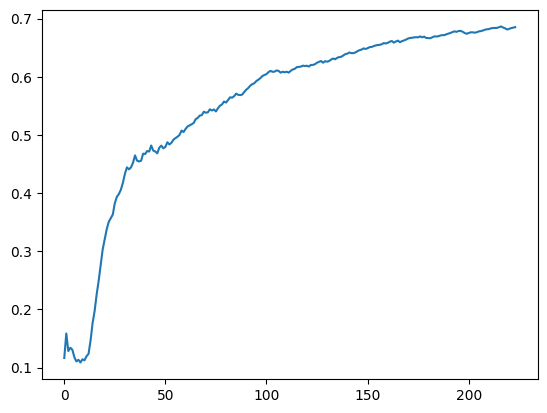

224


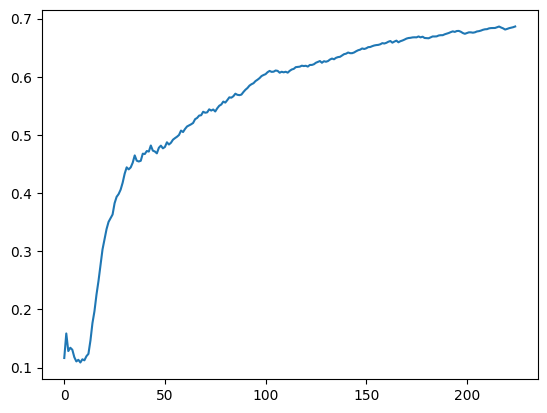

225


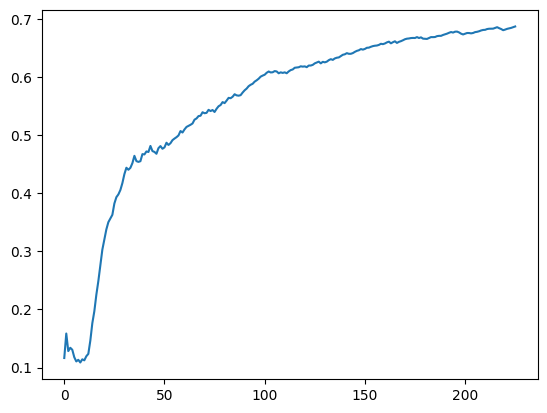

226


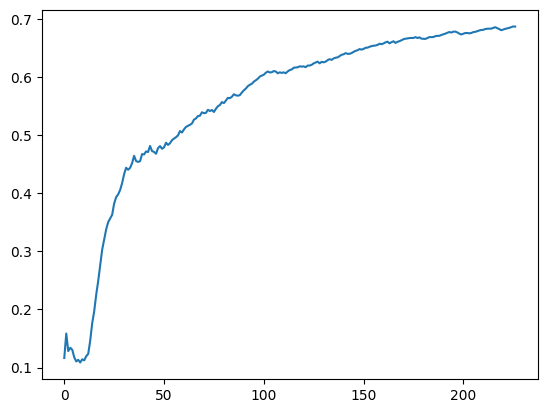

227


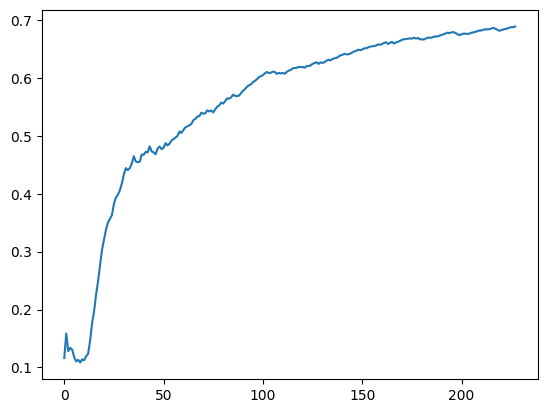

228


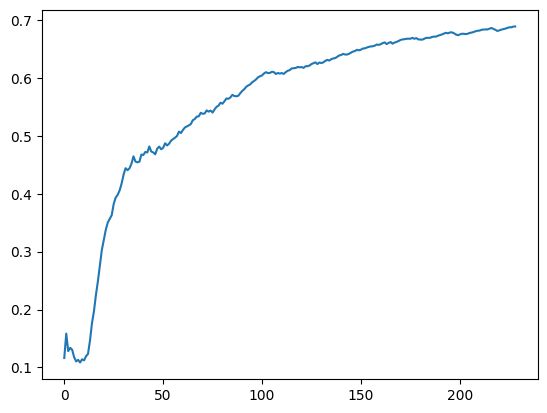

229


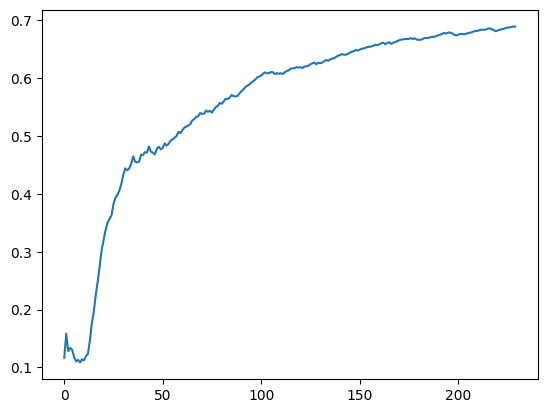

230


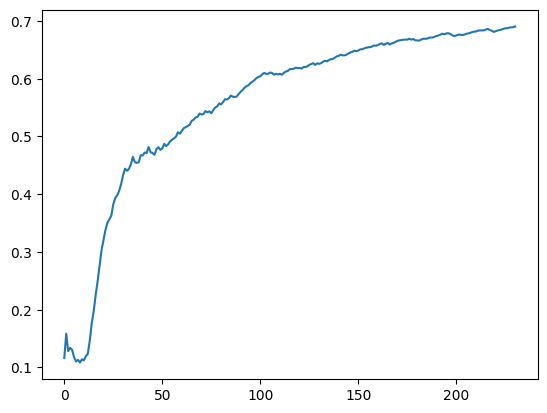

231


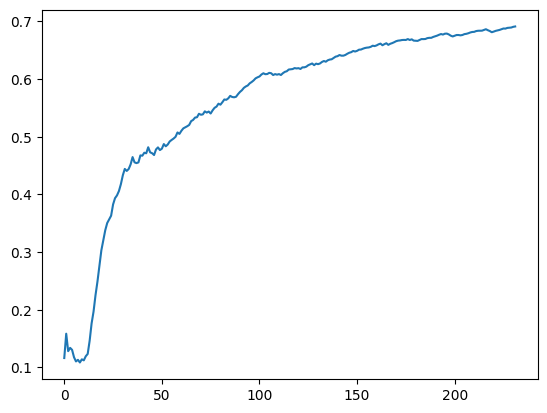

232


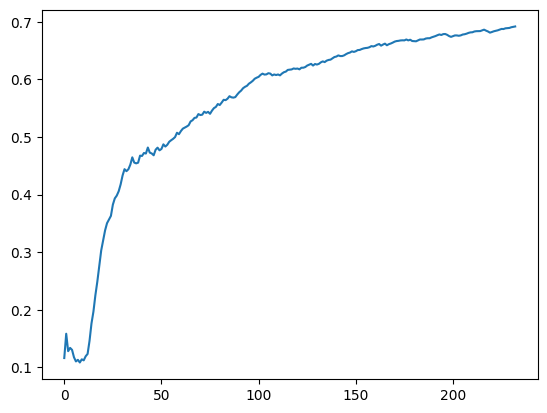

233


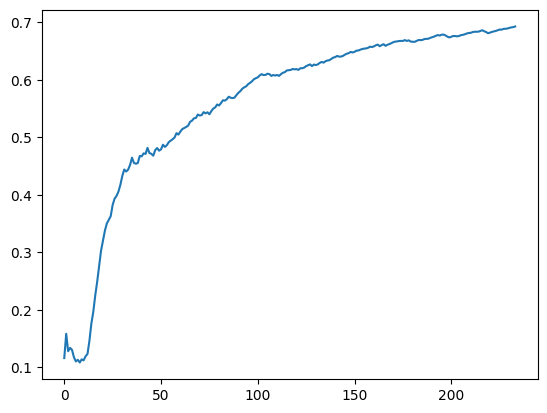

234


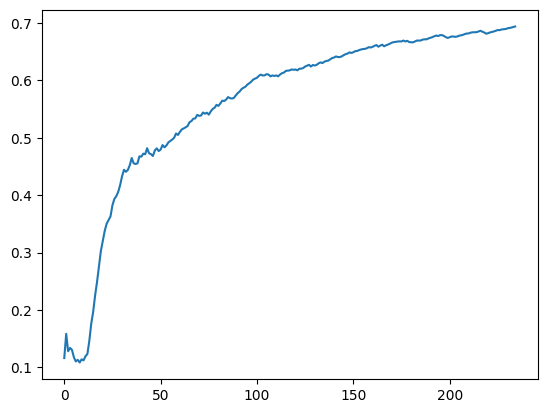

235


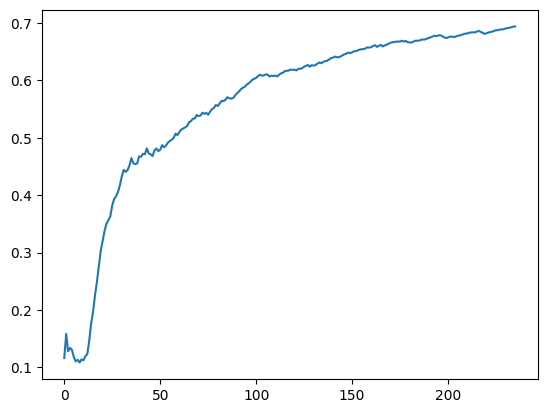

236


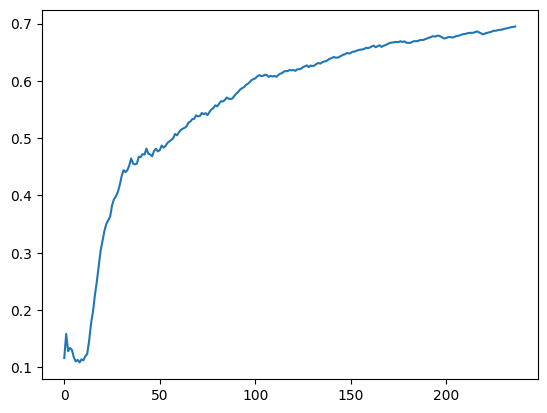

237


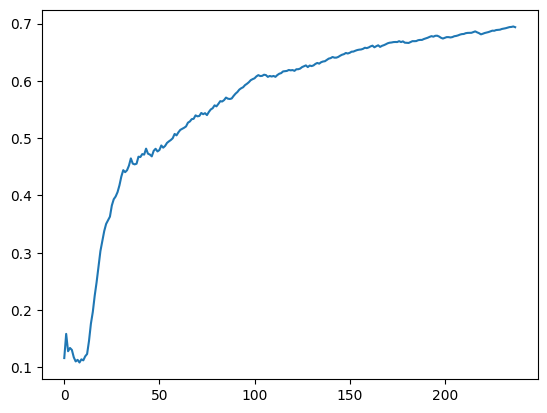

238


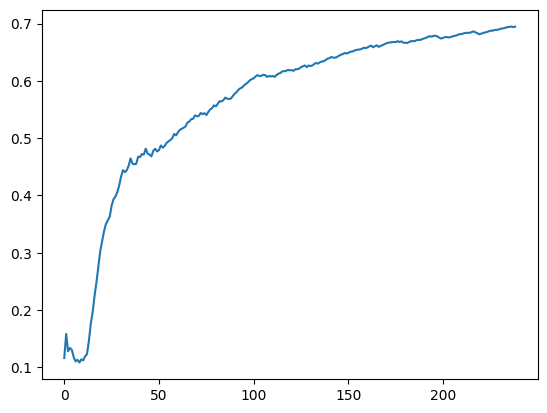

239


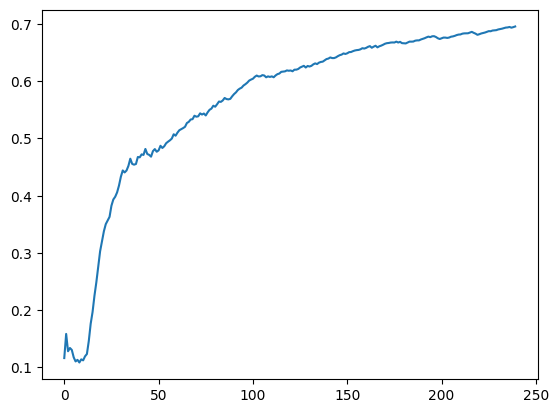

In [8]:
x = []
y = []
g=[]
z=[]
o=0

nof = 10
n = 200
d=[]
LIF = LIF_Network(n_neurons=n)
dt = LIF.dt

T = 10000 # time waiting after stimulation before measuring, in ms
I = np.zeros(shape = [T,n])
# add impulses to the outside actvity
stim = np.zeros([T,nof]) 
ConnStimNetwork = np.zeros([nof,n])
probability = 0.2

for c in range(n):
  for c2 in range(nof):
    Q = np.random.randint(0, high=99)
    if Q/100 < probability:
      ConnStimNetwork[c2,c] = 1

stimorder = np.arange(nof)
np.random.shuffle(stimorder)

freq = 50
num = int((T/freq)/dt)
stim_length = 0 # length of stimulation, in ms

for j in range(0,nof):
  for i in range(j*stim_length,(j+1)*stim_length,num): 
    if i<T:
      stim[i][stimorder[j]] = 1 
      I[i] [ConnStimNetwork[j,:]>0] = 1

%matplotlib inline
fig = plt.figure()

for i in range(240):
    W1 = np.copy(LIF.network_W)
    mean_W1 = np.mean(W1[W1 > 0].flatten())
    plotter2(LIF,T*dt, I, pN = 5)
    W2 = np.copy(LIF.network_W)
    mean_W2 = np.mean(W2[W1 > 0].flatten())
    mean_W3 = mean_W2-mean_W1
    d.append(mean_W2)
    order = LIF.kuramato(period = 200, lookBack = 1000)
    g.append(order)

    #print(o,  mean_W3)
    h=sum(d) / len(d)
    gh=sum(g) / len(g)
    x.append(o)
    y.append(h)
    z.append(gh)
    print(o)
    plt.plot(x,z)
    plt.show()
    o=o+1

This below cell runs when the frequency is 25 and the number of nodes is 45. It shows what the different trends in weights are at different times of waiting after the stimulation time.

The result is that the weights go up.:

In [ ]:
o = 25
nof = 45
n = 200
d=[]
c=[]
dt = LIF.dt
T = 10000
I = np.zeros(shape = [T,n])
# add impulses to the outside actvity
stim = np.zeros([T,nof]) 
ConnStimNetwork = np.zeros([nof,n])
probability = 0.2
for c in range(n):
    for c2 in range(nof):
        Q = np.random.randint(0, high=99)
        if Q/100 < probability:
            ConnStimNetwork[c2,c] = 1
stimorder = np.arange(nof)
np.random.shuffle(stimorder)
freq = o
num = int((T/freq)/dt)
stim_length = 50000
for j in range(0,nof):
    for i in range(j*stim_length,(j+1)*stim_length,num): 
        if i<T:
            stim[i][stimorder[j]] = 1 
            I[i] [ConnStimNetwork[j,:]>0] = 1
for T in range(2000,20000,2000):
    fig = plt.figure()
    fig.set_size_inches(5, 4)
    ax = fig.add_subplot()
    for tr in range(1):
        LIF = LIF_Network(n_neurons=n)
        c=[]
        f=[]
        for simcount in range(10):
            W1 = np.copy(LIF.network_W)
            mean_W1 = np.mean(W1[W1 > 0].flatten())
            plotter2(LIF,T*dt, I, pN = 5)
            W2 = np.copy(LIF.network_W)
            mean_W2 = np.mean(W2[W1 > 0].flatten())
            c.append(mean_W2)
            f.append(simcount)
        plt.plot(f,c)
        plt.title("T = " + str(T))
        plt.show()

This below cell runs when the frequency is 25 and the number of nodes is 45. It shows what the different trends in weights are at different times of waiting after the stimulation time.

The result is that the weights go down.

In [ ]:
o = 25
nof = 45
n = 200
d=[]
c=[]
dt = LIF.dt
T = 10000
I = np.zeros(shape = [T,n])
# add impulses to the outside actvity
stim = np.zeros([T,nof]) 
ConnStimNetwork = np.zeros([nof,n])
probability = 0.2
for c in range(n):
    for c2 in range(nof):
        Q = np.random.randint(0, high=99)
        if Q/100 < probability:
            ConnStimNetwork[c2,c] = 1
stimorder = np.arange(nof)
np.random.shuffle(stimorder)
freq = o
num = int((T/freq)/dt)
stim_length = int(T/nof)
for j in range(0,nof):
    for i in range(j*stim_length,(j+1)*stim_length,num): 
        if i<T:
            stim[i][stimorder[j]] = 1 
            I[i] [ConnStimNetwork[j,:]>0] = 1
for T in range(2000,20000,2000):
    fig = plt.figure()
    fig.set_size_inches(5, 4)
    ax = fig.add_subplot()
    for tr in range(1):
        LIF = LIF_Network(n_neurons=n)
        c=[]
        f=[]
        for simcount in range(10):
            W1 = np.copy(LIF.network_W)
            mean_W1 = np.mean(W1[W1 > 0].flatten())
            plotter2(LIF,T*dt, I, pN = 5)
            W2 = np.copy(LIF.network_W)
            mean_W2 = np.mean(W2[W1 > 0].flatten())
            c.append(mean_W2)
            f.append(simcount)
        plt.plot(f,c)
        plt.title("T = " + str(T))
        plt.show()

This below cell is running the stimulation to produce a matrix of weights after the stimulation. The time waiting after the stimulatino is 10 seconds, while the stimulation length itself is 1 second. The number of neurons is 200. 

From this cell, we get a graph showing that the weights of the neurons decreases at frequencies between 10 and 70 Hz, while it increases above 70-80 Hz.

In [ ]:
from datetime import datetime
LIF = LIF_Network(n_neurons=2)
# datetime object containing current date and time
now = datetime.now()
print("now =", now) 
results_matrix = np.zeros([10,25])
ii = -1
jj = -1
hj=0
# Experiment parameters
T = 100000
stim_length = 10000
n = 200
dt = LIF.dt
probability = 0.2
print("starting...")
for k in range(1,51,5):
    ii = ii+1
    jj=-1
    nof = k
    print("trial " + str(ii) + " of " + str(60/2))
    for o in range(1, 251, 10):
        jj = jj+1
        meanW=[]
        for i in range(3):
            LIF = LIF_Network(n_neurons=n)
            I = np.zeros(shape = [T,n])
            # add impulses to the outside actvity
            stim = np.zeros([T,nof]) 
            ConnStimNetwork = np.zeros([nof,n])
            for c in range(n):
                for c2 in range(nof):
                    Q = np.random.randint(0, high=99)
                    if Q/100 < probability:
                        ConnStimNetwork[c2,c] = 1
            stimorder = np.arange(nof)
            np.random.shuffle(stimorder)
            freq = o
            num = int(1000/freq/dt)
            held_i = 0    
            while held_i<T:
                for j in range(nof):
                    for i in range(0,stim_length,num): 
                        if i+held_i<T:
                            stim[i+held_i][stimorder[j]] = 1 
                            I[i+held_i] [ConnStimNetwork[j,:]>0] = 1              
                    held_i = held_i + stim_length
            W1 = np.copy(LIF.network_W)
            mean_W1 = np.mean(W1[W1 > 0].flatten())
            plotter2(LIF,T*dt, I, pN = 5)
            W2 = np.copy(LIF.network_W)
            mean_W2 = np.mean(W2[W1 > 0].flatten())
            meanW.append(mean_W2)
            print("elapsed time for trial was: ", datetime.now()-now)
            now = datetime.now()
            print("frequency: " + str(o) +" produced mean weight of: " + str(mean_W2))
        results_matrix[ii][jj]=np.mean(meanW)
        %matplotlib inline
        fig = plt.figure()
        fig.set_size_inches(5, 4)
        ax = fig.add_subplot()
        plt.imshow(np.flipud(results_matrix),aspect='equal',interpolation='none', vmin=np.min(results_matrix[np.nonzero(results_matrix)]), vmax=np.max(results_matrix[np.nonzero(results_matrix)]), cmap='jet')
    
        plt.colorbar()
        ax.set_aspect('auto')
        plt.ylabel('number of nodes')
        plt.xlabel('frequency')
        plt.show()

This below cell is running the stimulation to produce a matrix of the order of the neuron system after the stimulation. The time waiting after the stimulatino is 15 seconds, while the stimulation length itself is 1 second. The number of neurons is 200. 

From this cell, we get a graph showing that the order of the neurons approximately decreases at frequencies between 10 and 70 Hz, while it increases above 70-80 Hz, similar to the weights. However, it is slightly more random than the weights.

In [ ]:
from datetime import datetime
LIF = LIF_Network(n_neurons=2)
# datetime object containing current date and time
now = datetime.now()
print("now =", now) 
results_matrix = np.zeros([17,20])
ii = -1
jj = -1
hj=0
# Experiment parameters
T = 150000
stim_length = 10000
n = 200
dt = LIF.dt
probability = 0.2
print("starting...")
for k in range(1,51,3):
    ii = ii+1
    jj=-1
    nof = k
    print("trial " + str(ii) + " of " + str(60/2))
    for o in range(1, 201, 10):
        jj = jj+1
        meanW=[]
        for i in range(5):
            LIF = LIF_Network(n_neurons=n)
            I = np.zeros(shape = [T,n])
            # add impulses to the outside actvity
            stim = np.zeros([T,nof]) 
            ConnStimNetwork = np.zeros([nof,n])
            for c in range(n):
                for c2 in range(nof):
                    Q = np.random.randint(0, high=99)
                    if Q/100 < probability:
                        ConnStimNetwork[c2,c] = 1
            stimorder = np.arange(nof)
            np.random.shuffle(stimorder)
            freq = o
            num = int(1000/freq/dt)
            held_i = 0    
            while held_i<T:
                for j in range(nof):
                    for i in range(0,stim_length,num): 
                        if i+held_i<T:
                            stim[i+held_i][stimorder[j]] = 1 
                            I[i+held_i] [ConnStimNetwork[j,:]>0] = 1              
                    held_i = held_i + stim_length
            W1 = np.copy(LIF.network_W)
            mean_W1 = np.mean(W1[W1 > 0].flatten())
            
            plotter2(LIF,T*dt, I, pN = 5)
            order = LIF.kuramato(period = 200, lookBack = 1000)
            W2 = np.copy(LIF.network_W)
            mean_W2 = np.mean(W2[W1 > 0].flatten())
            meanW.append(mean_W2)
            print("elapsed time for trial was: ", datetime.now()-now)
            now = datetime.now()
            print("frequency: " + str(o) +" produced mean weight of: " + str(order))
        results_matrix[ii][jj]=np.mean(order)
        %matplotlib inline
        fig = plt.figure()
        fig.set_size_inches(5, 4)
        ax = fig.add_subplot()
        plt.imshow(np.flipud(results_matrix),aspect='equal',interpolation='none', vmin=np.min(results_matrix[np.nonzero(results_matrix)]), vmax=np.max(results_matrix[np.nonzero(results_matrix)]), cmap='jet')
        plt.colorbar()
        ax.set_aspect('auto')
        plt.ylabel('number of nodes')
        plt.xlabel('frequency')
        plt.show()

## Effects of stimulation frequency and number of stimulation sites on weights and synchrony.


These next two cells produce matrixes with the frequency vs. number of nodes, with a colorbar representing the weights of the neurons in the first cell and the synchrony of the neurons in the second cell. They use the new version of the connectivity model, which makes the connectivity dependent on the distance between neurons.

In [5]:
from datetime import datetime
LIF = LIF_Network(n_neurons=200)
LIF.structured_conn(LIF)
# datetime object containing current date and time
now = datetime.now()
print("now =", now) 
results_matrix = np.zeros([10,25])
ii = -1
jj = -1
hj=0
# Experiment parameters
T = 100000
stim_length = 10000
n = 200
dt = LIF.dt
probability = 0.2
print("starting...")
for k in range(1,51,5):
    ii = ii+1
    jj=-1
    nof = k
    print("trial " + str(ii) + " of " + str(60/2))
    for o in range(1, 251, 10):
        jj = jj+1
        meanW=[]
        for i in range(3):
            LIF = LIF_Network(n_neurons=n)
            LIF.structured_conn(LIF)
            I = np.zeros(shape = [T,n])
            # add impulses to the outside actvity
            stim = np.zeros([T,nof]) 
            ConnStimNetwork = np.zeros([nof,n])
            for c in range(n):
                for c2 in range(nof):
                    Q = np.random.randint(0, high=99)
                    if Q/100 < probability:
                        ConnStimNetwork[c2,c] = 1
            stimorder = np.arange(nof)
            np.random.shuffle(stimorder)
            freq = o
            num = int(1000/freq/dt)
            held_i = 0    
            while held_i<T:
                for j in range(nof):
                    for i in range(0,stim_length,num): 
                        if i+held_i<T:
                            stim[i+held_i][stimorder[j]] = 1 
                            I[i+held_i] [ConnStimNetwork[j,:]>0] = 1              
                    held_i = held_i + stim_length
            W1 = np.copy(LIF.network_W)
            mean_W1 = np.mean(W1[W1 > 0].flatten())
            plotter2(LIF,T*dt, I, pN = 5)
            W2 = np.copy(LIF.network_W)
            mean_W2 = np.mean(W2[W1 > 0].flatten())
            meanW.append(mean_W2)
            print("elapsed time for trial was: ", datetime.now()-now)
            now = datetime.now()
            print("frequency: " + str(o) +" produced mean weight of: " + str(mean_W2))
        results_matrix[ii][jj]=np.mean(meanW)
        %matplotlib inline
        fig = plt.figure()
        fig.set_size_inches(5, 4)
        ax = fig.add_subplot()
        plt.imshow(np.flipud(results_matrix),aspect='equal',interpolation='none', vmin=np.min(results_matrix[np.nonzero(results_matrix)]), vmax=np.max(results_matrix[np.nonzero(results_matrix)]), cmap='jet')
    
        plt.colorbar()
        ax.set_aspect('auto')
        plt.ylabel('number of nodes')
        plt.xlabel('frequency')
        plt.show()

The average distance between neurons in this network is: 62.30243211971799
The base of the exponent is: 0.9582150141865606


KeyboardInterrupt: 

In [ ]:
from datetime import datetime
LIF = LIF_Network(n_neurons=200)
LIF.structured_conn(LIF)
# datetime object containing current date and time
now = datetime.now()
print("now =", now) 
results_matrix = np.zeros([17,20])
ii = -1
jj = -1
hj=0
# Experiment parameters
T = 150000
stim_length = 10000
n = 200
dt = LIF.dt
probability = 0.2
print("starting...")
for k in range(1,51,3):
    ii = ii+1
    jj=-1
    nof = k
    print("trial " + str(ii) + " of " + str(60/2))
    for o in range(1, 201, 10):
        jj = jj+1
        meanW=[]
        for i in range(5):
            LIF = LIF_Network(n_neurons=n)
            LIF.structured_conn(LIF)
            I = np.zeros(shape = [T,n])
            # add impulses to the outside actvity
            stim = np.zeros([T,nof]) 
            ConnStimNetwork = np.zeros([nof,n])
            for c in range(n):
                for c2 in range(nof):
                    Q = np.random.randint(0, high=99)
                    if Q/100 < probability:
                        ConnStimNetwork[c2,c] = 1
            stimorder = np.arange(nof)
            np.random.shuffle(stimorder)
            freq = o
            num = int(1000/freq/dt)
            held_i = 0    
            while held_i<T:
                for j in range(nof):
                    for i in range(0,stim_length,num): 
                        if i+held_i<T:
                            stim[i+held_i][stimorder[j]] = 1 
                            I[i+held_i] [ConnStimNetwork[j,:]>0] = 1              
                    held_i = held_i + stim_length
            W1 = np.copy(LIF.network_W)
            mean_W1 = np.mean(W1[W1 > 0].flatten())
            
            plotter2(LIF,T*dt, I, pN = 5)
            order = LIF.kuramato(period = 200, lookBack = 1000)
            W2 = np.copy(LIF.network_W)
            mean_W2 = np.mean(W2[W1 > 0].flatten())
            meanW.append(mean_W2)
            print("elapsed time for trial was: ", datetime.now()-now)
            now = datetime.now()
            print("frequency: " + str(o) +" produced mean weight of: " + str(order))
        results_matrix[ii][jj]=np.mean(order)
        %matplotlib inline
        fig = plt.figure()
        fig.set_size_inches(5, 4)
        ax = fig.add_subplot()
        plt.imshow(np.flipud(results_matrix),aspect='equal',interpolation='none', vmin=np.min(results_matrix[np.nonzero(results_matrix)]), vmax=np.max(results_matrix[np.nonzero(results_matrix)]), cmap='jet')
        plt.colorbar()
        ax.set_aspect('auto')
        plt.ylabel('number of nodes')
        plt.xlabel('frequency')
        plt.show()

## Reinforcement Learning Test Book


In [9]:
n = 100
LIF = LIF_Network(n_neurons=n)
LIF.structured_conn(LIF)
nof = 10

probability = 0.2

ConnStimNetwork = np.zeros([nof,n])
for c in range(n):
    for c2 in range(nof):
        Q = np.random.randint(0, high=99)
        if Q/100 < probability:
            ConnStimNetwork[c2,c] = 1

The average distance between neurons in this network is: 65.6741975452747
The base of the exponent is: 0.9603171331776337


In [10]:
class StimulusInput:
  def __init__(self):
    self.name = "Stimulus Input"
    self.n_states = 11  # Lets start with 11 stats,range(0,.1,1.1) kuramato orders
    self.n_actions = 5*5 # Lets have 10 frequencies and 10 sites
    self.init_state = 0

  def get_outcome(self, state, action, LIF, ConnStimNetwork):
    reward = 0
    next_state = 0

    #basically we want the agent to pick a stimulation based on the current state.
    # To get the outcome lets run the simulation and get the order...
    # Let's take MAtteo's work as the baseline experiment:
    dt = LIF.dt
    
    T = int(50000/10) # This is 100 seconds, I divided it by 10 because the stimorder has nof actions in it (10).
    stim_length = 50000
    
    n = LIF.n_neurons
    I = np.zeros(shape = [int(T/dt),n])
    Wpre = np.copy(LIF.network_W) # Starting weights.

    freq = np.floor(action/10) * 10 + 10
    stimorder = action%10
    num = int(1000/freq/dt)
    held_i = 0    
    
    while held_i<T/dt:
        for i in range(0,stim_length,num): 
            if i+held_i<T/dt:                
                I[i+held_i][ConnStimNetwork[stimorder,:]>0] = 1      
        held_i = held_i + stim_length

    LIF.simulate(timesteps = T,I=I)
    LIF.simulate(timesteps = 2000)
    Wpost = np.copy(LIF.network_W) # Starting weights.
    ord = LIF.kuramato(period = 250, lookBack = 2000)

    next_state = np.round(ord*10)
    reward = 1-ord
    return int(next_state) if next_state is not None else None, reward

  def get_all_outcomes(self):
    outcomes = {}
    for state in range(self.n_states):
      for action in range(self.n_actions):
        next_state, reward = self.get_outcome(state, action)
        outcomes[state, action] = [(1, next_state, reward)]
    return outcomes


In [11]:
class LearningWorld:
  def __init__(self):
    self.name = "Stimulus Input"
    self.n_states = 1  # Lets start with 11 stats,range(0,.1,1.1) kuramato orders
    self.n_actions = 4 # Lets have 10 frequencies and 10 sites
    self.init_state = 0

  def get_outcome(self, state, action, LIF, ConnStimNetwork):
    pre_w = np.mean(LIF.network_W.flatten())
    if(action==0):
        LIF.network_W = LIF.network_W + 0.03
    if(action==1):
        LIF.network_W = LIF.network_W
    if(action==2):
        LIF.network_W = LIF.network_W - 0.015
    if(action==3):
        LIF.network_W = LIF.network_W - 0.06

    next_state = 0
    reward = pre_w - np.mean(LIF.network_W.flatten())
    return int(next_state) if next_state is not None else None, reward

  def get_all_outcomes(self):
    outcomes = {}
    for state in range(self.n_states):
      for action in range(self.n_actions):
        next_state, reward = self.get_outcome(state, action)
        outcomes[state, action] = [(1, next_state, reward)]
    return outcomes


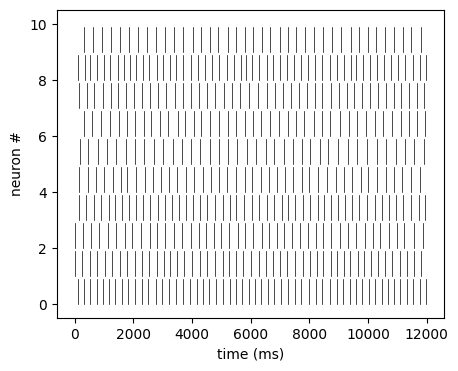

Pre RL training step 1...
Time:12000.000000026124
Order:0.06618786291481653


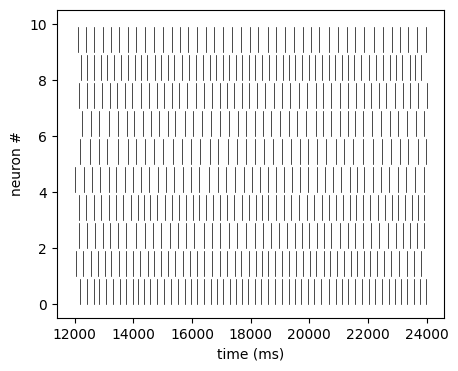

Pre RL training step 2...
Time:23999.999999931246
Order:0.18273569288271735


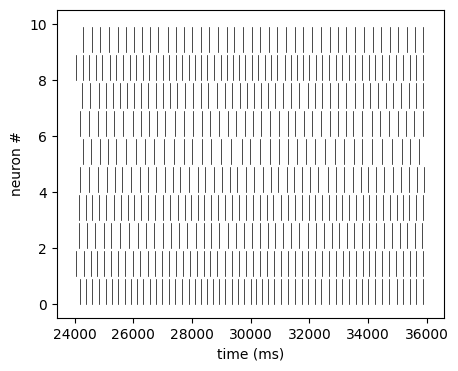

Pre RL training step 3...
Time:35999.99999975663
Order:0.17876847706806734


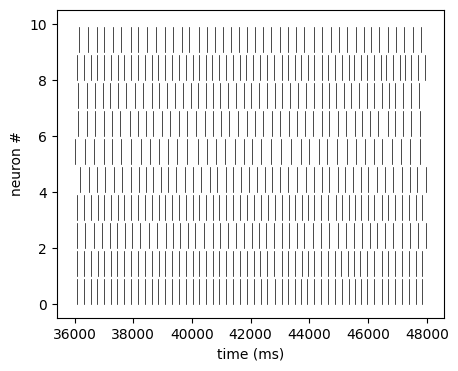

Pre RL training step 4...
Time:47999.999999582
Order:0.6118062630116717


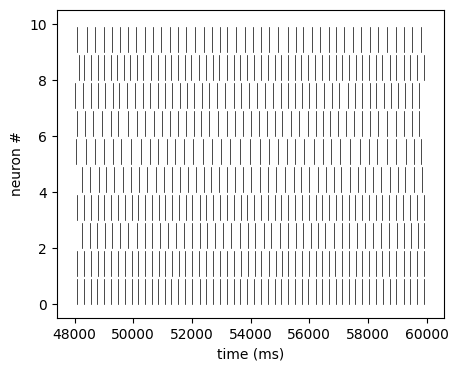

Pre RL training step 5...
Time:59999.99999940738
Order:0.6900824265571334


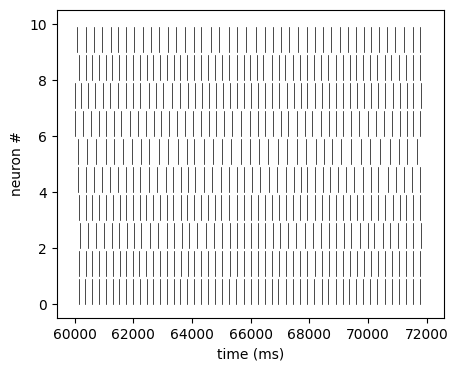

Pre RL training step 6...
Time:71999.99999970307
Order:0.6638798193339501


In [12]:
#### First let's get the network oversynced:
n =100
LIF = LIF_Network(n_neurons=n)
nof = 10

probability = 0.2

ConnStimNetwork = np.zeros([nof,n])
for c in range(n):
    for c2 in range(nof):
        Q = np.random.randint(0, high=99)
        if Q/100 < probability:
            ConnStimNetwork[c2,c] = 1


for i in range(6):
  LIF.simulate(timesteps = 12000)
  ord = LIF.kuramato(period = 250, lookBack = int(2000))
  x = LIF.spikeTrain(lookBack = int(12000), nNeurons=10)
  print("Pre RL training step " + str(i+1) + "...")
  print("Time:" + str(LIF.t))
  print("Order:" + str(ord))



In [ ]:
# now lets see what a random strategy does
LIF.external_strength = 400/25
Stim = StimulusInput()
a = 1
intermediates = 25
aholder = []
tholder = []
for i in range(10):
    action = np.random.randint(nof)
    a = Stim.get_outcome(a,action,LIF,ConnStimNetwork)
    ord = LIF.kuramato(period = 250, lookBack = int(2000))
    x = LIF.spikeTrain(lookBack = int(12000), nNeurons=10)
    print("Round " + str(i+1))
    print("Time:" + str(LIF.t))
    print("State:" + str(a))
    print("Order:" + str(ord))
    aholder.append(ord)
    tholder.append(LIF.t)
    for j in range(intermediates):
        LIF.simulate(timesteps = 2000)
        ord = LIF.kuramato(period = 250, lookBack = int(2000))
        aholder.append(ord)
        tholder.append(LIF.t)
        
for j in range(intermediates):
    LIF.simulate(timesteps = 2000)
    ord = LIF.kuramato(period = 250, lookBack = int(2000))
    aholder.append(ord)   
    tholder.append(LIF.t)

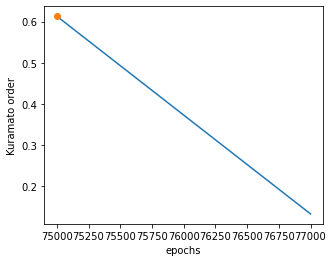

In [10]:
# now we can plot the effect and the recovery in terms of order:
fig = plt.figure()
plt.xlabel('epochs')
plt.ylabel('Kuramato order')
plt.plot(tholder,aholder)
aa = np.array(aholder)
tt = np.array(tholder)
plt.plot(tt[range(0,len(tholder),intermediates+1)],aa[range(0,len(aholder),intermediates+1)],'o')
fig.set_size_inches(5, 4)
plt.show()

In [13]:
# @markdown Execute to get helper functions `epsilon_greedy`, `CliffWorld`, and `learn_environment`

def epsilon_greedy(q, epsilon):
  """Epsilon-greedy policy: selects the maximum value action with probabilty
  (1-epsilon) and selects randomly with epsilon probability.

  Args:
    q (ndarray): an array of action values
    epsilon (float): probability of selecting an action randomly

  Returns:
    int: the chosen action
  """
  if np.random.random() > epsilon:
    action = np.argmax(q)
  else:
    action = np.random.choice(len(q))

  return action

#@title Plotting Functions

def plot_state_action_values(env, value, ax=None):
  """
  Generate plot showing value of each action at each state.
  """
  if ax is None:
    fig, ax = plt.subplots()

  for a in range(env.n_actions):
    ax.plot(range(env.n_states), value[:, a], marker='o', linestyle='--')
  ax.set(xlabel='States', ylabel='Values')
  ax.legend(['R','U','L','D'], loc='lower right')


def plot_quiver_max_action(env, value, ax=None):
  """
  Generate plot showing action of maximum value or maximum probability at
    each state (not for n-armed bandit or cheese_world).
  """
  if ax is None:
    fig, ax = plt.subplots()

  X = np.tile(np.arange(env.dim_x), [env.dim_y,1]) + 0.5
  Y = np.tile(np.arange(env.dim_y)[::-1][:,np.newaxis], [1,env.dim_x]) + 0.5
  which_max = np.reshape(value.argmax(axis=1), (env.dim_y,env.dim_x))
  which_max = which_max[::-1,:]
  U = np.zeros(X.shape)
  V = np.zeros(X.shape)
  U[which_max == 0] = 1
  V[which_max == 1] = 1
  U[which_max == 2] = -1
  V[which_max == 3] = -1

  ax.quiver(X, Y, U, V)
  ax.set(
      title='Maximum value/probability actions',
      xlim=[-0.5, env.dim_x+0.5],
      ylim=[-0.5, env.dim_y+0.5],
  )
  ax.set_xticks(np.linspace(0.5, env.dim_x-0.5, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_xticks(np.arange(env.dim_x+1), minor=True)
  ax.set_yticks(np.linspace(0.5, env.dim_y-0.5, num=env.dim_y))
  ax.set_yticklabels(["%d" % y for y in np.arange(0, env.dim_y*env.dim_x,
                                                  env.dim_x)])
  ax.set_yticks(np.arange(env.dim_y+1), minor=True)
  ax.grid(which='minor',linestyle='-')


def plot_heatmap_max_val(env, value, ax=None):
  """
  Generate heatmap showing maximum value at each state
  """
  if ax is None:
    fig, ax = plt.subplots()

  if value.ndim == 1:
      value_max = np.reshape(value, (env.dim_y,env.dim_x))
  else:
      value_max = np.reshape(value.max(axis=1), (env.dim_y,env.dim_x))
  value_max = value_max[::-1,:]

  im = ax.imshow(value_max, aspect='auto', interpolation='none', cmap='afmhot')
  ax.set(title='Maximum value per state')
  ax.set_xticks(np.linspace(0, env.dim_x-1, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_yticks(np.linspace(0, env.dim_y-1, num=env.dim_y))
  if env.name != 'windy_cliff_grid':
      ax.set_yticklabels(
          ["%d" % y for y in np.arange(
              0, env.dim_y*env.dim_x, env.dim_x)][::-1])
  return im


def plot_rewards(n_episodes, rewards, average_range=10, ax=None):
  """
  Generate plot showing total reward accumulated in each episode.
  """
  if ax is None:
    fig, ax = plt.subplots()

  smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)

  ax.plot(range(0, n_episodes, average_range),
          smoothed_rewards[0:n_episodes:average_range],
          marker='o', linestyle='--')
  ax.set(xlabel='Episodes', ylabel='Total reward')


def plot_performance(env, value, reward_sums):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
  plot_state_action_values(env, value, ax=axes[0,0])
  plot_quiver_max_action(env, value, ax=axes[0,1])
  plot_rewards(n_episodes, reward_sums, ax=axes[1,0])
  im = plot_heatmap_max_val(env, value, ax=axes[1,1])
  fig.colorbar(im)

def learn_environment(env, learning_rule, params, max_steps, n_episodes, LIF, C):
  # Start with a uniform value function
  value = np.ones((env.n_states, env.n_actions))

  # Run learning
  reward_sums = np.zeros(n_episodes)
  now = datetime.now()
  # Loop over episodes
  for episode in range(n_episodes):
    state = env.init_state  # initialize state
    reward_sum = 0

    for t in range(max_steps):
      # choose next action
      action = epsilon_greedy(value[state], params['epsilon'])

      # observe outcome of action on environment
      next_state, reward = env.get_outcome(state, action, LIF, C)
      arraysomething.append(1-reward)
      print(t, 1-reward, reward)
      print('action taken was', action)
      print(np.mean(LIF.network_W.flatten()))
      print('time taken is', datetime.now() - now, '\n')
      now = datetime.now()

      # update value function
      value = learning_rule(state, action, reward, next_state, value, params)

      # sum rewards obtained
      reward_sum += reward

      if next_state is None:
          break  # episode ends
      state = next_state

    reward_sums[episode] = reward_sum

  return value, reward_sums

In [ ]:
arraysomething = []

def q_learning(state, action, reward, next_state, value, params):
  """Q-learning: updates the value function and returns it.

  Args:
    state (int): the current state identifier
    action (int): the action taken
    reward (float): the reward received
    next_state (int): the transitioned to state identifier
    value (ndarray): current value function of shape (n_states, n_actions)
    params (dict): a dictionary containing the default parameters

  Returns:
    ndarray: the updated value function of shape (n_states, n_actions)
  """
  # Q-value of current state-action pair
  q = value[state, action]

  # write an expression for finding the maximum Q-value at the current state
  if next_state is None:
    max_next_q = 0
  else:
    max_next_q = np.max(value[next_state])

  # write the expression to compute the TD error
  td_error = reward + params['gamma'] * max_next_q - q
  # write the expression that updates the Q-value for the state-action pair
  value[state, action] = q + params['alpha'] * td_error

  return value


# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.3,  # epsilon-greedy policy
  'alpha': 0.1,  # learning rate
  'gamma': 1.0,  # discount factor
}

# episodes/trials
n_episodes = 1
max_steps = 1000

# environment initialization
env = StimulusInput()

# solve Cliff World using Q-learning
results = learn_environment(env, q_learning, params, max_steps, n_episodes, LIF, ConnStimNetwork)
value_qlearning, reward_sums_qlearning = results
plt.plot(np.arange(0,len(arraysomething),1),arraysomething)

0 0.38415936512518745 0.6158406348748126
action taken was 0
0.0416286104948382
time taken is 0:00:11.422445 

1 0.5703611128831445 0.4296388871168555
action taken was 0
0.04062590251223679
time taken is 0:00:11.308496 

2 0.3434235537350042 0.6565764462649958
action taken was 0
0.04011322636237223
time taken is 0:00:11.367497 

3 0.4819357288804982 0.5180642711195018
action taken was 24
0.04077758767005138
time taken is 0:00:11.942728 

4 0.4936749753408942 0.5063250246591058
action taken was 0
0.04032345824499767
time taken is 0:00:11.446079 

5 0.29234649853281824 0.7076535014671818
action taken was 0
0.03959686682691092
time taken is 0:00:11.355009 

6 0.3899891342476183 0.6100108657523817
action taken was 24
0.040293375135105336
time taken is 0:00:12.367715 

7 0.5225406408738315 0.47745935912616855
action taken was 0
0.0394467671204493
time taken is 0:00:12.021041 



In [20]:
print(value_qlearning, reward_sums_qlearning)

[[1.50483799 1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.29651133 1.         1.         1.         1.
  1.        ]
 [1.         1.31306306 1.         3.8186369  1.         1.
  1.         1.         1.         1.36047562 1.18230362 1.33987763
  1.20044721 1.         1.17422634 1.40059395 1.67941967 1.35424672
  1.         1.         1.         1.59888284 1.30089532 1.
  1.41867237]
 [3.9277041  1.         1.21481455 1.         1.79735818 1.
  1.10057701 1.30662951 1.         1.         1.10629313 1.31977228
  1.21686371 1.51047898 1.44675968 1.         1.21602087 1.1354096
  1.36139573 1.         1.         1.         1.25509578 1.
  1.37509504]
 [1.30335789 1.48514689 1.         1.         1.         3.93500216
  1.35974464 1.         1.         1.48960637 1.         1.36239379
  1.45983512 1.         1.30015052 1.         1.34054467 1.21656546
  1

AttributeError: 'StimulusInput' object has no attribute 'dim_x'

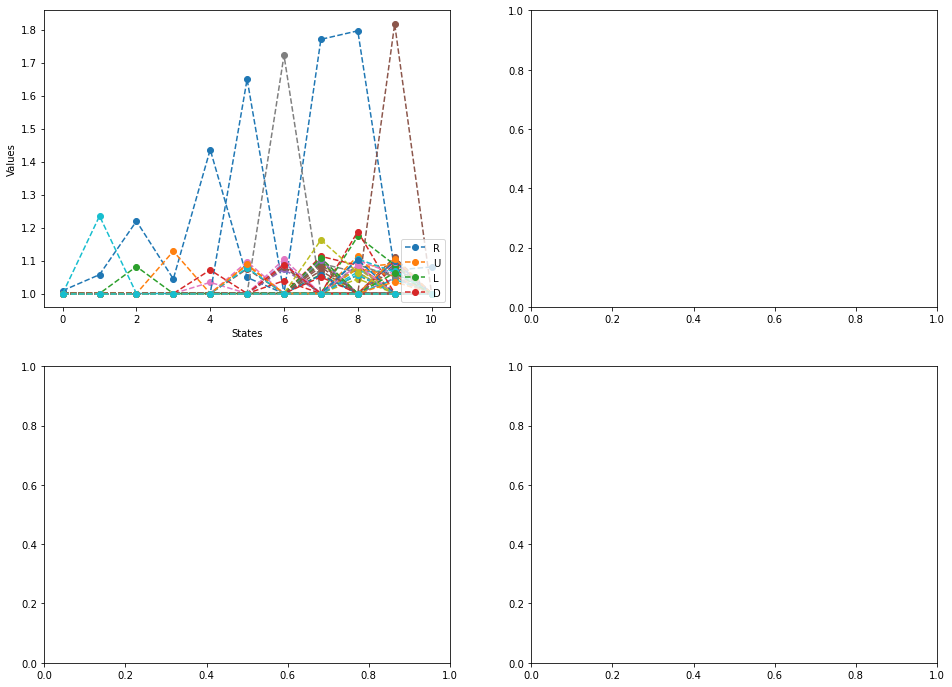

In [13]:
plot_performance(env, value_qlearning, reward_sums_qlearning)

In [17]:
def q_learning(state, action, reward, next_state, value, params):
  """Q-learning: updates the value function and returns it.

  Args:
    state (int): the current state identifier
    action (int): the action taken
    reward (float): the reward received
    next_state (int): the transitioned to state identifier
    value (ndarray): current value function of shape (n_states, n_actions)
    params (dict): a dictionary containing the default parameters

  Returns:
    ndarray: the updated value function of shape (n_states, n_actions)
  """
  # Q-value of current state-action pair
  q = value[state, action]

  # write an expression for finding the maximum Q-value at the current state
  if next_state is None:
    max_next_q = 0
  else:
    max_next_q = np.max(value[next_state])

  # write the expression to compute the TD error
  td_error = reward + params['gamma'] * max_next_q - q
  # write the expression that updates the Q-value for the state-action pair
  value[state, action] = q + params['alpha'] * td_error

  return value


# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.4,  # epsilon-greedy policy
  'alpha': 0.1,  # learning rate
  'gamma': 1.0,  # discount factor
}

# episodes/trials
n_episodes = 10
max_steps = 1000

# environment initialization
LIF = LIF_Network()
env = LearningWorld()

# solve Cliff World using Q-learning
results = learn_environment(env, q_learning, params, max_steps, n_episodes, LIF, ConnStimNetwork)
value_qlearning, reward_sums_qlearning = results
print(value_qlearning, reward_sums_qlearning)

0 1.03 -0.030000000000000006
action taken was 0
0.0651725
time taken is 0:00:00.015623 

1 1.0 0.0
action taken was 1
0.0651725
time taken is 0:00:00.015620 

2 1.0 0.0
action taken was 1
0.0651725
time taken is 0:00:00.016918 

3 1.0 0.0
action taken was 1
0.0651725
time taken is 0:00:00.015740 

4 0.985 0.014999999999999965
action taken was 2
0.05017250000000003
time taken is 0:00:00.031247 

5 0.985 0.015000000000000041
action taken was 2
0.03517249999999999
time taken is 0:00:00.015627 

6 0.9400000000000001 0.059999999999999984
action taken was 3
-0.024827499999999992
time taken is 0:00:00.015631 

7 0.94 0.060000000000000026
action taken was 3
-0.08482750000000001
time taken is 0:00:00.031242 

8 0.94 0.06000000000000001
action taken was 3
-0.14482750000000003
time taken is 0:00:00.015511 

9 0.94 0.06
action taken was 3
-0.20482750000000002
time taken is 0:00:00.015729 

10 0.9400000000000001 0.05999999999999997
action taken was 3
-0.2648275
time taken is 0:00:00.028698 

11 0.9

-3.549827500000003
time taken is 0:00:00.028119 

86 0.9849999999999999 0.015000000000000124
action taken was 2
-3.564827500000003
time taken is 0:00:00.013303 

87 0.9399999999999991 0.06000000000000094
action taken was 3
-3.624827500000004
time taken is 0:00:00.012862 

88 0.9399999999999986 0.060000000000001386
action taken was 3
-3.6848275000000053
time taken is 0:00:00.008173 

89 1.030000000000003 -0.030000000000002913
action taken was 0
-3.6548275000000023
time taken is 0:00:00.015660 

90 0.9849999999999972 0.015000000000002789
action taken was 2
-3.669827500000005
time taken is 0:00:00.017398 

91 1.0 0.0
action taken was 1
-3.669827500000005
time taken is 0:00:00.011062 

92 0.9399999999999986 0.060000000000001386
action taken was 3
-3.7298275000000065
time taken is 0:00:00.010883 

93 0.9400000000000017 0.05999999999999828
action taken was 3
-3.789827500000005
time taken is 0:00:00.015665 

94 0.9399999999999977 0.060000000000002274
action taken was 3
-3.849827500000007
time

169 0.9399999999999951 0.06000000000000494
action taken was 3
-6.714827499999985
time taken is 0:00:00.014329 

170 1.0 0.0
action taken was 1
-6.714827499999985
time taken is 0:00:00.008126 

171 0.9400000000000102 0.05999999999998984
action taken was 3
-6.774827499999975
time taken is 0:00:00.008188 

172 0.9849999999999994 0.015000000000000568
action taken was 2
-6.7898274999999755
time taken is 0:00:00.015732 

173 0.9399999999999924 0.0600000000000076
action taken was 3
-6.849827499999983
time taken is 0:00:00.015623 

174 0.9400000000000057 0.05999999999999428
action taken was 3
-6.909827499999977
time taken is 0:00:00.015621 

175 0.9399999999999933 0.060000000000006715
action taken was 3
-6.969827499999984
time taken is 0:00:00.015639 

176 0.9400000000000075 0.059999999999992504
action taken was 3
-7.029827499999977
time taken is 0:00:00.015604 

177 0.9399999999999995 0.0600000000000005
action taken was 3
-7.089827499999977
time taken is 0:00:00.011754 

178 0.940000000000003

-9.834827499999998
time taken is 0:00:00.015623 

252 0.9399999999999995 0.0600000000000005
action taken was 3
-9.894827499999998
time taken is 0:00:00.011700 

253 0.9399999999999906 0.06000000000000938
action taken was 3
-9.954827500000007
time taken is 0:00:00.012270 

254 1.0300000000000082 -0.030000000000008242
action taken was 0
-9.9248275
time taken is 0:00:00.015736 

255 0.9399999999999995 0.0600000000000005
action taken was 3
-9.9848275
time taken is 0:00:00.015625 

256 0.940000000000003 0.059999999999996945
action taken was 3
-10.044827499999997
time taken is 0:00:00.015630 

257 0.9400000000000066 0.05999999999999339
action taken was 3
-10.10482749999999
time taken is 0:00:00.015616 

258 0.9849999999999905 0.01500000000000945
action taken was 2
-10.1198275
time taken is 0:00:00.015623 

259 0.9400000000000013 0.05999999999999872
action taken was 3
-10.179827499999998
time taken is 0:00:00 

260 0.9849999999999959 0.015000000000004121
action taken was 2
-10.194827500000002

-13.62982750000003
time taken is 0:00:00.015630 

336 0.9849999999999923 0.015000000000007674
action taken was 2
-13.644827500000037
time taken is 0:00:00.027006 

337 0.9399999999999977 0.060000000000002274
action taken was 3
-13.70482750000004
time taken is 0:00:00.018281 

338 0.9400000000000084 0.059999999999991616
action taken was 3
-13.764827500000031
time taken is 0:00:00.020363 

339 0.9399999999999942 0.060000000000005826
action taken was 3
-13.824827500000037
time taken is 0:00:00.015443 

340 0.9399999999999977 0.060000000000002274
action taken was 3
-13.88482750000004
time taken is 0:00:00.016119 

341 0.9399999999999977 0.060000000000002274
action taken was 3
-13.944827500000041
time taken is 0:00:00.014657 

342 0.9400000000000066 0.05999999999999339
action taken was 3
-14.004827500000035
time taken is 0:00:00.018193 

343 1.029999999999994 -0.02999999999999403
action taken was 0
-13.97482750000004
time taken is 0:00:00.012102 

344 0.9400000000000048 0.05999999999999517


-17.25982750000003
time taken is 0:00:00.020999 

418 1.029999999999987 -0.029999999999986926
action taken was 0
-17.22982750000004
time taken is 0:00:00.009852 

419 0.9400000000000155 0.05999999999998451
action taken was 3
-17.289827500000026
time taken is 0:00:00.016297 

420 0.9400000000000048 0.05999999999999517
action taken was 3
-17.34982750000002
time taken is 0:00:00 

421 0.9399999999999942 0.060000000000005826
action taken was 3
-17.409827500000027
time taken is 0:00:00.015731 

422 0.9849999999999994 0.015000000000000568
action taken was 2
-17.424827500000028
time taken is 0:00:00.015626 

423 1.0 0.0
action taken was 1
-17.424827500000028
time taken is 0:00:00.015551 

424 1.0 0.0
action taken was 1
-17.424827500000028
time taken is 0:00:00 

425 0.9849999999999994 0.015000000000000568
action taken was 2
-17.43982750000003
time taken is 0:00:00.015627 

426 0.9400000000000013 0.05999999999999872
action taken was 3
-17.499827500000027
time taken is 0:00:00.016410 

427 0.94

-21.039827499999955
time taken is 0:00:00.022431 

502 0.9400000000000155 0.05999999999998451
action taken was 3
-21.09982749999994
time taken is 0:00:00.013828 

503 0.9400000000000119 0.05999999999998806
action taken was 3
-21.159827499999928
time taken is 0:00:00.007998 

504 0.9399999999999871 0.06000000000001293
action taken was 3
-21.21982749999994
time taken is 0:00:00.008105 

505 0.9399999999999906 0.06000000000000938
action taken was 3
-21.27982749999995
time taken is 0:00:00.015623 

506 0.9399999999999977 0.060000000000002274
action taken was 3
-21.339827499999952
time taken is 0:00:00.015625 

507 0.9400000000000261 0.05999999999997385
action taken was 3
-21.399827499999926
time taken is 0:00:00.015623 

508 1.0299999999999976 -0.029999999999997584
action taken was 0
-21.36982749999993
time taken is 0:00:00.015622 

509 1.0 0.0
action taken was 1
-21.36982749999993
time taken is 0:00:00.015623 

510 0.9400000000000084 0.059999999999991616
action taken was 3
-21.42982749999

time taken is 0:00:00.015623 

589 1.0 0.0
action taken was 1
-24.63982749999987
time taken is 0:00:00.010085 

590 1.0 0.0
action taken was 1
-24.63982749999987
time taken is 0:00:00.005135 

591 0.9400000000000155 0.05999999999998451
action taken was 3
-24.699827499999856
time taken is 0:00:00.003994 

592 1.029999999999987 -0.029999999999986926
action taken was 0
-24.66982749999987
time taken is 0:00:00.015659 

593 0.9400000000000155 0.05999999999998451
action taken was 3
-24.729827499999853
time taken is 0:00:00.014627 

594 1.0300000000000011 -0.030000000000001137
action taken was 0
-24.699827499999852
time taken is 0:00:00 

595 0.940000000000019 0.05999999999998096
action taken was 3
-24.759827499999833
time taken is 0:00:00.027607 

596 0.9399999999999871 0.06000000000001293
action taken was 3
-24.819827499999846
time taken is 0:00:00.008886 

597 0.9399999999999906 0.06000000000000938
action taken was 3
-24.879827499999855
time taken is 0:00:00.012603 

598 1.029999999999987 

-27.234827499999767
time taken is 0:00:00.018542 

667 0.9400000000000013 0.05999999999999872
action taken was 3
-27.294827499999766
time taken is 0:00:00.020042 

668 1.0 0.0
action taken was 1
-27.294827499999766
time taken is 0:00:00.008031 

669 1.0299999999999798 -0.02999999999997982
action taken was 0
-27.264827499999786
time taken is 0:00:00.004279 

670 1.0300000000000296 -0.03000000000002956
action taken was 0
-27.234827499999756
time taken is 0:00:00.015656 

671 0.9399999999999906 0.06000000000000938
action taken was 3
-27.294827499999766
time taken is 0:00:00.015623 

672 0.9399999999999871 0.06000000000001293
action taken was 3
-27.35482749999978
time taken is 0:00:00 

673 1.0 0.0
action taken was 1
-27.35482749999978
time taken is 0:00:00.015698 

674 0.9400000000000119 0.05999999999998806
action taken was 3
-27.414827499999767
time taken is 0:00:00.015624 

675 0.9400000000000048 0.05999999999999517
action taken was 3
-27.474827499999762
time taken is 0:00:00.015573 

6

-30.819827499999693
time taken is 0:00:00.019579 

757 0.9399999999999942 0.060000000000005826
action taken was 3
-30.8798274999997
time taken is 0:00:00.006362 

758 0.9400000000000119 0.05999999999998806
action taken was 3
-30.939827499999687
time taken is 0:00:00.020314 

759 0.9399999999999977 0.060000000000002274
action taken was 3
-30.99982749999969
time taken is 0:00:00.016503 

760 0.9400000000000013 0.05999999999999872
action taken was 3
-31.059827499999688
time taken is 0:00:00.015656 

761 0.9399999999999942 0.060000000000005826
action taken was 3
-31.119827499999694
time taken is 0:00:00 

762 0.985000000000003 0.014999999999997016
action taken was 2
-31.13482749999969
time taken is 0:00:00.015623 

763 0.9399999999999977 0.060000000000002274
action taken was 3
-31.194827499999693
time taken is 0:00:00.015630 

764 0.9399999999999977 0.060000000000002274
action taken was 3
-31.254827499999696
time taken is 0:00:00.015621 

765 0.940000000000019 0.05999999999998096
action ta

841 1.029999999999994 -0.02999999999999403
action taken was 0
-34.77982749999978
time taken is 0:00:00.026604 

842 0.9399999999999906 0.06000000000000938
action taken was 3
-34.83982749999979
time taken is 0:00:00.006426 

843 0.9399999999999977 0.060000000000002274
action taken was 3
-34.899827499999795
time taken is 0:00:00.018329 

844 1.029999999999987 -0.029999999999986926
action taken was 0
-34.86982749999981
time taken is 0:00:00.012259 

845 0.9400000000000261 0.05999999999997385
action taken was 3
-34.92982749999978
time taken is 0:00:00.015729 

846 0.9399999999999835 0.060000000000016485
action taken was 3
-34.9898274999998
time taken is 0:00:00.015626 

847 1.0300000000000011 -0.030000000000001137
action taken was 0
-34.9598274999998
time taken is 0:00:00.015617 

848 0.940000000000019 0.05999999999998096
action taken was 3
-35.01982749999978
time taken is 0:00:00.015638 

849 0.9399999999999693 0.060000000000030695
action taken was 3
-35.07982749999981
time taken is 0:00:

926 0.9399999999999906 0.06000000000000938
action taken was 3
-38.28982749999993
time taken is 0:00:00.013662 

927 0.9400000000000048 0.05999999999999517
action taken was 3
-38.349827499999925
time taken is 0:00:00.016026 

928 1.0300000000000296 -0.03000000000002956
action taken was 0
-38.319827499999896
time taken is 0:00:00.008003 

929 0.9399999999999764 0.06000000000002359
action taken was 3
-38.37982749999992
time taken is 0:00:00.015957 

930 1.029999999999994 -0.02999999999999403
action taken was 0
-38.349827499999925
time taken is 0:00:00.016030 

931 0.9399999999999906 0.06000000000000938
action taken was 3
-38.409827499999935
time taken is 0:00:00.019816 

932 0.9400000000000119 0.05999999999998806
action taken was 3
-38.46982749999992
time taken is 0:00:00.013706 

933 0.9400000000000048 0.05999999999999517
action taken was 3
-38.52982749999992
time taken is 0:00:00.004346 

934 0.9399999999999835 0.060000000000016485
action taken was 3
-38.589827499999934
time taken is 0:

-41.55982750000005
time taken is 0:00:00.018271 

7 0.9399999999999977 0.060000000000002274
action taken was 3
-41.61982750000005
time taken is 0:00:00.012037 

8 0.9399999999999977 0.060000000000002274
action taken was 3
-41.67982750000005
time taken is 0:00:00.015994 

9 0.9400000000000261 0.05999999999997385
action taken was 3
-41.739827500000025
time taken is 0:00:00.016319 

10 0.9399999999999764 0.06000000000002359
action taken was 3
-41.79982750000005
time taken is 0:00:00.016317 

11 0.9400000000000119 0.05999999999998806
action taken was 3
-41.85982750000004
time taken is 0:00:00.014087 

12 0.9399999999999764 0.06000000000002359
action taken was 3
-41.91982750000006
time taken is 0:00:00.009991 

13 0.9399999999999835 0.060000000000016485
action taken was 3
-41.97982750000008
time taken is 0:00:00.015738 

14 0.9850000000000207 0.014999999999979252
action taken was 2
-41.994827500000056
time taken is 0:00:00.015610 

15 0.9399999999999977 0.060000000000002274
action taken was

87 0.9399999999999835 0.060000000000016485
action taken was 3
-45.11482750000019
time taken is 0:00:00.013603 

88 0.9399999999999977 0.060000000000002274
action taken was 3
-45.17482750000019
time taken is 0:00:00.015486 

89 0.9400000000000048 0.05999999999999517
action taken was 3
-45.234827500000186
time taken is 0:00:00.015728 

90 0.9399999999999835 0.060000000000016485
action taken was 3
-45.2948275000002
time taken is 0:00:00 

91 0.9850000000000207 0.014999999999979252
action taken was 2
-45.30982750000018
time taken is 0:00:00.015625 

92 0.940000000000019 0.05999999999998096
action taken was 3
-45.36982750000016
time taken is 0:00:00.015625 

93 0.9399999999999764 0.06000000000002359
action taken was 3
-45.42982750000019
time taken is 0:00:00.015625 

94 0.9399999999999977 0.060000000000002274
action taken was 3
-45.48982750000019
time taken is 0:00:00.015554 

95 0.9399999999999835 0.060000000000016485
action taken was 3
-45.549827500000205
time taken is 0:00:00.015622 

96

-48.65482750000032
time taken is 0:00:00.024030 

172 0.9399999999999906 0.06000000000000938
action taken was 3
-48.71482750000033
time taken is 0:00:00.013369 

173 0.940000000000019 0.05999999999998096
action taken was 3
-48.77482750000031
time taken is 0:00:00.007997 

174 1.0 0.0
action taken was 1
-48.77482750000031
time taken is 0:00:00.008189 

175 0.9399999999999977 0.060000000000002274
action taken was 3
-48.834827500000316
time taken is 0:00:00.015624 

176 0.9400000000000119 0.05999999999998806
action taken was 3
-48.894827500000304
time taken is 0:00:00.015625 

177 0.9399999999999835 0.060000000000016485
action taken was 3
-48.95482750000032
time taken is 0:00:00.015622 

178 0.984999999999971 0.01500000000002899
action taken was 2
-48.96982750000035
time taken is 0:00:00 

179 1.0 0.0
action taken was 1
-48.96982750000035
time taken is 0:00:00.015623 

180 0.940000000000019 0.05999999999998096
action taken was 3
-49.02982750000033
time taken is 0:00:00.015623 

181 0.9399

-52.01482750000046
time taken is 0:00:00.020073 

261 0.9399999999999977 0.060000000000002274
action taken was 3
-52.07482750000046
time taken is 0:00:00.010222 

262 1.0300000000000225 -0.030000000000022453
action taken was 0
-52.04482750000044
time taken is 0:00:00.016262 

263 0.9399999999999906 0.06000000000000938
action taken was 3
-52.10482750000045
time taken is 0:00:00.015725 

264 0.9399999999999977 0.060000000000002274
action taken was 3
-52.16482750000045
time taken is 0:00:00 

265 0.9399999999999835 0.060000000000016485
action taken was 3
-52.224827500000465
time taken is 0:00:00.015634 

266 0.9850000000000136 0.014999999999986358
action taken was 2
-52.23982750000045
time taken is 0:00:00.015614 

267 0.9399999999999977 0.060000000000002274
action taken was 3
-52.299827500000454
time taken is 0:00:00.015623 

268 1.0 0.0
action taken was 1
-52.299827500000454
time taken is 0:00:00.015630 

269 0.9400000000000119 0.05999999999998806
action taken was 3
-52.35982750000044
t

-55.38982750000055
time taken is 0:00:00.027176 

342 0.9399999999999835 0.060000000000016485
action taken was 3
-55.449827500000566
time taken is 0:00:00.010693 

343 1.029999999999994 -0.02999999999999403
action taken was 0
-55.41982750000057
time taken is 0:00:00.020304 

344 0.9399999999999977 0.060000000000002274
action taken was 3
-55.479827500000575
time taken is 0:00:00.009976 

345 0.9399999999999906 0.06000000000000938
action taken was 3
-55.539827500000584
time taken is 0:00:00.021457 

346 1.0300000000000509 -0.030000000000050875
action taken was 0
-55.50982750000053
time taken is 0:00:00.015087 

347 1.0 0.0
action taken was 1
-55.50982750000053
time taken is 0:00:00 

348 0.9399999999999551 0.060000000000044906
action taken was 3
-55.56982750000058
time taken is 0:00:00.019235 

349 1.029999999999994 -0.02999999999999403
action taken was 0
-55.539827500000584
time taken is 0:00:00.018939 

350 1.0300000000000509 -0.030000000000050875
action taken was 0
-55.50982750000053


419 0.9400000000000261 0.05999999999997385
action taken was 3
-58.119827500000646
time taken is 0:00:00.025633 

420 1.0299999999999798 -0.02999999999997982
action taken was 0
-58.089827500000666
time taken is 0:00:00.010855 

421 0.9399999999999835 0.060000000000016485
action taken was 3
-58.14982750000068
time taken is 0:00:00.016260 

422 1.0300000000000367 -0.030000000000036664
action taken was 0
-58.119827500000646
time taken is 0:00:00.015730 

423 0.9849999999999852 0.01500000000001478
action taken was 2
-58.13482750000066
time taken is 0:00:00 

424 0.9399999999999622 0.0600000000000378
action taken was 3
-58.1948275000007
time taken is 0:00:00.015621 

425 0.9400000000000261 0.05999999999997385
action taken was 3
-58.25482750000067
time taken is 0:00:00.017531 

426 0.9399999999999622 0.0600000000000378
action taken was 3
-58.31482750000071
time taken is 0:00:00.013472 

427 0.9400000000000404 0.05999999999995964
action taken was 3
-58.37482750000067
time taken is 0:00:00.0125

509 0.9849999999999781 0.015000000000021885
action taken was 2
-61.824827500000836
time taken is 0:00:00.010682 

510 0.985000000000035 0.014999999999965041
action taken was 2
-61.8398275000008
time taken is 0:00:00.020797 

511 0.9399999999999835 0.060000000000016485
action taken was 3
-61.89982750000082
time taken is 0:00:00.014153 

512 0.9400000000000261 0.05999999999997385
action taken was 3
-61.95982750000079
time taken is 0:00:00.008096 

513 0.9399999999999764 0.06000000000002359
action taken was 3
-62.019827500000815
time taken is 0:00:00.015624 

514 0.9399999999999977 0.060000000000002274
action taken was 3
-62.07982750000082
time taken is 0:00:00.015624 

515 0.9399999999999835 0.060000000000016485
action taken was 3
-62.139827500000834
time taken is 0:00:00 

516 0.9399999999999977 0.060000000000002274
action taken was 3
-62.199827500000836
time taken is 0:00:00.015623 

517 1.0 0.0
action taken was 1
-62.199827500000836
time taken is 0:00:00.015623 

518 0.939999999999997

592 0.9399999999999977 0.060000000000002274
action taken was 3
-65.24482750000094
time taken is 0:00:00.007894 

593 0.9849999999999852 0.01500000000001478
action taken was 2
-65.25982750000095
time taken is 0:00:00.019892 

594 0.9400000000000261 0.05999999999997385
action taken was 3
-65.31982750000093
time taken is 0:00:00.004092 

595 0.9399999999999693 0.060000000000030695
action taken was 3
-65.37982750000096
time taken is 0:00:00.015746 

596 0.9400000000000119 0.05999999999998806
action taken was 3
-65.43982750000094
time taken is 0:00:00.015601 

597 0.9399999999999693 0.060000000000030695
action taken was 3
-65.49982750000098
time taken is 0:00:00.015634 

598 0.9850000000000279 0.014999999999972147
action taken was 2
-65.51482750000095
time taken is 0:00:00.015628 

599 1.0300000000000296 -0.03000000000002956
action taken was 0
-65.48482750000092
time taken is 0:00:00.015622 

600 0.9399999999999835 0.060000000000016485
action taken was 3
-65.54482750000093
time taken is 0:0

678 0.9400000000000261 0.05999999999997385
action taken was 3
-68.46982750000105
time taken is 0:00:00.014254 

679 0.9399999999999835 0.060000000000016485
action taken was 3
-68.52982750000106
time taken is 0:00:00.016630 

680 0.9399999999999977 0.060000000000002274
action taken was 3
-68.58982750000106
time taken is 0:00:00.008048 

681 0.9400000000000119 0.05999999999998806
action taken was 3
-68.64982750000105
time taken is 0:00:00.016106 

682 0.9399999999999693 0.060000000000030695
action taken was 3
-68.70982750000108
time taken is 0:00:00.018217 

683 0.9400000000000404 0.05999999999995964
action taken was 3
-68.76982750000104
time taken is 0:00:00.006127 

684 0.9399999999999835 0.060000000000016485
action taken was 3
-68.82982750000106
time taken is 0:00:00.004110 

685 0.9400000000000119 0.05999999999998806
action taken was 3
-68.88982750000105
time taken is 0:00:00.017922 

686 1.0 0.0
action taken was 1
-68.88982750000105
time taken is 0:00:00.016040 

687 1.0299999999999

-71.99482750000121
time taken is 0:00:00.018766 

762 1.0300000000000011 -0.030000000000001137
action taken was 0
-71.9648275000012
time taken is 0:00:00.006921 

763 0.9400000000000404 0.05999999999995964
action taken was 3
-72.02482750000117
time taken is 0:00:00.017769 

764 0.9399999999999125 0.06000000000008754
action taken was 3
-72.08482750000125
time taken is 0:00:00.016036 

765 0.9850000000000563 0.014999999999943725
action taken was 2
-72.0998275000012
time taken is 0:00:00.015624 

766 0.9400000000000119 0.05999999999998806
action taken was 3
-72.15982750000119
time taken is 0:00:00.015625 

767 0.9399999999999693 0.060000000000030695
action taken was 3
-72.21982750000122
time taken is 0:00:00.014923 

768 0.9400000000000404 0.05999999999995964
action taken was 3
-72.27982750000118
time taken is 0:00:00.014258 

769 0.9399999999999267 0.06000000000007333
action taken was 3
-72.33982750000125
time taken is 0:00:00.004327 

770 0.9400000000000688 0.05999999999993122
action ta

-75.05482750000131
time taken is 0:00:00.014261 

843 0.9400000000000404 0.05999999999995964
action taken was 3
-75.11482750000127
time taken is 0:00:00.015856 

844 0.9399999999999267 0.06000000000007333
action taken was 3
-75.17482750000134
time taken is 0:00:00.012466 

845 1.0300000000000438 -0.03000000000004377
action taken was 0
-75.1448275000013
time taken is 0:00:00.018060 

846 0.9399999999999693 0.060000000000030695
action taken was 3
-75.20482750000133
time taken is 0:00:00.012284 

847 0.9400000000000261 0.05999999999997385
action taken was 3
-75.2648275000013
time taken is 0:00:00.015720 

848 1.0 0.0
action taken was 1
-75.2648275000013
time taken is 0:00:00 

849 1.0 0.0
action taken was 1
-75.2648275000013
time taken is 0:00:00.015628 

850 0.9400000000000261 0.05999999999997385
action taken was 3
-75.32482750000128
time taken is 0:00:00.015602 

851 0.9399999999999409 0.06000000000005912
action taken was 3
-75.38482750000134
time taken is 0:00:00.020052 

852 1.0300000

-78.50482750000144
time taken is 0:00:00.026349 

933 1.0 0.0
action taken was 1
-78.50482750000144
time taken is 0:00:00.010100 

934 0.9399999999999551 0.060000000000044906
action taken was 3
-78.56482750000148
time taken is 0:00:00.010389 

935 1.0300000000001148 -0.030000000000114824
action taken was 0
-78.53482750000137
time taken is 0:00:00.021133 

936 0.9399999999998698 0.06000000000013017
action taken was 3
-78.5948275000015
time taken is 0:00:00.011057 

937 1.0 0.0
action taken was 1
-78.5948275000015
time taken is 0:00:00.007999 

938 0.9400000000000546 0.05999999999994543
action taken was 3
-78.65482750000145
time taken is 0:00:00.020538 

939 0.9399999999999977 0.060000000000002274
action taken was 3
-78.71482750000145
time taken is 0:00:00.007391 

940 0.9399999999999835 0.060000000000016485
action taken was 3
-78.77482750000146
time taken is 0:00:00.016046 

941 0.9850000000000279 0.014999999999972147
action taken was 2
-78.78982750000144
time taken is 0:00:00.015979 



action taken was 2
-81.63982750000157
time taken is 0:00:00.022114 

17 0.9399999999999977 0.060000000000002274
action taken was 3
-81.69982750000158
time taken is 0:00:00.006246 

18 0.9399999999999835 0.060000000000016485
action taken was 3
-81.75982750000159
time taken is 0:00:00.019903 

19 0.9850000000000279 0.014999999999972147
action taken was 2
-81.77482750000156
time taken is 0:00:00.011232 

20 1.0 0.0
action taken was 1
-81.77482750000156
time taken is 0:00:00.012006 

21 0.9400000000000119 0.05999999999998806
action taken was 3
-81.83482750000155
time taken is 0:00:00 

22 0.9399999999999693 0.060000000000030695
action taken was 3
-81.89482750000158
time taken is 0:00:00.015729 

23 0.9400000000000546 0.05999999999994543
action taken was 3
-81.95482750000153
time taken is 0:00:00.015628 

24 0.9399999999999267 0.06000000000007333
action taken was 3
-82.0148275000016
time taken is 0:00:00.015849 

25 0.9400000000000261 0.05999999999997385
action taken was 3
-82.0748275000015

-85.44982750000172
time taken is 0:00:00.025026 

107 0.9400000000000546 0.05999999999994543
action taken was 3
-85.50982750000166
time taken is 0:00:00.009430 

108 0.9399999999999125 0.06000000000008754
action taken was 3
-85.56982750000175
time taken is 0:00:00.012298 

109 0.940000000000083 0.05999999999991701
action taken was 3
-85.62982750000167
time taken is 0:00:00.015660 

110 0.9399999999999125 0.06000000000008754
action taken was 3
-85.68982750000175
time taken is 0:00:00.015622 

111 1.0300000000000438 -0.03000000000004377
action taken was 0
-85.65982750000171
time taken is 0:00:00 

112 1.0300000000000438 -0.03000000000004377
action taken was 0
-85.62982750000167
time taken is 0:00:00 

113 0.9399999999999125 0.06000000000008754
action taken was 3
-85.68982750000175
time taken is 0:00:00.015612 

114 0.9400000000001114 0.05999999999988859
action taken was 3
-85.74982750000164
time taken is 0:00:00.015619 

115 0.9399999999998983 0.06000000000010175
action taken was 3
-85.8

186 0.9400000000000546 0.05999999999994543
action taken was 3
-88.79482750000179
time taken is 0:00:00.014624 

187 0.9399999999999267 0.06000000000007333
action taken was 3
-88.85482750000186
time taken is 0:00:00.008260 

188 0.9399999999999977 0.060000000000002274
action taken was 3
-88.91482750000186
time taken is 0:00:00.015729 

189 1.0300000000000438 -0.03000000000004377
action taken was 0
-88.88482750000182
time taken is 0:00:00.015914 

190 0.9399999999999409 0.06000000000005912
action taken was 3
-88.94482750000188
time taken is 0:00:00.016282 

191 0.9400000000000546 0.05999999999994543
action taken was 3
-89.00482750000182
time taken is 0:00:00.015730 

192 0.9400000000000119 0.05999999999998806
action taken was 3
-89.06482750000181
time taken is 0:00:00.015619 

193 0.9399999999999693 0.060000000000030695
action taken was 3
-89.12482750000184
time taken is 0:00:00.015624 

194 0.9400000000000119 0.05999999999998806
action taken was 3
-89.18482750000183
time taken is 0:00:0

-92.40982750000202
time taken is 0:00:00.021678 

274 0.940000000000083 0.05999999999991701
action taken was 3
-92.46982750000194
time taken is 0:00:00.005848 

275 0.9399999999999693 0.060000000000030695
action taken was 3
-92.52982750000197
time taken is 0:00:00.019194 

276 0.9399999999999977 0.060000000000002274
action taken was 3
-92.58982750000197
time taken is 0:00:00.007996 

277 1.0 0.0
action taken was 1
-92.58982750000197
time taken is 0:00:00.008142 

278 1.0300000000000153 -0.030000000000015348
action taken was 0
-92.55982750000196
time taken is 0:00:00.015699 

279 1.029999999999987 -0.029999999999986926
action taken was 0
-92.52982750000197
time taken is 0:00:00.015657 

280 0.9399999999999977 0.060000000000002274
action taken was 3
-92.58982750000197
time taken is 0:00:00.015625 

281 0.9400000000000261 0.05999999999997385
action taken was 3
-92.64982750000195
time taken is 0:00:00.015618 

282 0.9849999999999568 0.015000000000043201
action taken was 2
-92.6648275000019

-95.63482750000209
time taken is 0:00:00.020855 

355 0.9400000000000119 0.05999999999998806
action taken was 3
-95.69482750000208
time taken is 0:00:00.015535 

356 0.9399999999999693 0.060000000000030695
action taken was 3
-95.75482750000211
time taken is 0:00:00.009583 

357 0.9400000000000546 0.05999999999994543
action taken was 3
-95.81482750000205
time taken is 0:00:00.015626 

358 0.9849999999999284 0.015000000000071623
action taken was 2
-95.82982750000212
time taken is 0:00:00.015659 

359 1.0300000000000438 -0.03000000000004377
action taken was 0
-95.79982750000208
time taken is 0:00:00.015624 

360 0.9400000000000119 0.05999999999998806
action taken was 3
-95.85982750000207
time taken is 0:00:00 

361 0.939999999999884 0.06000000000011596
action taken was 3
-95.91982750000219
time taken is 0:00:00.015623 

362 1.0300000000001432 -0.030000000000143245
action taken was 0
-95.88982750000204
time taken is 0:00:00.015621 

363 1.0299999999999727 -0.029999999999972715
action taken

-99.45982750000219
time taken is 0:00:00.027187 

441 0.9399999999999409 0.06000000000005912
action taken was 3
-99.51982750000225
time taken is 0:00:00.009430 

442 0.9399999999999835 0.060000000000016485
action taken was 3
-99.57982750000227
time taken is 0:00:00.012259 

443 0.9400000000000261 0.05999999999997385
action taken was 3
-99.63982750000224
time taken is 0:00:00.015728 

444 0.9400000000000261 0.05999999999997385
action taken was 3
-99.69982750000221
time taken is 0:00:00.015628 

445 0.9849999999999 0.015000000000100044
action taken was 2
-99.71482750000231
time taken is 0:00:00.015623 

446 0.940000000000083 0.05999999999991701
action taken was 3
-99.77482750000223
time taken is 0:00:00.015617 

447 0.9400000000000119 0.05999999999998806
action taken was 3
-99.83482750000222
time taken is 0:00:00 

448 0.9399999999999693 0.060000000000030695
action taken was 3
-99.89482750000225
time taken is 0:00:00.015636 

449 0.9399999999999835 0.060000000000016485
action taken was 3

-103.07482750000234
time taken is 0:00:00.019407 

528 0.9399999999999125 0.06000000000008754
action taken was 3
-103.13482750000243
time taken is 0:00:00.017508 

529 0.9400000000000972 0.0599999999999028
action taken was 3
-103.19482750000233
time taken is 0:00:00.004327 

530 1.0 0.0
action taken was 1
-103.19482750000233
time taken is 0:00:00.015663 

531 1.0300000000000296 -0.03000000000002956
action taken was 0
-103.1648275000023
time taken is 0:00:00.015620 

532 0.9399999999998414 0.06000000000015859
action taken was 3
-103.22482750000246
time taken is 0:00:00.015617 

533 0.9850000000000847 0.014999999999915303
action taken was 2
-103.23982750000238
time taken is 0:00:00 

534 1.0300000000000296 -0.03000000000002956
action taken was 0
-103.20982750000235
time taken is 0:00:00.015624 

535 0.9849999999998857 0.015000000000114255
action taken was 2
-103.22482750000246
time taken is 0:00:00.023883 

536 0.940000000000083 0.05999999999991701
action taken was 3
-103.28482750000238


614 1.0 0.0
action taken was 1
-105.86482750000243
time taken is 0:00:00.003774 

615 1.0 0.0
action taken was 1
-105.86482750000243
time taken is 0:00:00.017551 

616 0.9399999999999409 0.06000000000005912
action taken was 3
-105.9248275000025
time taken is 0:00:00.003948 

617 0.9850000000000136 0.014999999999986358
action taken was 2
-105.93982750000248
time taken is 0:00:00.015725 

618 0.9400000000000119 0.05999999999998806
action taken was 3
-105.99982750000247
time taken is 0:00:00.015626 

619 0.9849999999999994 0.015000000000000568
action taken was 2
-106.01482750000247
time taken is 0:00:00.015630 

620 0.9400000000000404 0.05999999999995964
action taken was 3
-106.07482750000243
time taken is 0:00:00.015620 

621 0.939999999999884 0.06000000000011596
action taken was 3
-106.13482750000254
time taken is 0:00:00.015626 

622 0.9400000000000404 0.05999999999995964
action taken was 3
-106.1948275000025
time taken is 0:00:00.015619 

623 0.9400000000000119 0.05999999999998806
act

-109.32982750000257
time taken is 0:00:00.022739 

699 0.9399999999999551 0.060000000000044906
action taken was 3
-109.38982750000261
time taken is 0:00:00.012357 

700 0.9850000000000421 0.014999999999957936
action taken was 2
-109.40482750000257
time taken is 0:00:00.012123 

701 0.9399999999999409 0.06000000000005912
action taken was 3
-109.46482750000263
time taken is 0:00:00.015655 

702 0.9399999999999551 0.060000000000044906
action taken was 3
-109.52482750000267
time taken is 0:00:00 

703 0.9400000000000972 0.0599999999999028
action taken was 3
-109.58482750000258
time taken is 0:00:00.015627 

704 1.0 0.0
action taken was 1
-109.58482750000258
time taken is 0:00:00.015589 

705 1.0299999999999443 -0.029999999999944293
action taken was 0
-109.55482750000263
time taken is 0:00:00.015622 

706 0.9399999999999977 0.060000000000002274
action taken was 3
-109.61482750000263
time taken is 0:00:00.015623 

707 1.0 0.0
action taken was 1
-109.61482750000263
time taken is 0:00:00 

708

-112.76482750000268
time taken is 0:00:00.017519 

782 0.939999999999884 0.06000000000011596
action taken was 3
-112.8248275000028
time taken is 0:00:00.014413 

783 1.0300000000001006 -0.030000000000100613
action taken was 0
-112.7948275000027
time taken is 0:00:00.015097 

784 0.9399999999999409 0.06000000000005912
action taken was 3
-112.85482750000276
time taken is 0:00:00.018059 

785 0.9400000000000261 0.05999999999997385
action taken was 3
-112.91482750000273
time taken is 0:00:00 

786 0.9400000000000119 0.05999999999998806
action taken was 3
-112.97482750000272
time taken is 0:00:00.015660 

787 0.9849999999999568 0.015000000000043201
action taken was 2
-112.98982750000276
time taken is 0:00:00.015630 

788 0.9400000000000546 0.05999999999994543
action taken was 3
-113.0498275000027
time taken is 0:00:00.015613 

789 1.0 0.0
action taken was 1
-113.0498275000027
time taken is 0:00:00.017555 

790 0.9399999999999267 0.06000000000007333
action taken was 3
-113.10982750000278
tim

863 0.9399999999999551 0.060000000000044906
action taken was 3
-116.19982750000293
time taken is 0:00:00.013209 

864 1.0 0.0
action taken was 1
-116.19982750000293
time taken is 0:00:00.012341 

865 0.9400000000000688 0.05999999999993122
action taken was 3
-116.25982750000286
time taken is 0:00:00.008200 

866 0.9399999999999409 0.06000000000005912
action taken was 3
-116.31982750000292
time taken is 0:00:00.012730 

867 0.9400000000000404 0.05999999999995964
action taken was 3
-116.37982750000288
time taken is 0:00:00.007732 

868 1.0300000000000011 -0.030000000000001137
action taken was 0
-116.34982750000287
time taken is 0:00:00.015728 

869 0.9399999999999977 0.060000000000002274
action taken was 3
-116.40982750000288
time taken is 0:00:00.015633 

870 0.9400000000000404 0.05999999999995964
action taken was 3
-116.46982750000284
time taken is 0:00:00.016819 

871 0.9399999999999267 0.06000000000007333
action taken was 3
-116.52982750000291
time taken is 0:00:00.012063 

872 0.9850

-119.34982750000296
time taken is 0:00:00.027296 

951 0.9400000000000119 0.05999999999998806
action taken was 3
-119.40982750000295
time taken is 0:00:00.009249 

952 0.9399999999999835 0.060000000000016485
action taken was 3
-119.46982750000296
time taken is 0:00:00.018041 

953 0.9399999999999693 0.060000000000030695
action taken was 3
-119.529827500003
time taken is 0:00:00.007998 

954 0.9400000000000119 0.05999999999998806
action taken was 3
-119.58982750000298
time taken is 0:00:00.019063 

955 0.9400000000000261 0.05999999999997385
action taken was 3
-119.64982750000296
time taken is 0:00:00.012266 

956 0.9399999999998698 0.06000000000013017
action taken was 3
-119.70982750000309
time taken is 0:00:00.002052 

957 0.9400000000001114 0.05999999999988859
action taken was 3
-119.76982750000298
time taken is 0:00:00.015626 

958 0.9399999999999977 0.060000000000002274
action taken was 3
-119.82982750000298
time taken is 0:00:00.015623 

959 0.9400000000000261 0.05999999999997385
a

34 0.9850000000000421 0.014999999999957936
action taken was 2
-123.1148275000031
time taken is 0:00:00.012279 

35 1.02999999999993 -0.029999999999930083
action taken was 0
-123.08482750000317
time taken is 0:00:00.017189 

36 1.0300000000000438 -0.03000000000004377
action taken was 0
-123.05482750000313
time taken is 0:00:00.012367 

37 1.0 0.0
action taken was 1
-123.05482750000313
time taken is 0:00:00 

38 0.9400000000000261 0.05999999999997385
action taken was 3
-123.1148275000031
time taken is 0:00:00.026895 

39 0.939999999999884 0.06000000000011596
action taken was 3
-123.17482750000322
time taken is 0:00:00.015622 

40 1.030000000000129 -0.030000000000129035
action taken was 0
-123.14482750000309
time taken is 0:00:00 

41 0.9399999999999267 0.06000000000007333
action taken was 3
-123.20482750000316
time taken is 0:00:00.015743 

42 1.0 0.0
action taken was 1
-123.20482750000316
time taken is 0:00:00.015611 

43 0.9400000000000688 0.05999999999993122
action taken was 3
-123.26

123 0.9400000000000119 0.05999999999998806
action taken was 3
-126.3698275000032
time taken is 0:00:00.013419 

124 1.0299999999999585 -0.029999999999958504
action taken was 0
-126.33982750000324
time taken is 0:00:00.010631 

125 0.9399999999999693 0.060000000000030695
action taken was 3
-126.39982750000327
time taken is 0:00:00.012229 

126 0.9399999999999693 0.060000000000030695
action taken was 3
-126.4598275000033
time taken is 0:00:00.015655 

127 0.9400000000000688 0.05999999999993122
action taken was 3
-126.51982750000323
time taken is 0:00:00 

128 1.0 0.0
action taken was 1
-126.51982750000323
time taken is 0:00:00.024667 

129 0.9400000000000119 0.05999999999998806
action taken was 3
-126.57982750000322
time taken is 0:00:00.013445 

130 0.9399999999998556 0.06000000000014438
action taken was 3
-126.63982750000336
time taken is 0:00:00.002486 

131 1.0 0.0
action taken was 1
-126.63982750000336
time taken is 0:00:00.015662 

132 0.9400000000000972 0.0599999999999028
action t

-129.41482750000324
time taken is 0:00:00.026528 

211 0.9400000000000261 0.05999999999997385
action taken was 3
-129.47482750000322
time taken is 0:00:00.014587 

212 0.9850000000000136 0.014999999999986358
action taken was 2
-129.4898275000032
time taken is 0:00:00.012499 

213 0.9849999999999284 0.015000000000071623
action taken was 2
-129.50482750000327
time taken is 0:00:00.014480 

214 0.9400000000000546 0.05999999999994543
action taken was 3
-129.56482750000322
time taken is 0:00:00.011471 

215 0.9399999999999977 0.060000000000002274
action taken was 3
-129.62482750000322
time taken is 0:00:00.010175 

216 0.9399999999999977 0.060000000000002274
action taken was 3
-129.68482750000322
time taken is 0:00:00.019993 

217 0.9400000000000261 0.05999999999997385
action taken was 3
-129.7448275000032
time taken is 0:00:00.008538 

218 0.9399999999999409 0.06000000000005912
action taken was 3
-129.80482750000326
time taken is 0:00:00.016293 

219 0.9400000000000546 0.05999999999994543


-133.38982750000338
time taken is 0:00:00.019788 

300 0.9400000000001114 0.05999999999988859
action taken was 3
-133.44982750000327
time taken is 0:00:00.005202 

301 1.0 0.0
action taken was 1
-133.44982750000327
time taken is 0:00:00.015997 

302 0.9399999999999977 0.060000000000002274
action taken was 3
-133.50982750000327
time taken is 0:00:00.013873 

303 0.9400000000000261 0.05999999999997385
action taken was 3
-133.56982750000324
time taken is 0:00:00.019551 

304 0.939999999999884 0.06000000000011596
action taken was 3
-133.62982750000336
time taken is 0:00:00.010382 

305 0.940000000000083 0.05999999999991701
action taken was 3
-133.68982750000328
time taken is 0:00:00.013989 

306 0.9399999999999693 0.060000000000030695
action taken was 3
-133.7498275000033
time taken is 0:00:00.010415 

307 0.9400000000000546 0.05999999999994543
action taken was 3
-133.80982750000325
time taken is 0:00:00.016030 

308 1.0299999999999727 -0.029999999999972715
action taken was 0
-133.77982750

-136.56982750000319
time taken is 0:00:00.023991 

385 1.0 0.0
action taken was 1
-136.56982750000319
time taken is 0:00:00.012245 

386 0.9399999999999409 0.06000000000005912
action taken was 3
-136.62982750000324
time taken is 0:00:00.011338 

387 1.0 0.0
action taken was 1
-136.62982750000324
time taken is 0:00:00 

388 1.030000000000058 -0.03000000000005798
action taken was 0
-136.5998275000032
time taken is 0:00:00.015663 

389 1.0 0.0
action taken was 1
-136.5998275000032
time taken is 0:00:00.015620 

390 0.9399999999999125 0.06000000000008754
action taken was 3
-136.65982750000327
time taken is 0:00:00.015624 

391 1.0300000000000296 -0.03000000000002956
action taken was 0
-136.62982750000324
time taken is 0:00:00.015624 

392 1.030000000000058 -0.03000000000005798
action taken was 0
-136.5998275000032
time taken is 0:00:00 

393 0.9399999999999125 0.06000000000008754
action taken was 3
-136.65982750000327
time taken is 0:00:00.024802 

394 1.0300000000000296 -0.030000000000029

action taken was 3
-139.64482750000326
time taken is 0:00:00.021122 

469 1.0 0.0
action taken was 1
-139.64482750000326
time taken is 0:00:00.011312 

470 0.9400000000000546 0.05999999999994543
action taken was 3
-139.7048275000032
time taken is 0:00:00.012318 

471 0.9399999999998272 0.060000000000172804
action taken was 3
-139.76482750000338
time taken is 0:00:00.015726 

472 0.9400000000001114 0.05999999999988859
action taken was 3
-139.82482750000327
time taken is 0:00:00 

473 1.0 0.0
action taken was 1
-139.82482750000327
time taken is 0:00:00.016883 

474 0.9400000000000546 0.05999999999994543
action taken was 3
-139.8848275000032
time taken is 0:00:00.015742 

475 0.9850000000000705 0.014999999999929514
action taken was 2
-139.89982750000314
time taken is 0:00:00.015629 

476 1.0 0.0
action taken was 1
-139.89982750000314
time taken is 0:00:00.015615 

477 0.9849999999999284 0.015000000000071623
action taken was 2
-139.9148275000032
time taken is 0:00:00.015630 

478 0.9400000

-142.86982750000323
time taken is 0:00:00.023174 

553 1.0 0.0
action taken was 1
-142.86982750000323
time taken is 0:00:00.010310 

554 1.0299999999999727 -0.029999999999972715
action taken was 0
-142.83982750000325
time taken is 0:00:00.012426 

555 0.9400000000001114 0.05999999999988859
action taken was 3
-142.89982750000314
time taken is 0:00:00.015659 

556 0.9399999999998556 0.06000000000014438
action taken was 3
-142.95982750000329
time taken is 0:00:00 

557 0.9400000000000546 0.05999999999994543
action taken was 3
-143.01982750000323
time taken is 0:00:00.015629 

558 0.9400000000000261 0.05999999999997385
action taken was 3
-143.0798275000032
time taken is 0:00:00.015617 

559 0.9400000000000261 0.05999999999997385
action taken was 3
-143.13982750000318
time taken is 0:00:00.015627 

560 0.9399999999999409 0.06000000000005912
action taken was 3
-143.19982750000324
time taken is 0:00:00.015618 

561 0.9400000000000261 0.05999999999997385
action taken was 3
-143.2598275000032
t

-146.6348275000032
time taken is 0:00:00.020845 

641 0.9399999999999977 0.060000000000002274
action taken was 3
-146.6948275000032
time taken is 0:00:00.012738 

642 0.9400000000000261 0.05999999999997385
action taken was 3
-146.7548275000032
time taken is 0:00:00.012424 

643 0.9400000000000546 0.05999999999994543
action taken was 3
-146.81482750000313
time taken is 0:00:00.014867 

644 0.9399999999998556 0.06000000000014438
action taken was 3
-146.87482750000328
time taken is 0:00:00.015735 

645 0.9400000000001114 0.05999999999988859
action taken was 3
-146.93482750000317
time taken is 0:00:00.015623 

646 0.9849999999999568 0.015000000000043201
action taken was 2
-146.9498275000032
time taken is 0:00:00 

647 0.9399999999999977 0.060000000000002274
action taken was 3
-147.0098275000032
time taken is 0:00:00.015629 

648 1.0 0.0
action taken was 1
-147.0098275000032
time taken is 0:00:00.015632 

649 0.9850000000000989 0.014999999999901092
action taken was 2
-147.0248275000031
time

-149.81482750000308
time taken is 0:00:00.024343 

724 0.9399999999999409 0.06000000000005912
action taken was 3
-149.87482750000314
time taken is 0:00:00.011827 

725 0.9400000000000261 0.05999999999997385
action taken was 3
-149.9348275000031
time taken is 0:00:00.016030 

726 0.9399999999999125 0.06000000000008754
action taken was 3
-149.9948275000032
time taken is 0:00:00.008092 

727 0.9400000000000546 0.05999999999994543
action taken was 3
-150.05482750000314
time taken is 0:00:00.015663 

728 0.9399999999999125 0.06000000000008754
action taken was 3
-150.11482750000323
time taken is 0:00:00.015688 

729 1.030000000000058 -0.03000000000005798
action taken was 0
-150.08482750000317
time taken is 0:00:00.016195 

730 0.9400000000000546 0.05999999999994543
action taken was 3
-150.14482750000312
time taken is 0:00:00.002221 

731 0.9399999999999693 0.060000000000030695
action taken was 3
-150.20482750000315
time taken is 0:00:00.024023 

732 0.9399999999999409 0.06000000000005912
act

806 0.940000000000083 0.05999999999991701
action taken was 3
-153.84982750000322
time taken is 0:00:00.015666 

807 0.9399999999999409 0.06000000000005912
action taken was 3
-153.90982750000327
time taken is 0:00:00.012366 

808 0.9399999999999693 0.060000000000030695
action taken was 3
-153.9698275000033
time taken is 0:00:00.015728 

809 0.940000000000083 0.05999999999991701
action taken was 3
-154.02982750000322
time taken is 0:00:00 

810 0.9849999999999852 0.01500000000001478
action taken was 2
-154.04482750000324
time taken is 0:00:00.015629 

811 0.9400000000000261 0.05999999999997385
action taken was 3
-154.1048275000032
time taken is 0:00:00.015621 

812 1.0299999999999727 -0.029999999999972715
action taken was 0
-154.07482750000324
time taken is 0:00:00.015620 

813 0.9400000000000261 0.05999999999997385
action taken was 3
-154.1348275000032
time taken is 0:00:00.015628 

814 1.0300000000000011 -0.030000000000001137
action taken was 0
-154.1048275000032
time taken is 0:00:00.

-157.25482750000322
time taken is 0:00:00.022400 

896 0.9400000000000261 0.05999999999997385
action taken was 3
-157.3148275000032
time taken is 0:00:00.009106 

897 0.9399999999999693 0.060000000000030695
action taken was 3
-157.37482750000322
time taken is 0:00:00.012379 

898 0.9399999999999693 0.060000000000030695
action taken was 3
-157.43482750000325
time taken is 0:00:00.015693 

899 0.9399999999999693 0.060000000000030695
action taken was 3
-157.49482750000328
time taken is 0:00:00.015578 

900 0.9850000000000705 0.014999999999929514
action taken was 2
-157.5098275000032
time taken is 0:00:00 

901 1.0300000000000011 -0.030000000000001137
action taken was 0
-157.4798275000032
time taken is 0:00:00.027860 

902 1.0 0.0
action taken was 1
-157.4798275000032
time taken is 0:00:00.011197 

903 0.9399999999999693 0.060000000000030695
action taken was 3
-157.53982750000324
time taken is 0:00:00.003564 

904 0.9400000000000546 0.05999999999994543
action taken was 3
-157.5998275000032

-160.1348275000032
time taken is 0:00:00.016030 

976 0.9399999999999977 0.060000000000002274
action taken was 3
-160.1948275000032
time taken is 0:00:00.016794 

977 0.9399999999999693 0.060000000000030695
action taken was 3
-160.25482750000324
time taken is 0:00:00.015545 

978 0.9400000000000261 0.05999999999997385
action taken was 3
-160.31482750000322
time taken is 0:00:00.016034 

979 0.939999999999884 0.06000000000011596
action taken was 3
-160.37482750000333
time taken is 0:00:00.007991 

980 0.9400000000001114 0.05999999999988859
action taken was 3
-160.43482750000322
time taken is 0:00:00.016006 

981 0.9399999999999125 0.06000000000008754
action taken was 3
-160.4948275000033
time taken is 0:00:00.014642 

982 1.0300000000000296 -0.03000000000002956
action taken was 0
-160.46482750000328
time taken is 0:00:00.014132 

983 0.9400000000001114 0.05999999999988859
action taken was 3
-160.52482750000317
time taken is 0:00:00.007990 

984 0.9399999999998556 0.06000000000014438
act

-163.2098275000033
time taken is 0:00:00.027245 

51 0.9399999999999977 0.060000000000002274
action taken was 3
-163.26982750000332
time taken is 0:00:00.008108 

52 0.9399999999999977 0.060000000000002274
action taken was 3
-163.32982750000332
time taken is 0:00:00.015959 

53 0.9850000000000421 0.014999999999957936
action taken was 2
-163.34482750000328
time taken is 0:00:00.008159 

54 0.9400000000000261 0.05999999999997385
action taken was 3
-163.40482750000325
time taken is 0:00:00.016917 

55 1.0299999999998875 -0.02999999999988745
action taken was 0
-163.37482750000336
time taken is 0:00:00.016059 

56 0.9400000000001114 0.05999999999988859
action taken was 3
-163.43482750000325
time taken is 0:00:00.015991 

57 0.9399999999999125 0.06000000000008754
action taken was 3
-163.49482750000334
time taken is 0:00:00.007981 

58 0.9399999999999977 0.060000000000002274
action taken was 3
-163.55482750000334
time taken is 0:00:00.015942 

59 0.9400000000001114 0.05999999999988859
action 

-166.55482750000334
time taken is 0:00:00.022030 

135 0.9850000000001273 0.01499999999987267
action taken was 2
-166.5698275000032
time taken is 0:00:00.013710 

136 1.0299999999999159 -0.029999999999915872
action taken was 0
-166.5398275000033
time taken is 0:00:00.008031 

137 0.940000000000083 0.05999999999991701
action taken was 3
-166.59982750000322
time taken is 0:00:00.008173 

138 0.9399999999999125 0.06000000000008754
action taken was 3
-166.6598275000033
time taken is 0:00:00.015655 

139 0.9400000000000261 0.05999999999997385
action taken was 3
-166.71982750000328
time taken is 0:00:00.015628 

140 1.0300000000000296 -0.03000000000002956
action taken was 0
-166.68982750000325
time taken is 0:00:00.015627 

141 0.9849999999999852 0.01500000000001478
action taken was 2
-166.70482750000326
time taken is 0:00:00.016818 

142 0.939999999999884 0.06000000000011596
action taken was 3
-166.76482750000338
time taken is 0:00:00.014264 

143 0.9400000000001114 0.05999999999988859
acti

-169.77982750000328
time taken is 0:00:00.023948 

220 0.9400000000000261 0.05999999999997385
action taken was 3
-169.83982750000325
time taken is 0:00:00.009999 

221 0.9400000000000261 0.05999999999997385
action taken was 3
-169.89982750000323
time taken is 0:00:00.013661 

222 0.9849999999999568 0.015000000000043201
action taken was 2
-169.91482750000327
time taken is 0:00:00.008241 

223 0.9849999999999568 0.015000000000043201
action taken was 2
-169.9298275000033
time taken is 0:00:00.015732 

224 0.9400000000000546 0.05999999999994543
action taken was 3
-169.98982750000326
time taken is 0:00:00.015619 

225 0.9399999999999125 0.06000000000008754
action taken was 3
-170.04982750000335
time taken is 0:00:00.015632 

226 1.0 0.0
action taken was 1
-170.04982750000335
time taken is 0:00:00.015619 

227 0.9400000000001683 0.059999999999831743
action taken was 3
-170.10982750000318
time taken is 0:00:00.015619 

228 1.0 0.0
action taken was 1
-170.10982750000318
time taken is 0:00:00 


-173.28982750000327
time taken is 0:00:00.018741 

304 1.0300000000000296 -0.03000000000002956
action taken was 0
-173.25982750000324
time taken is 0:00:00.012191 

305 0.9400000000000261 0.05999999999997385
action taken was 3
-173.3198275000032
time taken is 0:00:00.012163 

306 0.9399999999999409 0.06000000000005912
action taken was 3
-173.37982750000327
time taken is 0:00:00.008054 

307 0.9400000000000546 0.05999999999994543
action taken was 3
-173.43982750000322
time taken is 0:00:00.015661 

308 0.9399999999998556 0.06000000000014438
action taken was 3
-173.49982750000336
time taken is 0:00:00.015625 

309 0.9849999999999284 0.015000000000071623
action taken was 2
-173.51482750000343
time taken is 0:00:00.015624 

310 0.9400000000001967 0.05999999999980332
action taken was 3
-173.57482750000324
time taken is 0:00:00.015617 

311 1.0 0.0
action taken was 1
-173.57482750000324
time taken is 0:00:00 

312 0.9849999999999852 0.01500000000001478
action taken was 2
-173.58982750000325


388 0.9399999999999693 0.060000000000030695
action taken was 3
-176.88982750000343
time taken is 0:00:00.027087 

389 1.0300000000002285 -0.03000000000022851
action taken was 0
-176.8598275000032
time taken is 0:00:00.015982 

390 0.9399999999997704 0.06000000000022965
action taken was 3
-176.91982750000344
time taken is 0:00:00.008213 

391 0.9400000000000261 0.05999999999997385
action taken was 3
-176.9798275000034
time taken is 0:00:00.015734 

392 0.940000000000083 0.05999999999991701
action taken was 3
-177.03982750000333
time taken is 0:00:00.015616 

393 0.9399999999999409 0.06000000000005912
action taken was 3
-177.09982750000339
time taken is 0:00:00.015621 

394 0.9400000000000261 0.05999999999997385
action taken was 3
-177.15982750000336
time taken is 0:00:00.015627 

395 0.9400000000000261 0.05999999999997385
action taken was 3
-177.21982750000333
time taken is 0:00:00 

396 0.9400000000000261 0.05999999999997385
action taken was 3
-177.2798275000033
time taken is 0:00:00.0

action taken was 3
-180.23482750000323
time taken is 0:00:00.028558 

477 0.9399999999997704 0.06000000000022965
action taken was 3
-180.29482750000346
time taken is 0:00:00.009503 

478 0.9399999999999409 0.06000000000005912
action taken was 3
-180.35482750000352
time taken is 0:00:00.016123 

479 0.9850000000000989 0.014999999999901092
action taken was 2
-180.36982750000342
time taken is 0:00:00.008084 

480 0.9399999999999693 0.060000000000030695
action taken was 3
-180.42982750000346
time taken is 0:00:00.015735 

481 0.9400000000001683 0.059999999999831743
action taken was 3
-180.4898275000033
time taken is 0:00:00.015550 

482 0.9399999999998556 0.06000000000014438
action taken was 3
-180.54982750000343
time taken is 0:00:00.015626 

483 1.0299999999999443 -0.029999999999944293
action taken was 0
-180.5198275000035
time taken is 0:00:00.015622 

484 0.9400000000001114 0.05999999999988859
action taken was 3
-180.57982750000338
time taken is 0:00:00.015688 

485 0.9399999999999125 

-183.54982750000343
time taken is 0:00:00.021873 

560 0.9400000000001398 0.059999999999860165
action taken was 3
-183.6098275000033
time taken is 0:00:00.013776 

561 0.9399999999998272 0.060000000000172804
action taken was 3
-183.66982750000346
time taken is 0:00:00.012239 

562 0.9399999999999977 0.060000000000002274
action taken was 3
-183.72982750000347
time taken is 0:00:00.015624 

563 0.9400000000000261 0.05999999999997385
action taken was 3
-183.78982750000344
time taken is 0:00:00.015623 

564 0.9400000000000261 0.05999999999997385
action taken was 3
-183.8498275000034
time taken is 0:00:00.015623 

565 0.9400000000000261 0.05999999999997385
action taken was 3
-183.9098275000034
time taken is 0:00:00 

566 0.9400000000000261 0.05999999999997385
action taken was 3
-183.96982750000336
time taken is 0:00:00.015624 

567 0.9399999999999977 0.060000000000002274
action taken was 3
-184.02982750000336
time taken is 0:00:00.015622 

568 0.939999999999884 0.06000000000011596
action ta

-186.71482750000345
time taken is 0:00:00.020954 

643 0.9400000000001114 0.05999999999988859
action taken was 3
-186.77482750000334
time taken is 0:00:00.014347 

644 0.9849999999999 0.015000000000100044
action taken was 2
-186.78982750000344
time taken is 0:00:00.010603 

645 1.0300000000000864 -0.030000000000086402
action taken was 0
-186.75982750000335
time taken is 0:00:00.008216 

646 1.0299999999998875 -0.02999999999988745
action taken was 0
-186.72982750000347
time taken is 0:00:00.015669 

647 0.9400000000000261 0.05999999999997385
action taken was 3
-186.78982750000344
time taken is 0:00:00.015616 

648 0.9399999999999693 0.060000000000030695
action taken was 3
-186.84982750000347
time taken is 0:00:00.015623 

649 0.9400000000001398 0.059999999999860165
action taken was 3
-186.90982750000333
time taken is 0:00:00 

650 0.9399999999999977 0.060000000000002274
action taken was 3
-186.96982750000333
time taken is 0:00:00.015623 

651 0.9399999999999409 0.06000000000005912
actio

729 0.9399999999999693 0.060000000000030695
action taken was 3
-190.3898275000034
time taken is 0:00:00.014675 

730 0.9400000000001114 0.05999999999988859
action taken was 3
-190.4498275000033
time taken is 0:00:00.012240 

731 0.9399999999999409 0.06000000000005912
action taken was 3
-190.50982750000335
time taken is 0:00:00 

732 1.0 0.0
action taken was 1
-190.50982750000335
time taken is 0:00:00.015660 

733 0.9400000000000546 0.05999999999994543
action taken was 3
-190.5698275000033
time taken is 0:00:00.015623 

734 0.9399999999997988 0.060000000000201226
action taken was 3
-190.6298275000035
time taken is 0:00:00.015625 

735 0.9400000000000261 0.05999999999997385
action taken was 3
-190.68982750000347
time taken is 0:00:00.015622 

736 0.9400000000000546 0.05999999999994543
action taken was 3
-190.74982750000342
time taken is 0:00:00.015629 

737 0.9850000000000136 0.014999999999986358
action taken was 2
-190.7648275000034
time taken is 0:00:00 

738 0.9400000000000546 0.05999

817 0.9850000000001842 0.014999999999815827
action taken was 2
-193.89982750000317
time taken is 0:00:00.014657 

818 1.0299999999997453 -0.02999999999974534
action taken was 0
-193.86982750000342
time taken is 0:00:00.012888 

819 0.9400000000000261 0.05999999999997385
action taken was 3
-193.9298275000034
time taken is 0:00:00.015731 

820 0.9400000000001683 0.059999999999831743
action taken was 3
-193.98982750000323
time taken is 0:00:00 

821 0.9399999999999409 0.06000000000005912
action taken was 3
-194.0498275000033
time taken is 0:00:00.015616 

822 0.9400000000000546 0.05999999999994543
action taken was 3
-194.10982750000323
time taken is 0:00:00.015632 

823 0.9399999999997988 0.060000000000201226
action taken was 3
-194.16982750000344
time taken is 0:00:00.015619 

824 1.030000000000058 -0.03000000000005798
action taken was 0
-194.13982750000338
time taken is 0:00:00.015638 

825 1.0300000000001432 -0.030000000000143245
action taken was 0
-194.10982750000323
time taken is 0:0

900 0.9399999999997988 0.060000000000201226
action taken was 3
-196.79482750000344
time taken is 0:00:00.013986 

901 0.9400000000000546 0.05999999999994543
action taken was 3
-196.85482750000338
time taken is 0:00:00.016210 

902 1.0300000000000864 -0.030000000000086402
action taken was 0
-196.8248275000033
time taken is 0:00:00.008128 

903 0.9399999999999977 0.060000000000002274
action taken was 3
-196.8848275000033
time taken is 0:00:00.015659 

904 0.9399999999999977 0.060000000000002274
action taken was 3
-196.9448275000033
time taken is 0:00:00.015622 

905 1.0 0.0
action taken was 1
-196.9448275000033
time taken is 0:00:00 

906 0.9400000000000261 0.05999999999997385
action taken was 3
-197.00482750000327
time taken is 0:00:00.015622 

907 0.9399999999998556 0.06000000000014438
action taken was 3
-197.06482750000342
time taken is 0:00:00.015630 

908 1.030000000000058 -0.03000000000005798
action taken was 0
-197.03482750000336
time taken is 0:00:00.015620 

909 0.94000000000008

983 0.9400000000001398 0.059999999999860165
action taken was 3
-199.82482750000324
time taken is 0:00:00.027274 

984 1.0 0.0
action taken was 1
-199.82482750000324
time taken is 0:00:00.007996 

985 1.0300000000000011 -0.030000000000001137
action taken was 0
-199.79482750000324
time taken is 0:00:00.016188 

986 0.9850000000000421 0.014999999999957936
action taken was 2
-199.8098275000032
time taken is 0:00:00.015743 

987 0.9399999999997988 0.060000000000201226
action taken was 3
-199.8698275000034
time taken is 0:00:00.016870 

988 0.9850000000001273 0.01499999999987267
action taken was 2
-199.88482750000327
time taken is 0:00:00 

989 1.0300000000000296 -0.03000000000002956
action taken was 0
-199.85482750000324
time taken is 0:00:00.015747 

990 0.9399999999999693 0.060000000000030695
action taken was 3
-199.91482750000327
time taken is 0:00:00.015615 

991 0.9399999999999409 0.06000000000005912
action taken was 3
-199.97482750000333
time taken is 0:00:00.015629 

992 0.9399999999

61 0.9399999999999125 0.06000000000008754
action taken was 3
-202.4198275000032
time taken is 0:00:00.015881 

62 1.0299999999998306 -0.029999999999830607
action taken was 0
-202.38982750000338
time taken is 0:00:00.007998 

63 0.9850000000000421 0.014999999999957936
action taken was 2
-202.40482750000334
time taken is 0:00:00.008059 

64 1.0 0.0
action taken was 1
-202.40482750000334
time taken is 0:00:00.015624 

65 1.0 0.0
action taken was 1
-202.40482750000334
time taken is 0:00:00.015685 

66 0.940000000000083 0.05999999999991701
action taken was 3
-202.46482750000325
time taken is 0:00:00.015594 

67 0.9400000000001398 0.059999999999860165
action taken was 3
-202.5248275000031
time taken is 0:00:00 

68 0.9399999999997988 0.060000000000201226
action taken was 3
-202.5848275000033
time taken is 0:00:00.025886 

69 0.9400000000002535 0.05999999999974648
action taken was 3
-202.64482750000306
time taken is 0:00:00.012852 

70 0.9399999999997704 0.06000000000022965
action taken was 3

-206.00482750000307
time taken is 0:00:00.028323 

150 1.0 0.0
action taken was 1
-206.00482750000307
time taken is 0:00:00.009190 

151 0.9399999999997988 0.060000000000201226
action taken was 3
-206.06482750000328
time taken is 0:00:00.013219 

152 0.939999999999884 0.06000000000011596
action taken was 3
-206.1248275000034
time taken is 0:00:00.008157 

153 0.9400000000001967 0.05999999999980332
action taken was 3
-206.1848275000032
time taken is 0:00:00.015660 

154 0.9399999999997419 0.06000000000025807
action taken was 3
-206.24482750000345
time taken is 0:00:00.015637 

155 0.9400000000001114 0.05999999999988859
action taken was 3
-206.30482750000334
time taken is 0:00:00.015614 

156 0.9400000000001114 0.05999999999988859
action taken was 3
-206.36482750000323
time taken is 0:00:00 

157 0.9850000000001558 0.014999999999844249
action taken was 2
-206.37982750000307
time taken is 0:00:00.015617 

158 1.0 0.0
action taken was 1
-206.37982750000307
time taken is 0:00:00.015620 

15

236 0.9849999999999284 0.015000000000071623
action taken was 2
-209.19982750000327
time taken is 0:00:00.012025 

237 1.0 0.0
action taken was 1
-209.19982750000327
time taken is 0:00:00.011317 

238 0.9399999999999977 0.060000000000002274
action taken was 3
-209.25982750000327
time taken is 0:00:00.004203 

239 1.0300000000000864 -0.030000000000086402
action taken was 0
-209.22982750000318
time taken is 0:00:00.015671 

240 0.9399999999999409 0.06000000000005912
action taken was 3
-209.28982750000324
time taken is 0:00:00.015677 

241 0.9399999999999125 0.06000000000008754
action taken was 3
-209.34982750000333
time taken is 0:00:00.015630 

242 0.9850000000001273 0.01499999999987267
action taken was 2
-209.3648275000032
time taken is 0:00:00 

243 1.0 0.0
action taken was 1
-209.3648275000032
time taken is 0:00:00.015617 

244 0.9850000000001273 0.01499999999987267
action taken was 2
-209.37982750000307
time taken is 0:00:00.015626 

245 0.939999999999884 0.06000000000011596
action t

319 0.939999999999884 0.06000000000011596
action taken was 3
-212.42482750000332
time taken is 0:00:00.015554 

320 0.9850000000000989 0.014999999999901092
action taken was 2
-212.43982750000322
time taken is 0:00:00.011449 

321 0.9399999999999977 0.060000000000002274
action taken was 3
-212.49982750000322
time taken is 0:00:00.004144 

322 0.9400000000000261 0.05999999999997385
action taken was 3
-212.5598275000032
time taken is 0:00:00.015657 

323 0.9399999999997988 0.060000000000201226
action taken was 3
-212.6198275000034
time taken is 0:00:00.015624 

324 0.9400000000000546 0.05999999999994543
action taken was 3
-212.67982750000334
time taken is 0:00:00.015631 

325 1.0 0.0
action taken was 1
-212.67982750000334
time taken is 0:00:00.015620 

326 0.9400000000001398 0.059999999999860165
action taken was 3
-212.7398275000032
time taken is 0:00:00.015626 

327 0.9850000000001273 0.01499999999987267
action taken was 2
-212.75482750000307
time taken is 0:00:00.015619 

328 0.93999999

-216.12982750000307
time taken is 0:00:00.018893 

403 0.9399999999998556 0.06000000000014438
action taken was 3
-216.18982750000322
time taken is 0:00:00.009766 

404 0.9849999999999 0.015000000000100044
action taken was 2
-216.20482750000332
time taken is 0:00:00.012410 

405 0.9399999999999693 0.060000000000030695
action taken was 3
-216.26482750000335
time taken is 0:00:00.015732 

406 0.940000000000083 0.05999999999991701
action taken was 3
-216.32482750000327
time taken is 0:00:00.015618 

407 0.9399999999999977 0.060000000000002274
action taken was 3
-216.38482750000327
time taken is 0:00:00.015622 

408 0.9399999999999977 0.060000000000002274
action taken was 3
-216.44482750000327
time taken is 0:00:00 

409 0.9400000000001967 0.05999999999980332
action taken was 3
-216.50482750000307
time taken is 0:00:00.015653 

410 0.9399999999998556 0.06000000000014438
action taken was 3
-216.56482750000322
time taken is 0:00:00.015609 

411 1.0 0.0
action taken was 1
-216.56482750000322
t

-219.30982750000305
time taken is 0:00:00.015622 

489 0.9399999999996567 0.060000000000343334
action taken was 3
-219.3698275000034
time taken is 0:00:00.021859 

490 0.9400000000000546 0.05999999999994543
action taken was 3
-219.42982750000334
time taken is 0:00:00.012099 

491 0.9850000000001273 0.01499999999987267
action taken was 2
-219.4448275000032
time taken is 0:00:00.015658 

492 0.9400000000001398 0.059999999999860165
action taken was 3
-219.50482750000307
time taken is 0:00:00.015631 

493 0.939999999999884 0.06000000000011596
action taken was 3
-219.5648275000032
time taken is 0:00:00 

494 0.9399999999999693 0.060000000000030695
action taken was 3
-219.62482750000322
time taken is 0:00:00.015616 

495 0.9849999999999 0.015000000000100044
action taken was 2
-219.63982750000332
time taken is 0:00:00.015590 

496 0.9400000000000261 0.05999999999997385
action taken was 3
-219.6998275000033
time taken is 0:00:00.015621 

497 0.9400000000000261 0.05999999999997385
action taken 

-223.11982750000345
time taken is 0:00:00.025511 

571 1.0300000000002 -0.03000000000020009
action taken was 0
-223.08982750000325
time taken is 0:00:00.009011 

572 0.9400000000001114 0.05999999999988859
action taken was 3
-223.14982750000314
time taken is 0:00:00.016104 

573 1.0 0.0
action taken was 1
-223.14982750000314
time taken is 0:00:00.008184 

574 0.9849999999998715 0.015000000000128466
action taken was 2
-223.16482750000327
time taken is 0:00:00.015734 

575 0.9399999999999409 0.06000000000005912
action taken was 3
-223.22482750000333
time taken is 0:00:00.015619 

576 1.0300000000001148 -0.030000000000114824
action taken was 0
-223.1948275000032
time taken is 0:00:00.015625 

577 0.9400000000001398 0.059999999999860165
action taken was 3
-223.25482750000307
time taken is 0:00:00 

578 0.9399999999998556 0.06000000000014438
action taken was 3
-223.31482750000322
time taken is 0:00:00.015626 

579 0.9399999999998272 0.060000000000172804
action taken was 3
-223.3748275000034


658 0.9399999999999693 0.060000000000030695
action taken was 3
-226.76482750000338
time taken is 0:00:00.014102 

659 1.0300000000002 -0.03000000000020009
action taken was 0
-226.73482750000318
time taken is 0:00:00.012186 

660 1.0 0.0
action taken was 1
-226.73482750000318
time taken is 0:00:00 

661 0.9399999999999409 0.06000000000005912
action taken was 3
-226.79482750000324
time taken is 0:00:00.015660 

662 1.0 0.0
action taken was 1
-226.79482750000324
time taken is 0:00:00.015628 

663 0.9399999999997988 0.060000000000201226
action taken was 3
-226.85482750000344
time taken is 0:00:00.015618 

664 1.0300000000001432 -0.030000000000143245
action taken was 0
-226.8248275000033
time taken is 0:00:00.015623 

665 0.9399999999999977 0.060000000000002274
action taken was 3
-226.8848275000033
time taken is 0:00:00 

666 1.0 0.0
action taken was 1
-226.8848275000033
time taken is 0:00:00.015620 

667 0.940000000000083 0.05999999999991701
action taken was 3
-226.9448275000032
time taken

-229.98982750000326
time taken is 0:00:00.022635 

746 0.9399999999999409 0.06000000000005912
action taken was 3
-230.04982750000332
time taken is 0:00:00.008036 

747 0.9400000000001114 0.05999999999988859
action taken was 3
-230.1098275000032
time taken is 0:00:00.015953 

748 1.0299999999998306 -0.029999999999830607
action taken was 0
-230.07982750000338
time taken is 0:00:00.008156 

749 1.030000000000058 -0.03000000000005798
action taken was 0
-230.04982750000332
time taken is 0:00:00.015665 

750 0.9850000000000989 0.014999999999901092
action taken was 2
-230.06482750000322
time taken is 0:00:00.015624 

751 0.9399999999998272 0.060000000000172804
action taken was 3
-230.1248275000034
time taken is 0:00:00.015617 

752 0.9400000000001114 0.05999999999988859
action taken was 3
-230.18482750000328
time taken is 0:00:00.015628 

753 0.9399999999998272 0.060000000000172804
action taken was 3
-230.24482750000345
time taken is 0:00:00.015616 

754 0.9400000000001114 0.05999999999988859

834 0.9399999999998272 0.060000000000172804
action taken was 3
-233.5298275000033
time taken is 0:00:00.016048 

835 1.0 0.0
action taken was 1
-233.5298275000033
time taken is 0:00:00.012168 

836 0.9400000000000546 0.05999999999994543
action taken was 3
-233.58982750000325
time taken is 0:00:00 

837 0.9400000000001114 0.05999999999988859
action taken was 3
-233.64982750000314
time taken is 0:00:00.015729 

838 0.939999999999884 0.06000000000011596
action taken was 3
-233.70982750000326
time taken is 0:00:00.015620 

839 0.939999999999884 0.06000000000011596
action taken was 3
-233.76982750000337
time taken is 0:00:00.015629 

840 0.940000000000083 0.05999999999991701
action taken was 3
-233.8298275000033
time taken is 0:00:00.015619 

841 0.9399999999999125 0.06000000000008754
action taken was 3
-233.88982750000338
time taken is 0:00:00.015627 

842 0.940000000000083 0.05999999999991701
action taken was 3
-233.9498275000033
time taken is 0:00:00.015623 

843 0.9850000000000421 0.014

917 0.9399999999998272 0.060000000000172804
action taken was 3
-237.7148275000035
time taken is 0:00:00.018180 

918 1.0 0.0
action taken was 1
-237.7148275000035
time taken is 0:00:00.008034 

919 0.9849999999999852 0.01500000000001478
action taken was 2
-237.72982750000352
time taken is 0:00:00.016141 

920 0.9850000000000989 0.014999999999901092
action taken was 2
-237.74482750000342
time taken is 0:00:00 

921 0.9400000000000261 0.05999999999997385
action taken was 3
-237.8048275000034
time taken is 0:00:00 

922 0.940000000000083 0.05999999999991701
action taken was 3
-237.86482750000332
time taken is 0:00:00.015627 

923 1.0 0.0
action taken was 1
-237.86482750000332
time taken is 0:00:00.015617 

924 1.0299999999997738 -0.029999999999773763
action taken was 0
-237.83482750000354
time taken is 0:00:00.015630 

925 0.9850000000001273 0.01499999999987267
action taken was 2
-237.8498275000034
time taken is 0:00:00.015621 

926 0.9400000000000261 0.05999999999997385
action taken was 

action taken was 2
-240.6398275000034
time taken is 0:00:00.025693 

2 0.9400000000001398 0.059999999999860165
action taken was 3
-240.69982750000327
time taken is 0:00:00.009366 

3 0.9849999999999284 0.015000000000071623
action taken was 2
-240.71482750000334
time taken is 0:00:00.016098 

4 0.9400000000001114 0.05999999999988859
action taken was 3
-240.77482750000323
time taken is 0:00:00.008161 

5 0.9399999999996851 0.06000000000031491
action taken was 3
-240.83482750000354
time taken is 0:00:00.015731 

6 0.940000000000083 0.05999999999991701
action taken was 3
-240.89482750000346
time taken is 0:00:00.015625 

7 0.9850000000000989 0.014999999999901092
action taken was 2
-240.90982750000336
time taken is 0:00:00.015621 

8 0.9400000000001398 0.059999999999860165
action taken was 3
-240.96982750000322
time taken is 0:00:00.015620 

9 0.9850000000000421 0.014999999999957936
action taken was 2
-240.98482750000318
time taken is 0:00:00.015629 

10 0.9399999999997135 0.060000000000286

-244.0298275000033
time taken is 0:00:00.021255 

90 0.9850000000000989 0.014999999999901092
action taken was 2
-244.0448275000032
time taken is 0:00:00.012152 

91 0.9399999999997419 0.06000000000025807
action taken was 3
-244.10482750000347
time taken is 0:00:00.016199 

92 0.9400000000001683 0.059999999999831743
action taken was 3
-244.1648275000033
time taken is 0:00:00 

93 0.939999999999884 0.06000000000011596
action taken was 3
-244.2248275000034
time taken is 0:00:00.026606 

94 0.940000000000083 0.05999999999991701
action taken was 3
-244.28482750000333
time taken is 0:00:00.012947 

95 1.0 0.0
action taken was 1
-244.28482750000333
time taken is 0:00:00.001035 

96 0.9400000000001114 0.05999999999988859
action taken was 3
-244.34482750000322
time taken is 0:00:00.015668 

97 0.9399999999999125 0.06000000000008754
action taken was 3
-244.4048275000033
time taken is 0:00:00.015620 

98 1.0299999999999159 -0.029999999999915872
action taken was 0
-244.3748275000034
time taken is 

179 0.940000000000083 0.05999999999991701
action taken was 3
-247.44982750000327
time taken is 0:00:00.012232 

180 0.9849999999999852 0.01500000000001478
action taken was 2
-247.46482750000328
time taken is 0:00:00.017001 

181 1.0299999999999727 -0.029999999999972715
action taken was 0
-247.4348275000033
time taken is 0:00:00.004250 

182 0.939999999999884 0.06000000000011596
action taken was 3
-247.49482750000342
time taken is 0:00:00.015665 

183 1.0300000000001432 -0.030000000000143245
action taken was 0
-247.46482750000328
time taken is 0:00:00.015623 

184 1.0299999999999727 -0.029999999999972715
action taken was 0
-247.4348275000033
time taken is 0:00:00.015617 

185 0.939999999999884 0.06000000000011596
action taken was 3
-247.49482750000342
time taken is 0:00:00.015625 

186 1.0300000000001432 -0.030000000000143245
action taken was 0
-247.46482750000328
time taken is 0:00:00.015624 

187 0.940000000000083 0.05999999999991701
action taken was 3
-247.5248275000032
time taken is

262 0.9399999999999693 0.060000000000030695
action taken was 3
-250.5098275000033
time taken is 0:00:00.012956 

263 0.9399999999999977 0.060000000000002274
action taken was 3
-250.5698275000033
time taken is 0:00:00.016035 

264 0.940000000000083 0.05999999999991701
action taken was 3
-250.62982750000322
time taken is 0:00:00.008235 

265 0.9399999999997419 0.06000000000025807
action taken was 3
-250.68982750000347
time taken is 0:00:00.015729 

266 0.940000000000083 0.05999999999991701
action taken was 3
-250.7498275000034
time taken is 0:00:00.015625 

267 0.9400000000000546 0.05999999999994543
action taken was 3
-250.80982750000334
time taken is 0:00:00.015622 

268 1.0 0.0
action taken was 1
-250.80982750000334
time taken is 0:00:00.015626 

269 1.0 0.0
action taken was 1
-250.80982750000334
time taken is 0:00:00.012090 

270 0.9399999999999125 0.06000000000008754
action taken was 3
-250.86982750000342
time taken is 0:00:00.013480 

271 0.9400000000000261 0.05999999999997385
actio

-254.0648275000035
time taken is 0:00:00.021241 

344 0.9400000000000546 0.05999999999994543
action taken was 3
-254.12482750000345
time taken is 0:00:00.015737 

345 0.9400000000001398 0.059999999999860165
action taken was 3
-254.1848275000033
time taken is 0:00:00.012481 

346 1.0299999999999159 -0.029999999999915872
action taken was 0
-254.1548275000034
time taken is 0:00:00.015660 

347 0.9400000000001114 0.05999999999988859
action taken was 3
-254.21482750000328
time taken is 0:00:00 

348 0.9399999999998556 0.06000000000014438
action taken was 3
-254.27482750000343
time taken is 0:00:00.015624 

349 1.0300000000000011 -0.030000000000001137
action taken was 0
-254.24482750000342
time taken is 0:00:00.015624 

350 0.9400000000000261 0.05999999999997385
action taken was 3
-254.3048275000034
time taken is 0:00:00.015626 

351 0.940000000000083 0.05999999999991701
action taken was 3
-254.36482750000332
time taken is 0:00:00.015626 

352 0.9399999999999409 0.06000000000005912
action ta

-257.8148275000036
time taken is 0:00:00.025966 

430 1.0 0.0
action taken was 1
-257.8148275000036
time taken is 0:00:00.010215 

431 1.0300000000001432 -0.030000000000143245
action taken was 0
-257.7848275000035
time taken is 0:00:00.015415 

432 0.939999999999884 0.06000000000011596
action taken was 3
-257.8448275000036
time taken is 0:00:00 

433 1.0 0.0
action taken was 1
-257.8448275000036
time taken is 0:00:00.015726 

434 0.939999999999884 0.06000000000011596
action taken was 3
-257.9048275000037
time taken is 0:00:00.015633 

435 0.9400000000001114 0.05999999999988859
action taken was 3
-257.9648275000036
time taken is 0:00:00.015620 

436 0.9400000000000546 0.05999999999994543
action taken was 3
-258.02482750000354
time taken is 0:00:00.015620 

437 0.9399999999999409 0.06000000000005912
action taken was 3
-258.0848275000036
time taken is 0:00:00.015623 

438 0.9400000000001114 0.05999999999988859
action taken was 3
-258.1448275000035
time taken is 0:00:00.015623 

439 0.9850

-261.3248275000038
time taken is 0:00:00.019107 

515 0.9399999999999977 0.060000000000002274
action taken was 3
-261.3848275000038
time taken is 0:00:00.007997 

516 0.9400000000001114 0.05999999999988859
action taken was 3
-261.44482750000367
time taken is 0:00:00.015992 

517 1.0299999999998022 -0.029999999999802185
action taken was 0
-261.41482750000387
time taken is 0:00:00.008150 

518 0.9399999999999977 0.060000000000002274
action taken was 3
-261.47482750000387
time taken is 0:00:00.015626 

519 0.9400000000001114 0.05999999999988859
action taken was 3
-261.53482750000376
time taken is 0:00:00.015623 

520 1.0 0.0
action taken was 1
-261.53482750000376
time taken is 0:00:00 

521 1.0300000000001432 -0.030000000000143245
action taken was 0
-261.5048275000036
time taken is 0:00:00.015622 

522 0.9399999999997135 0.06000000000028649
action taken was 3
-261.5648275000039
time taken is 0:00:00.015622 

523 0.9399999999999409 0.06000000000005912
action taken was 3
-261.62482750000396

-264.504827500004
time taken is 0:00:00.022596 

602 0.9399999999999409 0.06000000000005912
action taken was 3
-264.56482750000407
time taken is 0:00:00.009606 

603 0.9850000000001273 0.01499999999987267
action taken was 2
-264.57982750000394
time taken is 0:00:00.017723 

604 0.9399999999999409 0.06000000000005912
action taken was 3
-264.639827500004
time taken is 0:00:00 

605 0.939999999999884 0.06000000000011596
action taken was 3
-264.6998275000041
time taken is 0:00:00.015730 

606 0.9400000000001114 0.05999999999988859
action taken was 3
-264.759827500004
time taken is 0:00:00.015606 

607 1.0299999999999159 -0.029999999999915872
action taken was 0
-264.7298275000041
time taken is 0:00:00.015631 

608 0.9400000000001114 0.05999999999988859
action taken was 3
-264.789827500004
time taken is 0:00:00.015619 

609 0.9399999999999977 0.060000000000002274
action taken was 3
-264.849827500004
time taken is 0:00:00.015623 

610 0.9399999999997135 0.06000000000028649
action taken was 3


-267.39982750000405
time taken is 0:00:00.027329 

685 0.9849999999996726 0.015000000000327418
action taken was 2
-267.4148275000044
time taken is 0:00:00.012311 

686 0.9400000000002251 0.0599999999997749
action taken was 3
-267.47482750000415
time taken is 0:00:00.017297 

687 1.0299999999999159 -0.029999999999915872
action taken was 0
-267.44482750000424
time taken is 0:00:00 

688 0.9399999999998272 0.060000000000172804
action taken was 3
-267.5048275000044
time taken is 0:00:00.015660 

689 0.9400000000001114 0.05999999999988859
action taken was 3
-267.5648275000043
time taken is 0:00:00.015627 

690 0.939999999999884 0.06000000000011596
action taken was 3
-267.6248275000044
time taken is 0:00:00.015627 

691 0.9400000000001114 0.05999999999988859
action taken was 3
-267.6848275000043
time taken is 0:00:00.015616 

692 1.0300000000000296 -0.03000000000002956
action taken was 0
-267.6548275000043
time taken is 0:00:00.015623 

693 1.029999999999859 -0.02999999999985903
action taken

769 0.9400000000001114 0.05999999999988859
action taken was 3
-270.4898275000046
time taken is 0:00:00.013114 

770 0.9399999999999409 0.06000000000005912
action taken was 3
-270.54982750000465
time taken is 0:00:00.017017 

771 0.9850000000001842 0.014999999999815827
action taken was 2
-270.56482750000447
time taken is 0:00:00 

772 0.9399999999999409 0.06000000000005912
action taken was 3
-270.6248275000045
time taken is 0:00:00.015663 

773 0.9399999999998272 0.060000000000172804
action taken was 3
-270.6848275000047
time taken is 0:00:00.015619 

774 0.9400000000001114 0.05999999999988859
action taken was 3
-270.7448275000046
time taken is 0:00:00.015621 

775 1.0299999999999159 -0.029999999999915872
action taken was 0
-270.7148275000047
time taken is 0:00:00.015590 

776 0.9400000000001683 0.059999999999831743
action taken was 3
-270.7748275000045
time taken is 0:00:00.015623 

777 0.9399999999999977 0.060000000000002274
action taken was 3
-270.8348275000045
time taken is 0:00:00.

action taken was 3
-274.1498275000049
time taken is 0:00:00.020133 

855 1.0300000000001432 -0.030000000000143245
action taken was 0
-274.11982750000476
time taken is 0:00:00.011622 

856 0.939999999999884 0.06000000000011596
action taken was 3
-274.1798275000049
time taken is 0:00:00.017852 

857 1.0 0.0
action taken was 1
-274.1798275000049
time taken is 0:00:00 

858 0.9399999999999409 0.06000000000005912
action taken was 3
-274.23982750000494
time taken is 0:00:00.015726 

859 0.9400000000000546 0.05999999999994543
action taken was 3
-274.2998275000049
time taken is 0:00:00.015624 

860 0.939999999999884 0.06000000000011596
action taken was 3
-274.359827500005
time taken is 0:00:00.015627 

861 0.9400000000001683 0.059999999999831743
action taken was 3
-274.4198275000048
time taken is 0:00:00.015621 

862 0.939999999999884 0.06000000000011596
action taken was 3
-274.47982750000494
time taken is 0:00:00.015626 

863 1.029999999999859 -0.02999999999985903
action taken was 0
-274.4498

action taken was 3
-277.41982750000494
time taken is 0:00:00.020295 

939 0.9850000000000705 0.014999999999929514
action taken was 2
-277.4348275000049
time taken is 0:00:00.012491 

940 1.029999999999859 -0.02999999999985903
action taken was 0
-277.404827500005
time taken is 0:00:00.016716 

941 1.0 0.0
action taken was 1
-277.404827500005
time taken is 0:00:00 

942 0.9399999999998272 0.060000000000172804
action taken was 3
-277.4648275000052
time taken is 0:00:00.015623 

943 0.9400000000002251 0.0599999999997749
action taken was 3
-277.52482750000496
time taken is 0:00:00.015624 

944 0.9399999999999977 0.060000000000002274
action taken was 3
-277.58482750000496
time taken is 0:00:00.015622 

945 0.9399999999999409 0.06000000000005912
action taken was 3
-277.644827500005
time taken is 0:00:00.015624 

946 0.9399999999999409 0.06000000000005912
action taken was 3
-277.7048275000051
time taken is 0:00:00.015622 

947 0.9399999999999977 0.060000000000002274
action taken was 3
-277.764

23 0.9849999999999568 0.015000000000043201
action taken was 2
-280.8098275000053
time taken is 0:00:00.012174 

24 0.9400000000001683 0.059999999999831743
action taken was 3
-280.86982750000516
time taken is 0:00:00.015949 

25 1.0299999999995748 -0.02999999999957481
action taken was 0
-280.8398275000056
time taken is 0:00:00.008254 

26 0.9400000000002251 0.0599999999997749
action taken was 3
-280.89982750000536
time taken is 0:00:00.015725 

27 0.9400000000001114 0.05999999999988859
action taken was 3
-280.95982750000525
time taken is 0:00:00.015630 

28 0.9399999999997704 0.06000000000022965
action taken was 3
-281.0198275000055
time taken is 0:00:00.015623 

29 0.9850000000001273 0.01499999999987267
action taken was 2
-281.03482750000535
time taken is 0:00:00.015621 

30 1.0 0.0
action taken was 1
-281.03482750000535
time taken is 0:00:00 

31 0.9399999999997704 0.06000000000022965
action taken was 3
-281.0948275000056
time taken is 0:00:00.015618 

32 1.0 0.0
action taken was 1
-2

-284.3648275000057
time taken is 0:00:00.026976 

111 0.9850000000001273 0.01499999999987267
action taken was 2
-284.37982750000555
time taken is 0:00:00.009989 

112 0.939999999999884 0.06000000000011596
action taken was 3
-284.43982750000566
time taken is 0:00:00.012484 

113 1.0299999999999727 -0.029999999999972715
action taken was 0
-284.4098275000057
time taken is 0:00:00.015663 

114 0.939999999999884 0.06000000000011596
action taken was 3
-284.4698275000058
time taken is 0:00:00.015618 

115 0.9400000000002819 0.05999999999971806
action taken was 3
-284.5298275000055
time taken is 0:00:00 

116 1.0 0.0
action taken was 1
-284.5298275000055
time taken is 0:00:00.015631 

117 0.939999999999884 0.06000000000011596
action taken was 3
-284.58982750000564
time taken is 0:00:00.015614 

118 0.9399999999998272 0.060000000000172804
action taken was 3
-284.6498275000058
time taken is 0:00:00.015629 

119 0.9850000000000136 0.014999999999986358
action taken was 2
-284.6648275000058
time ta

-287.69482750000583
time taken is 0:00:00.020747 

198 0.9399999999997704 0.06000000000022965
action taken was 3
-287.75482750000606
time taken is 0:00:00.011366 

199 0.9400000000002251 0.0599999999997749
action taken was 3
-287.81482750000583
time taken is 0:00:00.017085 

200 0.9400000000000546 0.05999999999994543
action taken was 3
-287.8748275000058
time taken is 0:00:00 

201 0.9399999999999409 0.06000000000005912
action taken was 3
-287.93482750000584
time taken is 0:00:00.028240 

202 0.9849999999996726 0.015000000000327418
action taken was 2
-287.94982750000617
time taken is 0:00:00.013253 

203 0.9400000000002819 0.05999999999971806
action taken was 3
-288.0098275000059
time taken is 0:00:00 

204 0.9400000000000546 0.05999999999994543
action taken was 3
-288.06982750000583
time taken is 0:00:00.015757 

205 1.0 0.0
action taken was 1
-288.06982750000583
time taken is 0:00:00.015609 

206 0.9399999999997704 0.06000000000022965
action taken was 3
-288.12982750000606
time taken

-291.2048275000061
time taken is 0:00:00.021313 

284 1.0 0.0
action taken was 1
-291.2048275000061
time taken is 0:00:00.007996 

285 1.0 0.0
action taken was 1
-291.2048275000061
time taken is 0:00:00.016035 

286 0.9849999999998431 0.015000000000156888
action taken was 2
-291.21982750000626
time taken is 0:00:00.008182 

287 1.0 0.0
action taken was 1
-291.21982750000626
time taken is 0:00:00.015673 

288 0.9400000000002251 0.0599999999997749
action taken was 3
-291.27982750000604
time taken is 0:00:00.015617 

289 0.9399999999999977 0.060000000000002274
action taken was 3
-291.33982750000604
time taken is 0:00:00.015620 

290 0.9400000000000546 0.05999999999994543
action taken was 3
-291.399827500006
time taken is 0:00:00.015617 

291 0.939999999999884 0.06000000000011596
action taken was 3
-291.4598275000061
time taken is 0:00:00.015627 

292 0.9399999999999977 0.060000000000002274
action taken was 3
-291.5198275000061
time taken is 0:00:00 

293 0.9850000000000705 0.0149999999999

-294.72982750000614
time taken is 0:00:00.017591 

369 0.9399999999998272 0.060000000000172804
action taken was 3
-294.7898275000063
time taken is 0:00:00.013318 

370 0.9399999999999977 0.060000000000002274
action taken was 3
-294.8498275000063
time taken is 0:00:00.012283 

371 0.9400000000002819 0.05999999999971806
action taken was 3
-294.90982750000603
time taken is 0:00:00 

372 1.0299999999996317 -0.029999999999631655
action taken was 0
-294.8798275000064
time taken is 0:00:00.015661 

373 0.9400000000001683 0.059999999999831743
action taken was 3
-294.93982750000623
time taken is 0:00:00.015587 

374 0.9400000000000546 0.05999999999994543
action taken was 3
-294.9998275000062
time taken is 0:00:00.015622 

375 0.9399999999998272 0.060000000000172804
action taken was 3
-295.05982750000635
time taken is 0:00:00.015624 

376 0.9400000000002251 0.0599999999997749
action taken was 3
-295.1198275000061
time taken is 0:00:00.015622 

377 1.029999999999859 -0.02999999999985903
action ta

-298.10482750000654
time taken is 0:00:00.023887 

455 0.9400000000000546 0.05999999999994543
action taken was 3
-298.1648275000065
time taken is 0:00:00.011599 

456 0.9849999999999568 0.015000000000043201
action taken was 2
-298.1798275000065
time taken is 0:00:00.012512 

457 0.939999999999884 0.06000000000011596
action taken was 3
-298.23982750000664
time taken is 0:00:00.015731 

458 0.9400000000002251 0.0599999999997749
action taken was 3
-298.2998275000064
time taken is 0:00:00.015626 

459 0.9399999999999409 0.06000000000005912
action taken was 3
-298.3598275000065
time taken is 0:00:00.015626 

460 0.9400000000000546 0.05999999999994543
action taken was 3
-298.4198275000064
time taken is 0:00:00.015611 

461 0.939999999999884 0.06000000000011596
action taken was 3
-298.47982750000654
time taken is 0:00:00.015624 

462 0.9400000000000546 0.05999999999994543
action taken was 3
-298.5398275000065
time taken is 0:00:00 

463 0.9849999999999568 0.015000000000043201
action taken was

-301.8248275000065
time taken is 0:00:00.024931 

541 0.9399999999998272 0.060000000000172804
action taken was 3
-301.8848275000067
time taken is 0:00:00.012679 

542 0.9849999999999 0.015000000000100044
action taken was 2
-301.8998275000068
time taken is 0:00:00.012208 

543 1.0 0.0
action taken was 1
-301.8998275000068
time taken is 0:00:00 

544 1.0 0.0
action taken was 1
-301.8998275000068
time taken is 0:00:00.015664 

545 0.9400000000001683 0.059999999999831743
action taken was 3
-301.9598275000066
time taken is 0:00:00.015629 

546 0.9400000000001683 0.059999999999831743
action taken was 3
-302.01982750000644
time taken is 0:00:00.015615 

547 0.9399999999996567 0.060000000000343334
action taken was 3
-302.0798275000068
time taken is 0:00:00.015621 

548 0.9400000000002251 0.0599999999997749
action taken was 3
-302.13982750000656
time taken is 0:00:00 

549 0.9400000000000546 0.05999999999994543
action taken was 3
-302.1998275000065
time taken is 0:00:00.015622 

550 0.939999999

action taken was 3
-305.6498275000069
time taken is 0:00:00.027307 

627 0.9400000000000546 0.05999999999994543
action taken was 3
-305.70982750000684
time taken is 0:00:00.013809 

628 0.9850000000001273 0.01499999999987267
action taken was 2
-305.7248275000067
time taken is 0:00:00.012358 

629 1.0299999999999159 -0.029999999999915872
action taken was 0
-305.6948275000068
time taken is 0:00:00.015733 

630 0.9400000000001114 0.05999999999988859
action taken was 3
-305.7548275000067
time taken is 0:00:00 

631 1.0 0.0
action taken was 1
-305.7548275000067
time taken is 0:00:00.015628 

632 0.939999999999884 0.06000000000011596
action taken was 3
-305.8148275000068
time taken is 0:00:00.015621 

633 0.9400000000000546 0.05999999999994543
action taken was 3
-305.87482750000675
time taken is 0:00:00.015625 

634 0.9399999999999977 0.060000000000002274
action taken was 3
-305.93482750000675
time taken is 0:00:00.015616 

635 1.0 0.0
action taken was 1
-305.93482750000675
time taken is 0:0

-308.934827500007
time taken is 0:00:00.019363 

711 0.939999999999884 0.06000000000011596
action taken was 3
-308.9948275000071
time taken is 0:00:00.011610 

712 0.9399999999999977 0.060000000000002274
action taken was 3
-309.0548275000071
time taken is 0:00:00.012420 

713 0.9850000000001842 0.014999999999815827
action taken was 2
-309.0698275000069
time taken is 0:00:00.015660 

714 0.939999999999884 0.06000000000011596
action taken was 3
-309.129827500007
time taken is 0:00:00.015622 

715 0.939999999999884 0.06000000000011596
action taken was 3
-309.18982750000714
time taken is 0:00:00 

716 0.9850000000001273 0.01499999999987267
action taken was 2
-309.204827500007
time taken is 0:00:00.015623 

717 0.9400000000001114 0.05999999999988859
action taken was 3
-309.2648275000069
time taken is 0:00:00.015624 

718 1.0 0.0
action taken was 1
-309.2648275000069
time taken is 0:00:00.015624 

719 0.9849999999999 0.015000000000100044
action taken was 2
-309.279827500007
time taken is 0:0

790 0.9399999999998272 0.060000000000172804
action taken was 3
-312.4298275000073
time taken is 0:00:00.016536 

791 0.9399999999999977 0.060000000000002274
action taken was 3
-312.4898275000073
time taken is 0:00:00.017036 

792 0.9400000000000546 0.05999999999994543
action taken was 3
-312.54982750000727
time taken is 0:00:00.018192 

793 0.9399999999999977 0.060000000000002274
action taken was 3
-312.60982750000727
time taken is 0:00:00.012852 

794 0.939999999999884 0.06000000000011596
action taken was 3
-312.6698275000074
time taken is 0:00:00.009687 

795 0.9400000000001683 0.059999999999831743
action taken was 3
-312.7298275000072
time taken is 0:00:00.014060 

796 0.9850000000000705 0.014999999999929514
action taken was 2
-312.74482750000715
time taken is 0:00:00.016150 

797 1.0 0.0
action taken was 1
-312.74482750000715
time taken is 0:00:00 

798 0.9399999999998272 0.060000000000172804
action taken was 3
-312.8048275000073
time taken is 0:00:00.024626 

799 0.939999999999997

877 0.939999999999884 0.06000000000011596
action taken was 3
-316.2698275000074
time taken is 0:00:00.013967 

878 0.9399999999999977 0.060000000000002274
action taken was 3
-316.3298275000074
time taken is 0:00:00.016245 

879 0.9399999999999409 0.06000000000005912
action taken was 3
-316.38982750000747
time taken is 0:00:00.013705 

880 0.9400000000004525 0.059999999999547526
action taken was 3
-316.449827500007
time taken is 0:00:00.014986 

881 1.029999999999518 -0.029999999999517968
action taken was 0
-316.4198275000075
time taken is 0:00:00.002774 

882 0.9399999999999409 0.06000000000005912
action taken was 3
-316.47982750000756
time taken is 0:00:00.027491 

883 0.9400000000002251 0.0599999999997749
action taken was 3
-316.53982750000733
time taken is 0:00:00.015017 

884 0.9850000000000136 0.014999999999986358
action taken was 2
-316.5548275000073
time taken is 0:00:00.011271 

885 0.9399999999999977 0.060000000000002274
action taken was 3
-316.6148275000073
time taken is 0:00

-319.88482750000765
time taken is 0:00:00.019740 

956 1.0299999999999727 -0.029999999999972715
action taken was 0
-319.8548275000077
time taken is 0:00:00.020057 

957 0.9400000000000546 0.05999999999994543
action taken was 3
-319.9148275000076
time taken is 0:00:00.014556 

958 1.0 0.0
action taken was 1
-319.9148275000076
time taken is 0:00:00 

959 0.9399999999999409 0.06000000000005912
action taken was 3
-319.9748275000077
time taken is 0:00:00.015666 

960 0.9399999999999977 0.060000000000002274
action taken was 3
-320.0348275000077
time taken is 0:00:00.015616 

961 0.9849999999999568 0.015000000000043201
action taken was 2
-320.0498275000077
time taken is 0:00:00.015627 

962 1.0300000000002 -0.03000000000020009
action taken was 0
-320.0198275000075
time taken is 0:00:00.015616 

963 0.939999999999884 0.06000000000011596
action taken was 3
-320.07982750000764
time taken is 0:00:00 

964 0.9400000000000546 0.05999999999994543
action taken was 3
-320.1398275000076
time taken is 0

-322.704827500008
time taken is 0:00:00.021936 

37 1.0 0.0
action taken was 1
-322.704827500008
time taken is 0:00:00.009835 

38 0.9400000000001683 0.059999999999831743
action taken was 3
-322.7648275000078
time taken is 0:00:00.013004 

39 0.9399999999999977 0.060000000000002274
action taken was 3
-322.8248275000078
time taken is 0:00:00.015959 

40 0.9399999999998272 0.060000000000172804
action taken was 3
-322.884827500008
time taken is 0:00:00.012698 

41 1.0 0.0
action taken was 1
-322.884827500008
time taken is 0:00:00.015724 

42 0.9400000000002251 0.0599999999997749
action taken was 3
-322.94482750000776
time taken is 0:00:00.014462 

43 1.0 0.0
action taken was 1
-322.94482750000776
time taken is 0:00:00.011731 

44 0.9400000000000546 0.05999999999994543
action taken was 3
-323.0048275000077
time taken is 0:00:00.012277 

45 0.9399999999997704 0.06000000000022965
action taken was 3
-323.06482750000794
time taken is 0:00:00.016355 

46 1.0299999999999727 -0.029999999999972715

-326.3348275000082
time taken is 0:00:00.018706 

120 1.0 0.0
action taken was 1
-326.3348275000082
time taken is 0:00:00.011450 

121 1.0299999999999727 -0.029999999999972715
action taken was 0
-326.30482750000823
time taken is 0:00:00.012431 

122 1.0300000000000864 -0.030000000000086402
action taken was 0
-326.27482750000814
time taken is 0:00:00.011906 

123 0.939999999999884 0.06000000000011596
action taken was 3
-326.33482750000826
time taken is 0:00:00.012333 

124 0.9400000000002251 0.0599999999997749
action taken was 3
-326.39482750000803
time taken is 0:00:00.017990 

125 0.9399999999999409 0.06000000000005912
action taken was 3
-326.4548275000081
time taken is 0:00:00.012278 

126 0.9399999999998272 0.060000000000172804
action taken was 3
-326.51482750000827
time taken is 0:00:00 

127 0.9400000000001683 0.059999999999831743
action taken was 3
-326.5748275000081
time taken is 0:00:00.015665 

128 0.9399999999998272 0.060000000000172804
action taken was 3
-326.63482750000827


-329.6048275000086
time taken is 0:00:00.028307 

206 0.9400000000002819 0.05999999999971806
action taken was 3
-329.6648275000083
time taken is 0:00:00.011020 

207 0.9399999999999977 0.060000000000002274
action taken was 3
-329.7248275000083
time taken is 0:00:00.012476 

208 0.9399999999997135 0.06000000000028649
action taken was 3
-329.7848275000086
time taken is 0:00:00.018086 

209 1.0 0.0
action taken was 1
-329.7848275000086
time taken is 0:00:00.011846 

210 0.9400000000003388 0.05999999999966121
action taken was 3
-329.84482750000825
time taken is 0:00:00.012338 

211 1.0299999999997453 -0.02999999999974534
action taken was 0
-329.8148275000085
time taken is 0:00:00.011999 

212 1.0 0.0
action taken was 1
-329.8148275000085
time taken is 0:00:00.012381 

213 0.9400000000001114 0.05999999999988859
action taken was 3
-329.8748275000084
time taken is 0:00:00.015127 

214 0.9849999999997863 0.015000000000213731
action taken was 2
-329.8898275000086
time taken is 0:00:00.015081 



291 0.9399999999997704 0.06000000000022965
action taken was 3
-333.44482750000856
time taken is 0:00:00.021149 

292 0.9400000000001683 0.059999999999831743
action taken was 3
-333.5048275000084
time taken is 0:00:00.011243 

293 1.0299999999999727 -0.029999999999972715
action taken was 0
-333.4748275000084
time taken is 0:00:00.012588 

294 0.9399999999997135 0.06000000000028649
action taken was 3
-333.5348275000087
time taken is 0:00:00.015728 

295 0.9400000000003956 0.05999999999960437
action taken was 3
-333.5948275000083
time taken is 0:00:00.020220 

296 0.9399999999996567 0.060000000000343334
action taken was 3
-333.65482750000865
time taken is 0:00:00.012420 

297 0.9399999999999409 0.06000000000005912
action taken was 3
-333.7148275000087
time taken is 0:00:00.021990 

298 0.9400000000001683 0.059999999999831743
action taken was 3
-333.77482750000854
time taken is 0:00:00.012250 

299 0.9400000000000546 0.05999999999994543
action taken was 3
-333.8348275000085
time taken is 0

time taken is 0:00:00.017796 

377 0.9399999999999409 0.06000000000005912
action taken was 3
-337.41982750000864
time taken is 0:00:00.015086 

378 0.9399999999998272 0.060000000000172804
action taken was 3
-337.4798275000088
time taken is 0:00:00.009129 

379 1.0299999999999727 -0.029999999999972715
action taken was 0
-337.44982750000884
time taken is 0:00:00.012204 

380 0.9400000000001114 0.05999999999988859
action taken was 3
-337.5098275000087
time taken is 0:00:00.018198 

381 0.939999999999884 0.06000000000011596
action taken was 3
-337.56982750000884
time taken is 0:00:00.012222 

382 0.9849999999999568 0.015000000000043201
action taken was 2
-337.5848275000089
time taken is 0:00:00 

383 0.9399999999999977 0.060000000000002274
action taken was 3
-337.6448275000089
time taken is 0:00:00.015655 

384 0.9400000000001683 0.059999999999831743
action taken was 3
-337.7048275000087
time taken is 0:00:00.020770 

385 0.9399999999999409 0.06000000000005912
action taken was 3
-337.76482

-340.2398275000089
time taken is 0:00:00.013042 

457 1.0300000000000296 -0.03000000000002956
action taken was 0
-340.2098275000089
time taken is 0:00:00.018270 

458 0.9849999999999568 0.015000000000043201
action taken was 2
-340.2248275000089
time taken is 0:00:00.012982 

459 0.939999999999884 0.06000000000011596
action taken was 3
-340.28482750000904
time taken is 0:00:00.004148 

460 0.9399999999999409 0.06000000000005912
action taken was 3
-340.3448275000091
time taken is 0:00:00.015727 

461 0.9400000000001114 0.05999999999988859
action taken was 3
-340.404827500009
time taken is 0:00:00.015625 

462 0.9399999999997704 0.06000000000022965
action taken was 3
-340.4648275000092
time taken is 0:00:00.015626 

463 0.9400000000003388 0.05999999999966121
action taken was 3
-340.5248275000089
time taken is 0:00:00 

464 0.9399999999999977 0.060000000000002274
action taken was 3
-340.5848275000089
time taken is 0:00:00.015626 

465 0.9399999999997704 0.06000000000022965
action taken was

540 0.9400000000003956 0.05999999999960437
action taken was 3
-343.34482750000916
time taken is 0:00:00.012457 

541 1.0 0.0
action taken was 1
-343.34482750000916
time taken is 0:00:00.011469 

542 0.9399999999999409 0.06000000000005912
action taken was 3
-343.4048275000092
time taken is 0:00:00.008111 

543 0.9399999999997135 0.06000000000028649
action taken was 3
-343.4648275000095
time taken is 0:00:00.015662 

544 0.9400000000001114 0.05999999999988859
action taken was 3
-343.5248275000094
time taken is 0:00:00.015621 

545 0.9400000000002819 0.05999999999971806
action taken was 3
-343.5848275000091
time taken is 0:00:00.012789 

546 0.9399999999996567 0.060000000000343334
action taken was 3
-343.64482750000946
time taken is 0:00:00.008321 

547 0.9400000000003388 0.05999999999966121
action taken was 3
-343.7048275000091
time taken is 0:00:00.015659 

548 0.9399999999999409 0.06000000000005912
action taken was 3
-343.7648275000092
time taken is 0:00:00.015592 

549 0.9399999999997

629 0.9400000000001683 0.059999999999831743
action taken was 3
-347.42482750000937
time taken is 0:00:00.015128 

630 0.9399999999997135 0.06000000000028649
action taken was 3
-347.48482750000966
time taken is 0:00:00.015934 

631 0.9400000000003388 0.05999999999966121
action taken was 3
-347.5448275000093
time taken is 0:00:00.003095 

632 0.9849999999999 0.015000000000100044
action taken was 2
-347.5598275000094
time taken is 0:00:00.023315 

633 0.9400000000001114 0.05999999999988859
action taken was 3
-347.6198275000093
time taken is 0:00:00.020752 

634 0.9850000000000705 0.014999999999929514
action taken was 2
-347.63482750000924
time taken is 0:00:00.004360 

635 1.0299999999996317 -0.029999999999631655
action taken was 0
-347.6048275000096
time taken is 0:00:00.015659 

636 0.9850000000002979 0.01499999999970214
action taken was 2
-347.6198275000093
time taken is 0:00:00.023749 

637 0.9850000000000705 0.014999999999929514
action taken was 2
-347.63482750000924
time taken is 0:

-350.6798275000096
time taken is 0:00:00.022081 

712 0.9399999999999977 0.060000000000002274
action taken was 3
-350.7398275000096
time taken is 0:00:00.011883 

713 0.9399999999999977 0.060000000000002274
action taken was 3
-350.7998275000096
time taken is 0:00:00.012361 

714 0.939999999999884 0.06000000000011596
action taken was 3
-350.8598275000097
time taken is 0:00:00.014789 

715 0.9400000000001114 0.05999999999988859
action taken was 3
-350.9198275000096
time taken is 0:00:00.015203 

716 0.9399999999999977 0.060000000000002274
action taken was 3
-350.9798275000096
time taken is 0:00:00.008283 

717 0.9850000000000136 0.014999999999986358
action taken was 2
-350.9948275000096
time taken is 0:00:00 

718 0.9399999999999977 0.060000000000002274
action taken was 3
-351.0548275000096
time taken is 0:00:00.015654 

719 0.9399999999999977 0.060000000000002274
action taken was 3
-351.1148275000096
time taken is 0:00:00.015625 

720 1.0300000000001432 -0.030000000000143245
action take

798 0.9399999999999409 0.06000000000005912
action taken was 3
-354.2348275000099
time taken is 0:00:00.011869 

799 0.939999999999884 0.06000000000011596
action taken was 3
-354.29482750001
time taken is 0:00:00.014188 

800 0.9400000000001683 0.059999999999831743
action taken was 3
-354.35482750000983
time taken is 0:00:00.010258 

801 0.9399999999997704 0.06000000000022965
action taken was 3
-354.41482750001006
time taken is 0:00:00.018119 

802 0.9400000000000546 0.05999999999994543
action taken was 3
-354.47482750001
time taken is 0:00:00.018227 

803 0.9400000000001683 0.059999999999831743
action taken was 3
-354.53482750000984
time taken is 0:00:00.015340 

804 1.0 0.0
action taken was 1
-354.53482750000984
time taken is 0:00:00.012197 

805 0.9850000000000136 0.014999999999986358
action taken was 2
-354.5498275000098
time taken is 0:00:00.014942 

806 1.0 0.0
action taken was 1
-354.5498275000098
time taken is 0:00:00.006138 

807 1.0299999999996885 -0.029999999999688498
action 

-357.57982750001
time taken is 0:00:00.015960 

880 0.939999999999884 0.06000000000011596
action taken was 3
-357.63982750001014
time taken is 0:00:00.013552 

881 0.9399999999997135 0.06000000000028649
action taken was 3
-357.69982750001043
time taken is 0:00:00.016588 

882 1.0299999999999727 -0.029999999999972715
action taken was 0
-357.66982750001046
time taken is 0:00:00.016067 

883 0.9400000000002819 0.05999999999971806
action taken was 3
-357.7298275000102
time taken is 0:00:00.014595 

884 0.9399999999999409 0.06000000000005912
action taken was 3
-357.78982750001023
time taken is 0:00:00.008068 

885 1.0 0.0
action taken was 1
-357.78982750001023
time taken is 0:00:00.016016 

886 1.0 0.0
action taken was 1
-357.78982750001023
time taken is 0:00:00.013466 

887 0.9399999999999409 0.06000000000005912
action taken was 3
-357.8498275000103
time taken is 0:00:00.008098 

888 0.9849999999998431 0.015000000000156888
action taken was 2
-357.86482750001045
time taken is 0:00:00.020933

-360.53482750001046
time taken is 0:00:00.016109 

960 0.9399999999999409 0.06000000000005912
action taken was 3
-360.5948275000105
time taken is 0:00:00.008380 

961 0.9399999999999977 0.060000000000002274
action taken was 3
-360.6548275000105
time taken is 0:00:00.023325 

962 0.9400000000001114 0.05999999999988859
action taken was 3
-360.7148275000104
time taken is 0:00:00.017316 

963 0.9399999999997704 0.06000000000022965
action taken was 3
-360.77482750001064
time taken is 0:00:00.012219 

964 0.9400000000001683 0.059999999999831743
action taken was 3
-360.8348275000105
time taken is 0:00:00.012238 

965 0.9400000000001114 0.05999999999988859
action taken was 3
-360.89482750001036
time taken is 0:00:00.018132 

966 0.9849999999999 0.015000000000100044
action taken was 2
-360.90982750001046
time taken is 0:00:00.014089 

967 0.9399999999999409 0.06000000000005912
action taken was 3
-360.9698275000105
time taken is 0:00:00.010183 

968 1.0300000000002 -0.03000000000020009
action ta

-364.20982750001076
time taken is 0:00:00.014613 

43 0.9400000000003388 0.05999999999966121
action taken was 3
-364.2698275000104
time taken is 0:00:00.014557 

44 0.9399999999994861 0.060000000000513865
action taken was 3
-364.32982750001094
time taken is 0:00:00.016274 

45 0.9400000000001683 0.059999999999831743
action taken was 3
-364.38982750001077
time taken is 0:00:00 

46 0.9400000000001683 0.059999999999831743
action taken was 3
-364.4498275000106
time taken is 0:00:00.015726 

47 0.9399999999998272 0.060000000000172804
action taken was 3
-364.5098275000108
time taken is 0:00:00.015627 

48 0.9400000000002819 0.05999999999971806
action taken was 3
-364.5698275000105
time taken is 0:00:00.025285 

49 0.9399999999997135 0.06000000000028649
action taken was 3
-364.6298275000108
time taken is 0:00:00 

50 0.9400000000002251 0.0599999999997749
action taken was 3
-364.68982750001055
time taken is 0:00:00.030194 

51 0.9399999999998272 0.060000000000172804
action taken was 3
-364.74

126 1.0299999999995748 -0.02999999999957481
action taken was 0
-367.9898275000111
time taken is 0:00:00.014016 

127 0.9400000000001683 0.059999999999831743
action taken was 3
-368.0498275000109
time taken is 0:00:00.018154 

128 0.9399999999999977 0.060000000000002274
action taken was 3
-368.1098275000109
time taken is 0:00:00.008040 

129 0.9399999999997135 0.06000000000028649
action taken was 3
-368.1698275000112
time taken is 0:00:00.008048 

130 0.9400000000002251 0.0599999999997749
action taken was 3
-368.22982750001097
time taken is 0:00:00.015662 

131 0.9400000000002251 0.0599999999997749
action taken was 3
-368.28982750001074
time taken is 0:00:00.015623 

132 0.9399999999994293 0.06000000000057071
action taken was 3
-368.3498275000113
time taken is 0:00:00.015636 

133 0.9400000000005093 0.05999999999949068
action taken was 3
-368.4098275000108
time taken is 0:00:00.015607 

134 0.9849999999999 0.015000000000100044
action taken was 2
-368.4248275000109
time taken is 0:00:00.

211 0.9850000000002979 0.01499999999970214
action taken was 2
-371.37982750001106
time taken is 0:00:00.029481 

212 0.9399999999995998 0.06000000000040018
action taken was 3
-371.43982750001146
time taken is 0:00:00.011569 

213 1.0300000000000296 -0.03000000000002956
action taken was 0
-371.40982750001143
time taken is 0:00:00.014635 

214 0.9400000000002819 0.05999999999971806
action taken was 3
-371.46982750001115
time taken is 0:00:00.017704 

215 1.0 0.0
action taken was 1
-371.46982750001115
time taken is 0:00:00.010128 

216 0.9399999999994861 0.060000000000513865
action taken was 3
-371.52982750001166
time taken is 0:00:00.015724 

217 0.9850000000002979 0.01499999999970214
action taken was 2
-371.54482750001137
time taken is 0:00:00.015629 

218 0.9400000000001683 0.059999999999831743
action taken was 3
-371.6048275000112
time taken is 0:00:00.017319 

219 0.9399999999999977 0.060000000000002274
action taken was 3
-371.6648275000112
time taken is 0:00:00.009349 

220 1.029999


294 0.9850000000002979 0.01499999999970214
action taken was 2
-374.67982750001124
time taken is 0:00:00.016115 

295 1.0 0.0
action taken was 1
-374.67982750001124
time taken is 0:00:00.013459 

296 1.0299999999999727 -0.029999999999972715
action taken was 0
-374.64982750001127
time taken is 0:00:00.016150 

297 1.0 0.0
action taken was 1
-374.64982750001127
time taken is 0:00:00 

298 0.9399999999995998 0.06000000000040018
action taken was 3
-374.70982750001167
time taken is 0:00:00.015664 

299 0.9400000000003956 0.05999999999960437
action taken was 3
-374.7698275000113
time taken is 0:00:00.015624 

300 0.9399999999998272 0.060000000000172804
action taken was 3
-374.82982750001145
time taken is 0:00:00.015618 

301 0.9399999999999977 0.060000000000002274
action taken was 3
-374.88982750001145
time taken is 0:00:00.015629 

302 0.9400000000000546 0.05999999999994543
action taken was 3
-374.9498275000114
time taken is 0:00:00.015624 

303 0.9400000000000546 0.05999999999994543
action

-377.93482750001147
time taken is 0:00:00.023064 

377 1.0 0.0
action taken was 1
-377.93482750001147
time taken is 0:00:00.010433 

378 0.9850000000000136 0.014999999999986358
action taken was 2
-377.94982750001145
time taken is 0:00:00.020988 

379 0.939999999999884 0.06000000000011596
action taken was 3
-378.00982750001157
time taken is 0:00:00.008123 

380 0.9400000000001114 0.05999999999988859
action taken was 3
-378.06982750001146
time taken is 0:00:00.015733 

381 0.9849999999996157 0.015000000000384262
action taken was 2
-378.08482750001184
time taken is 0:00:00.015619 

382 1.0 0.0
action taken was 1
-378.08482750001184
time taken is 0:00:00.015627 

383 0.9400000000005093 0.05999999999949068
action taken was 3
-378.14482750001133
time taken is 0:00:00.015622 

384 0.939999999999884 0.06000000000011596
action taken was 3
-378.20482750001145
time taken is 0:00:00 

385 0.9399999999996567 0.060000000000343334
action taken was 3
-378.2648275000118
time taken is 0:00:00.015639 

3

-381.6398275000119
time taken is 0:00:00.028013 

461 0.9850000000000705 0.014999999999929514
action taken was 2
-381.65482750001183
time taken is 0:00:00.014852 

462 0.9400000000001114 0.05999999999988859
action taken was 3
-381.7148275000117
time taken is 0:00:00.013491 

463 0.9400000000002819 0.05999999999971806
action taken was 3
-381.77482750001144
time taken is 0:00:00.008178 

464 0.9399999999994861 0.060000000000513865
action taken was 3
-381.83482750001195
time taken is 0:00:00.015661 

465 0.9400000000002819 0.05999999999971806
action taken was 3
-381.8948275000117
time taken is 0:00:00.015618 

466 0.9400000000001683 0.059999999999831743
action taken was 3
-381.9548275000115
time taken is 0:00:00.014246 

467 1.0299999999994043 -0.02999999999940428
action taken was 0
-381.9248275000121
time taken is 0:00:00.010832 

468 0.940000000000623 0.059999999999376996
action taken was 3
-381.9848275000115
time taken is 0:00:00.012423 

469 0.9399999999996567 0.060000000000343334
act

-385.40482750001183
time taken is 0:00:00.023887 

544 0.9400000000000546 0.05999999999994543
action taken was 3
-385.4648275000118
time taken is 0:00:00.015049 

545 0.9400000000000546 0.05999999999994543
action taken was 3
-385.5248275000117
time taken is 0:00:00.021370 

546 0.9399999999995998 0.06000000000040018
action taken was 3
-385.5848275000121
time taken is 0:00:00.016403 

547 0.9400000000002251 0.0599999999997749
action taken was 3
-385.6448275000119
time taken is 0:00:00 

548 0.9400000000002251 0.0599999999997749
action taken was 3
-385.7048275000117
time taken is 0:00:00.015658 

549 0.9399999999994293 0.06000000000057071
action taken was 3
-385.76482750001225
time taken is 0:00:00.015626 

550 0.9400000000005662 0.05999999999943384
action taken was 3
-385.8248275000117
time taken is 0:00:00.015618 

551 0.939999999999884 0.06000000000011596
action taken was 3
-385.8848275000118
time taken is 0:00:00.015624 

552 0.9850000000000705 0.014999999999929514
action taken was 2

632 0.9399999999998272 0.060000000000172804
action taken was 3
-389.0648275000121
time taken is 0:00:00.016105 

633 1.0 0.0
action taken was 1
-389.0648275000121
time taken is 0:00:00.015630 

634 0.9400000000000546 0.05999999999994543
action taken was 3
-389.12482750001203
time taken is 0:00:00.016449 

635 0.9400000000000546 0.05999999999994543
action taken was 3
-389.184827500012
time taken is 0:00:00.016755 

636 0.9850000000000136 0.014999999999986358
action taken was 2
-389.19982750001196
time taken is 0:00:00.001451 

637 0.9400000000001683 0.059999999999831743
action taken was 3
-389.2598275000118
time taken is 0:00:00.026074 

638 0.9399999999994293 0.06000000000057071
action taken was 3
-389.31982750001237
time taken is 0:00:00.016172 

639 0.9400000000004525 0.059999999999547526
action taken was 3
-389.3798275000119
time taken is 0:00:00.008049 

640 0.9399999999998272 0.060000000000172804
action taken was 3
-389.4398275000121
time taken is 0:00:00.022493 

641 0.9400000000

action taken was 1
-392.4098275000126
time taken is 0:00:00.008037 

716 1.0 0.0
action taken was 1
-392.4098275000126
time taken is 0:00:00.016609 

717 0.9400000000005093 0.05999999999949068
action taken was 3
-392.4698275000121
time taken is 0:00:00.013599 

718 0.9399999999997135 0.06000000000028649
action taken was 3
-392.5298275000124
time taken is 0:00:00.016328 

719 0.939999999999884 0.06000000000011596
action taken was 3
-392.5898275000125
time taken is 0:00:00.008038 

720 1.0300000000004843 -0.030000000000484306
action taken was 0
-392.55982750001203
time taken is 0:00:00.010200 

721 0.9399999999997135 0.06000000000028649
action taken was 3
-392.6198275000123
time taken is 0:00:00.018135 

722 0.9399999999999409 0.06000000000005912
action taken was 3
-392.6798275000124
time taken is 0:00:00.018164 

723 0.9400000000001683 0.059999999999831743
action taken was 3
-392.7398275000122
time taken is 0:00:00 

724 0.9399999999998272 0.060000000000172804
action taken was 3
-392.79

800 0.9400000000004525 0.059999999999547526
action taken was 3
-395.9498275000123
time taken is 0:00:00.014789 

801 0.9399999999999409 0.06000000000005912
action taken was 3
-396.00982750001236
time taken is 0:00:00.016394 

802 0.9399999999997135 0.06000000000028649
action taken was 3
-396.06982750001265
time taken is 0:00:00.016188 

803 0.9400000000001114 0.05999999999988859
action taken was 3
-396.12982750001254
time taken is 0:00:00 

804 0.9400000000002251 0.0599999999997749
action taken was 3
-396.1898275000123
time taken is 0:00:00.015733 

805 0.9399999999994861 0.060000000000513865
action taken was 3
-396.2498275000128
time taken is 0:00:00.015615 

806 0.9400000000005662 0.05999999999943384
action taken was 3
-396.30982750001226
time taken is 0:00:00.015632 

807 0.939999999999884 0.06000000000011596
action taken was 3
-396.3698275000124
time taken is 0:00:00.015616 

808 1.0299999999994611 -0.029999999999461124
action taken was 0
-396.3398275000129
time taken is 0:00:00.01

-399.5648275000126
time taken is 0:00:00.025444 

880 1.0299999999998022 -0.029999999999802185
action taken was 0
-399.5348275000128
time taken is 0:00:00.014025 

881 0.9850000000001273 0.01499999999987267
action taken was 2
-399.54982750001267
time taken is 0:00:00.009551 

882 0.9400000000000546 0.05999999999994543
action taken was 3
-399.6098275000126
time taken is 0:00:00.004485 

883 1.0300000000001432 -0.030000000000143245
action taken was 0
-399.57982750001247
time taken is 0:00:00.015663 

884 0.939999999999543 0.06000000000045702
action taken was 3
-399.6398275000129
time taken is 0:00:00.015618 

885 0.9400000000005093 0.05999999999949068
action taken was 3
-399.6998275000124
time taken is 0:00:00.015624 

886 1.0 0.0
action taken was 1
-399.6998275000124
time taken is 0:00:00.015627 

887 1.0 0.0
action taken was 1
-399.6998275000124
time taken is 0:00:00 

888 1.029999999999859 -0.02999999999985903
action taken was 0
-399.66982750001256
time taken is 0:00:00.015617 

889 0

-402.5198275000132
time taken is 0:00:00.024661 

962 0.940000000000623 0.059999999999376996
action taken was 3
-402.5798275000126
time taken is 0:00:00.015276 

963 0.9399999999995998 0.06000000000040018
action taken was 3
-402.639827500013
time taken is 0:00:00.013690 

964 0.9399999999998272 0.060000000000172804
action taken was 3
-402.69982750001316
time taken is 0:00:00.008211 

965 1.0300000000004275 -0.030000000000427463
action taken was 0
-402.66982750001273
time taken is 0:00:00.015731 

966 0.9399999999997135 0.06000000000028649
action taken was 3
-402.729827500013
time taken is 0:00:00.015624 

967 0.9399999999999977 0.060000000000002274
action taken was 3
-402.789827500013
time taken is 0:00:00.016970 

968 0.9400000000002251 0.0599999999997749
action taken was 3
-402.8498275000128
time taken is 0:00:00 

969 0.9849999999999 0.015000000000100044
action taken was 2
-402.8648275000129
time taken is 0:00:00.026795 

970 0.985000000000241 0.014999999999758984
action taken was 2

AttributeError: 'LearningWorld' object has no attribute 'dim_x'

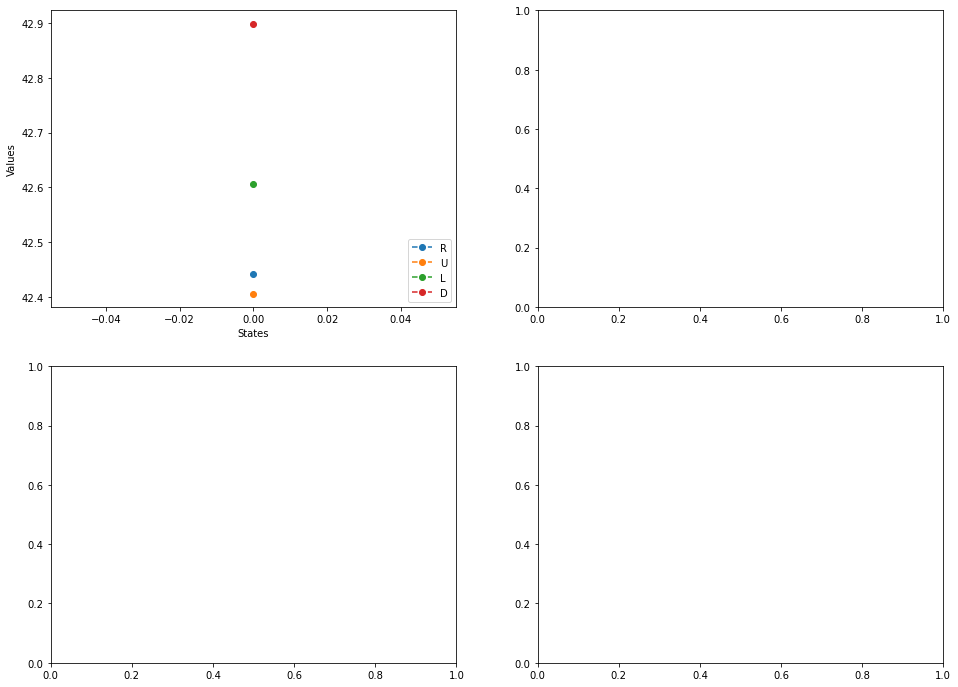

In [18]:
plot_performance(env, value_qlearning, reward_sums_qlearning)

# Citations
<a name="citations">
</a>



Kromer JA, Khaledi-Nasab A, Tass PA. Impact of number of stimulation sites on long-lasting desynchronization effects of coordinated reset stimulation. Chaos. 2020 Aug;30(8):083134. doi: 10.1063/5.0015196. PMID: 32872805.
